1. cdp_backtest() => 

從2020-01-01開始四年/一年/2024-01-01 ~ 2024-03-08 三個區段的return/ buy-and-hold return/ winrate、四年回測的圖表

2. cdp_backtest_all() => 

cdp_backtest() 的結果，tickers = 全部股票，可以輸出到excel的版本

3. cdp_backtest_all_check_what_elements_to_be_considered(days=day) => 

比起 cdp_backtest_all() 加上可以選擇要從2020-01-01再過去{day}天回測，可以當作找因子的公式

In [11]:
# daily decision version
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
def calculate_cdp_for_the_day(ticker):
    a = yf.download(ticker, start="2024-02-28", end=datetime.now()-timedelta(days=0), interval='1d', progress=False)
    a['typical'] = (a['Close']*2 + a['High'] + a['Low'])/4
    a['typical'] = a['typical']
    a['PT'] = (a['High'] - a['Low'])
    a["AH"] = a['typical'] + a['PT']
    a['NH'] = a['typical']*2 - a['Low']
    a['NL'] = a['typical']*2 - a['High']
    a["AL"] = a['typical'] - a['PT']
    return a
a =  ["WBD", "NVAX", 'TSM', "QCOM", "MU", "NVDA", "AMD", "GE", "TSLA", "DUOL"]
list_20240310 = ['CHTR', "VTRS", "ALB", "FMC", "AMD", "NVDA", "MSTR", "TSM"]
list_20240310_loose = ["D", "BR", "EBAY"]
for ticker in list_20240310_loose:
    s = calculate_cdp_for_the_day(ticker=ticker)
    print(ticker)    
    print(s[["NH", "NL", "Close", "Open"]].tail(2))

D
                   NH         NL      Close       Open
Date                                                  
2024-03-08  48.390001  47.609999  48.000000  47.990002
2024-03-11  47.932499  47.237499  47.584999  47.790001
BR
                    NH          NL       Close        Open
Date                                                      
2024-03-08  204.995003  202.105003  203.550003  204.910004
2024-03-11  203.612495  201.067497  202.339996  203.059998
EBAY
                   NH         NL      Close       Open
Date                                                  
2024-03-08  50.730000  50.009998  50.369999  50.680000
2024-03-11  52.560001  50.990002  51.775002  50.389999


In [2]:
# functions
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import tqdm
def cdp_backtest(print_vs_sp500=True, show_table=False, ticker='NVDA', debug=True, show_backtest = True, fee=0.005, start="2023-01-01", end=datetime.now(), hold_time = 0):
    a = yf.download(ticker, start=start, end= end, interval='1d', progress=False)

    # data cleaning
    a['typical'] = (a['Close']*2 + a['High'] + a['Low'])/4
    a['typical'] = a['typical'].shift(1)
    a['PT'] = (a['High'] - a['Low'])
    a["AH"] = a['typical'] + a['PT']
    a['NH'] = a['typical']*2 - a['Low']
    a['NL'] = a['typical']*2 - a['High']
    a["AL"] = a['typical'] - a['PT']
    # a['typical'] = a['typical'].shift(1)
    a.dropna(inplace=True)

    # get signal
    open = list(a['Open'])
    close = list(a['Close'])
    high = list(a['High'])
    low = list(a['Low'])
    typical = list(a['typical'])
    ah = list(a['AH'])
    nh = list(a['NH'])
    nl = list(a['NL'])
    al = list(a['AL'])
    comment = []
    signal = []
    max_dwardown = []
    for i in range(len(a)):
        if(open[i] > ah[i]):
            comment.append("trend buy")
            signal.append(4)
        elif(ah[i] > open[i] > nh[i]):
            comment.append("reverse sell")
            signal.append(3)
        elif(nh[i] > open[i] > nl[i]):
            comment.append("nothing")
            signal.append(2)
        elif(nl[i] > open[i] > al[i]):
            comment.append("reverse buy")
            signal.append(1)
        elif(al[i] > open[i]):
            comment.append("trend sell")
            signal.append(0)
        else:
            comment.append("error")
            signal.append(-1)
    a['signal'] = signal
    a['comment'] = comment

    # calculate backtest result v.s. buy and hold return
    signals = list(a['signal'])
    profits = []
    buy_and_hold = []
    if hold_time == 0:
        for i in range(len(a)):
            # calculate buy-and-hold return graph
            buy_and_hold.append(close[i]/open[0])
            # trend buy and reverse sell => buy
            if(signals[i] == 3 or signals[i] == 4):
                mdd = (low[i] - open[i])/open[i]
                profit = (1 + (close[i] - open[i])/open[i])*(1-fee)
            # trend sell and reverse buy => sell
            elif(signals[i] == 0 or signals[i] == 1):
                # sell
                mdd = (open[i] - high[i])/open[i]
                profit = (1 + (open[i] - close[i])/open[i])*(1-fee)
            
            elif(signals[i] == 2 or signals[i] == -1):
                #do nothing
                profit = 1
                mdd = 0
            max_dwardown.append(np.round(mdd, 3))
            profits.append(np.round(profit, 3))
    elif hold_time == 1:
        for i in range(len(a)):
            # calculate buy-and-hold return graph
            buy_and_hold.append(close[i]/open[0])
            # trend buy and reverse sell => buy
            if(signals[i] == 0 or signals[i] == 1):
                mdd = (low[i] - open[i])/open[i]
                profit = (1 + (open[i+1] - open[i])/open[i])*(1-fee)
            # trend sell and reverse buy => sell
            elif(signals[i] == 3 or signals[i] == 4):
                # sell
                mdd = (open[i] - high[i])/open[i]
                profit = (1 + (open[i] - open[i+1])/open[i])*(1-fee)
            
            elif(signals[i] == 2 or signals[i] == -1):
                #do nothing
                profit = 1
                mdd = 0
            max_dwardown.append(np.round(mdd, 3))
            profits.append(np.round(profit, 3))
        # elif(signals[i] == 3):
        #     #buy

        # elif(signals[i] == 4):
        #     # sell
        #     mdd = (open[i] - high[i])/open[i]
        #     profit = (1 + (open[i] - close[i])/open[i])*(1-fee)

    result = np.cumsum(np.log(profits))
    for i in range(len(result)):
        result[i] = result[i] + 1
    a['result'] = result
    a['daily_profit'] = profits
    a['buy_and_hold'] = buy_and_hold
    a['mdd'] = max_dwardown
    #debug
    res_db = a[["Open", "Close", "High", "comment", "daily_profit", "mdd"]]
    if debug == True and show_table == True:
        
        print(res_db[res_db['comment'] != "nothing"].tail(20))

    # calculation for compounded return & non-compounded return
    comp_return = []
    non_comp_return = []
    return_comprod = 1.0
    return_non_comp = 1.0
    for i in list(a['daily_profit']):
        return_comprod *= i
        return_non_comp += (i - 1)
        comp_return.append(return_comprod)
        non_comp_return.append(return_non_comp)
    a['comp_ret'] = comp_return
    a['non_comp_ret'] = non_comp_return
    if print_vs_sp500 == True:
        pass
    else:
        print("Buy and hold: ", list(a['buy_and_hold'])[-1])
        print("Non comp return: ", list(a['non_comp_ret'])[-1])
    return a

def cdp_backtest_all_check_what_elements_to_be_considered(tickers=['NVDA'], fee=0.05, start="2020-01-01", hold_time = 0, days=90):
    loop = 0
    with tqdm.tqdm(total=len(tickers)) as pbar:
        for ticker in tickers:
            print(ticker)
            a = yf.download(ticker, start=datetime.now() - timedelta(days=1529-730) - timedelta(days=days), end=datetime.now() - timedelta(days=days), interval='1d', progress=False)

            # data cleaning
            a['typical'] = (a['Close']*2 + a['High'] + a['Low'])/4
            a['typical'] = a['typical'].shift(1)
            a['PT'] = (a['High'] - a['Low'])
            a["AH"] = a['typical'] + a['PT']
            a['NH'] = a['typical']*2 - a['Low']
            a['NL'] = a['typical']*2 - a['High']
            a["AL"] = a['typical'] - a['PT']
            a.dropna(inplace=True)

            # get signal
            open = list(a['Open'])
            close = list(a['Close'])
            high = list(a['High'])
            low = list(a['Low'])
            ah = list(a['AH'])
            nh = list(a['NH'])
            nl = list(a['NL'])
            al = list(a['AL'])
            signal = []
            max_dwardown = []
            for i in range(len(a)):
                if(open[i] > ah[i]):
                    signal.append(4)
                elif(ah[i] > open[i] > nh[i]):
                    signal.append(3)
                elif(nh[i] > open[i] > nl[i]):
                    signal.append(2)
                elif(nl[i] > open[i] > al[i]):
                    signal.append(1)
                elif(al[i] > open[i]):
                    signal.append(0)
                else:
                    signal.append(-1)
            a['signal'] = signal

            # calculate backtest result v.s. buy and hold return
            signals = list(a['signal'])
            profits = []
            buy_and_hold = []
            if hold_time == 0:
                for i in range(len(a)):
                    # calculate buy-and-hold return graph
                    buy_and_hold.append(close[i]/open[0])
                    # trend buy and reverse sell => buy
                    if(signals[i] == 3 or signals[i] == 4):
                        mdd = (low[i] - open[i])/open[i]
                        profit = (1 + (close[i] - open[i])/open[i])*(1-fee)
                    # trend sell and reverse buy => sell
                    elif(signals[i] == 0 or signals[i] == 1):
                        # sell
                        mdd = (open[i] - high[i])/open[i]
                        profit = (1 + (open[i] - close[i])/open[i])*(1-fee)
                    
                    elif(signals[i] == 2 or signals[i] == -1):
                        #do nothing
                        profit = 1
                        mdd = 0
                    max_dwardown.append(np.round(mdd, 3))
                    profits.append(np.round(profit, 3))

            result = np.cumsum(np.log(profits))
            for i in range(len(result)):
                result[i] = result[i] + 1
            a['result'] = result
            a['daily_profit'] = profits
            a['buy_and_hold'] = buy_and_hold
            a['mdd'] = max_dwardown

            # calculation for compounded return & non-compounded return
            comp_return = []
            non_comp_return = []
            return_comprod = 1.0
            return_non_comp = 1.0
            for i in list(a['daily_profit']):
                return_comprod *= i
                return_non_comp += (i - 1)
                comp_return.append(return_comprod)
                non_comp_return.append(return_non_comp)
            a['comp_ret'] = comp_return
            a['non_comp_ret'] = non_comp_return

            one_year = a.iloc[-296:-46, :]
            year_td = a.iloc[-46:, :]

            buy_hold_4y = (buy_and_hold[-1] - buy_and_hold[0])/buy_and_hold[0] + 1
            buy_hold_1y = (buy_and_hold[-46] - buy_and_hold[-296])/buy_and_hold[-296] + 1
            buy_hold_td = (buy_and_hold[-1] - buy_and_hold[-46])/buy_and_hold[-46] + 1

            win_4y = a[a['daily_profit'] > 1]
            win_1y = one_year[one_year['daily_profit'] > 1]
            win_td = year_td[year_td['daily_profit'] > 1]
            
            lose_4y = a[a['daily_profit'] < 1]
            lose_1y = one_year[one_year['daily_profit'] < 1]
            lose_td = year_td[year_td['daily_profit'] < 1]

            win_rate_4y = np.round(len(win_4y)/(len(win_4y) + len(lose_4y))*100, 2)
            win_rate_1y = np.round(len(win_1y)/(len(win_1y) + len(lose_1y))*100, 2)
            win_rate_td = np.round(len(win_td)/(len(win_td) + len(lose_td))*100, 2)
            
            non_comp_4y = list(a['non_comp_ret'])[-1]
            non_comp_1y = list(year_td["result"])[-1] - list(year_td["result"])[0] + 1
            non_comp_td = list(one_year["result"])[-1] - list(one_year["result"])[0] + 1
            current = close[0]
            column_name = ["winrate_4y", "return_4y", "buyhold_4y", "winrate_1y", "return_1y", "buyhold_1y", "winrate_td", "return_td", "buyhold_td", "std_1y", "std_3m",\
                           "return_1m", "return_3m", "return_6m"]
            rows =         [np.round(win_rate_4y, 2) , np.round(non_comp_4y, 2),  np.round(buy_hold_4y, 2),  \
                            np.round(win_rate_1y, 2),  np.round(non_comp_1y, 2),  np.round(buy_hold_1y, 2),  \
                            np.round(win_rate_td, 2), np.round(non_comp_td, 2), np.round(buy_hold_td, 2), np.std(one_year['Close']), np.std(year_td['Close']), \
                            close[-20]/ current, close[-60]/ current, close[-120]/ current]
            if loop == 0:
                data = pd.DataFrame()
                data['ticker'] = column_name
                loop += 1
            data[ticker] = rows
            pbar.update(1)
    sc = data.T.reset_index()
    sc.columns = sc.iloc[0]
    sc = sc.drop(0)
    sc
    return sc

trend = ["NVDA", "AMD", "QCOM", "TSM", "COIN", "MSTR", "ARM"]
defensive = ['MCD', "C", "GS", "WBD", "NFLX"]
holding = ["AZEK", "CYBR", "GFF", "KKR", "RL", "TAP", "TW", "EVN", "NVRI"]
custom = ['6799.TW', "2330.TW", "4908.TWO"]
# C GS WBD NFLX
# no env ["AZEK", "CYBR", "GFF", "KKR", "RL", "TAP", "TW", "EVN", "NVRI"]

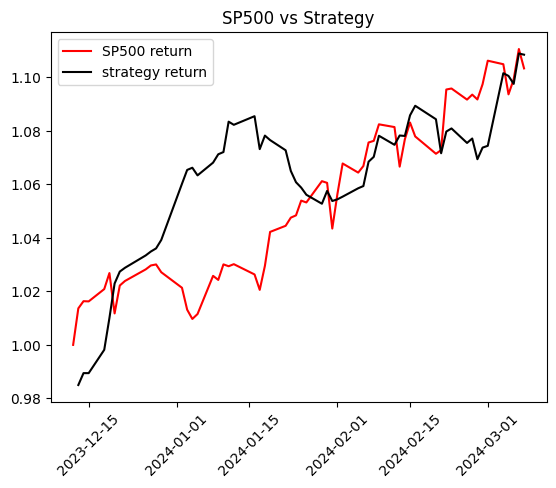

In [5]:
# 回測策略
days_0 = ["GEHC", "HUBB", "GE", "CHTR", "MAR", "D", "FMC", "MPC", "EBAY", "EIX", "OMC", "BR"] ## "UBER", "ABNB", 
days_90 = ["GE", "UBER", "ABNB", "NXPI", "URI", "CNC", "GWW", "D", "CHTR", "ACGL", "PEG", "PWR", "EIX", "AWK", "WBD", "RJF", "FE", "FDS", "CCL", "EG", "WBA", "MAS", "DPZ", "LW", "SWK", "UAL", "GEN", "BG", "IPG", "TRMB", "MKTX", "PARA", "ZION", "DVA"]
days_180 = ["AEE", "AZO", "CMS", "D", "DUK", "DVA", "ES", "FE", "GE", "T", "UAL", "WBD", "ZBRA"]
return_lists = {}

overall_good = ["WBD", "NVAX", "GE", "PODD"]
highest_winrate_6m = ["FOXA", "ZTS", "DLR"] 
highest_return_3m = ["WBD", "NVAX", "GE", "NCLH", "GNRC", "NFLX"] # xxx
highest_winrate_3m = ["ACGL", "ILMN", "APD", "BXP", "LKQ", "ETSY"] # xxx
highest_winrate_4y = ["WBD", "MRNA", "PAYC", "PARA", "ETSY", "CZR"]

for ticker in highest_winrate_4y:
    a = cdp_backtest(print_vs_sp500=True, show_table = False, ticker=ticker, debug=True, show_backtest=False, fee=0.005, start=datetime.now() - timedelta(days=90), end=datetime.now() - timedelta(days=0)) # end=datetime.now() - timedelta(days=90)
    return_lists[ticker] = list(a['result'])
# pd.DataFrame(return_lists, index=a.index)
# return_lists
s = pd.DataFrame(return_lists, index=a.index)
s['result'] = (list(s.sum(axis=1)))
s['result_v2'] = s['result']/len(highest_winrate_4y)

sp = yf.download("^GSPC", start=datetime.now() - timedelta(days=90), end=datetime.now() - timedelta(days=0), progress=False)
# def return_func(sp):
#     return sp['Close'] - sp['Close_1']
sp['return'] = sp['Close']/list(sp['Close'])[0]
plt.plot(sp['return'], label='SP500 return', color='red')
plt.plot(s['result_v2'], label='strategy return', color='black')
plt.xticks(rotation=45)
plt.legend()
plt.title("SP500 vs Strategy")
plt.show()

In [8]:
# output to csv to analyze stock selection/ stock screener
import json
route = ""
filemap = {
    "NYSE"  : route + "../Database/zackRanks_NYSE.json", # 1352
    "NASDAQ": route + '../Database/zackRanks_NASDAQ.json', # small:1255; mid:330; large:72
    "SP500" : route + "../Database/zackRanks_SP500.json", # small: 1352
   "Yuanta": route + "zackRanks_yuanta.json",
   "portfolio": route + "zackRanks_portfolio.json"
}
with open(filemap["SP500"], 'r') as f:
    python_dict = json.load(f)
    a = list(python_dict.keys())
custom_tickers = ["NVDA", "AMD", "SMCI", "QCOM", "AMD", "COIN", "MSTR", "AI"]
defensive = ["LLY", "NVO", "ENIC", "CIG", "BNTX", "ETR", "ABEV", "BMY", "VICI", "SNY", "UTHR", "CVS", "ACI", "PEG", "GSK", "C", "GS", "WBD", "MCD", "ABBV", "KO", "MO", "EPD", "JNJ", "JPM", "KMB", "SO"]
# asss = cdp_backtest_all(tickers=custom_tickers+defensive, fee=0.002, start = "2020-01-01", hold_time = 0)
# asss.to_csv("defensive_trend.csv") custom_tickers+defensive
for day in [0, 30, 60, 90, 120]:
    asss = cdp_backtest_all_check_what_elements_to_be_considered(tickers=a, fee=0.005, start = "2020-01-01", hold_time = 0, days=day)
    asss.to_csv(f"../Database/CDPs/SP500_3_6_9_12months_ago/{day}days_ago_check.csv")

    # "VLTO": {
    #     "2024-02-13": "2",
    #     "2024-02-14": "2",
    #     "2024-02-15": "2",
    #     "2024-02-16": "2",
    #     "2024-02-21": "2",
    #     "2024-02-22": "2",
    #     "2024-02-23": "2",
    #     "2024-02-26": "2",
    #     "2024-02-27": "2",
    #     "2024-02-28": "2",
    #     "2024-03-01": "2",
    #     "2024-03-05": "2",
    #     "2024-03-06": "2",
    #     "2024-03-07": "2"
    # },
    #     "KVUE": {
    #     "2024-02-13": "3",
    #     "2024-02-14": "5",
    #     "2024-02-15": "5",
    #     "2024-02-16": "5",
    #     "2024-02-21": "5",
    #     "2024-02-22": "4",
    #     "2024-02-23": "4",
    #     "2024-02-26": "5",
    #     "2024-02-27": "4",
    #     "2024-02-28": "4",
    #     "2024-03-01": "4",
    #     "2024-03-05": "4",
    #     "2024-03-06": "4",
    #     "2024-03-07": "4"
    # },


  0%|          | 0/495 [00:00<?, ?it/s]

MSFT


  0%|          | 1/495 [00:01<09:03,  1.10s/it]

AAPL


  1%|          | 3/495 [00:01<03:25,  2.40it/s]

NVDA
AMZN


  1%|          | 5/495 [00:01<02:05,  3.90it/s]

META
GOOGL


  1%|          | 6/495 [00:02<01:53,  4.33it/s]

GOOG


  1%|▏         | 7/495 [00:02<01:56,  4.19it/s]

AVGO


  2%|▏         | 9/495 [00:02<01:50,  4.42it/s]

TSLA
LLY


  2%|▏         | 10/495 [00:02<01:48,  4.48it/s]

JPM


  2%|▏         | 12/495 [00:03<01:46,  4.55it/s]

UNH
V


  3%|▎         | 13/495 [00:03<01:58,  4.05it/s]

XOM


  3%|▎         | 14/495 [00:04<02:30,  3.20it/s]

JNJ


  3%|▎         | 15/495 [00:04<03:38,  2.20it/s]

MA


  3%|▎         | 16/495 [00:05<03:22,  2.37it/s]

PG


  3%|▎         | 17/495 [00:05<03:00,  2.65it/s]

HD


  4%|▎         | 18/495 [00:05<02:51,  2.79it/s]

COST


  4%|▍         | 19/495 [00:06<02:33,  3.10it/s]

MRK


  4%|▍         | 20/495 [00:06<02:29,  3.18it/s]

ABBV


  4%|▍         | 22/495 [00:06<01:56,  4.05it/s]

ADBE
CRM


  5%|▍         | 24/495 [00:07<01:45,  4.48it/s]

AMD
CVX


  5%|▌         | 26/495 [00:07<01:34,  4.98it/s]

NFLX
WMT


  5%|▌         | 27/495 [00:07<01:42,  4.58it/s]

BAC


  6%|▌         | 29/495 [00:08<01:45,  4.41it/s]

PEP
KO


  6%|▌         | 30/495 [00:08<02:00,  3.87it/s]

ACN


  6%|▋         | 31/495 [00:08<02:01,  3.80it/s]

MCD


  7%|▋         | 33/495 [00:09<01:45,  4.38it/s]

TMO


  7%|▋         | 34/495 [00:09<01:39,  4.65it/s]

CSCO
ABT


  7%|▋         | 36/495 [00:10<01:41,  4.53it/s]

LIN
CMCSA


  8%|▊         | 38/495 [00:10<01:39,  4.60it/s]

INTC
WFC


  8%|▊         | 39/495 [00:10<01:38,  4.65it/s]

VZ


  8%|▊         | 40/495 [00:10<01:42,  4.44it/s]

ORCL


  8%|▊         | 41/495 [00:11<02:46,  2.73it/s]

INTU


  8%|▊         | 42/495 [00:12<04:42,  1.60it/s]

DIS


  9%|▊         | 43/495 [00:13<05:20,  1.41it/s]

AMGN


  9%|▉         | 44/495 [00:13<04:12,  1.78it/s]

IBM


  9%|▉         | 45/495 [00:14<03:37,  2.07it/s]

QCOM


  9%|▉         | 46/495 [00:14<03:16,  2.29it/s]

DHR


  9%|▉         | 47/495 [00:14<02:53,  2.59it/s]

NOW


 10%|▉         | 48/495 [00:15<02:31,  2.94it/s]

CAT


 10%|▉         | 49/495 [00:15<02:31,  2.95it/s]

PFE


 10%|█         | 50/495 [00:15<02:22,  3.12it/s]

UNP


 10%|█         | 51/495 [00:15<02:06,  3.50it/s]

TXN


 11%|█         | 52/495 [00:16<02:22,  3.12it/s]

SPGI


 11%|█         | 53/495 [00:16<02:09,  3.41it/s]

GE


 11%|█         | 54/495 [00:17<02:36,  2.81it/s]

PM


 11%|█         | 55/495 [00:17<02:40,  2.75it/s]

AMAT


 11%|█▏        | 56/495 [00:17<02:54,  2.52it/s]

UBER


 12%|█▏        | 57/495 [00:18<03:12,  2.27it/s]

HON


 12%|█▏        | 59/495 [00:18<02:27,  2.95it/s]

ISRG
COP


 12%|█▏        | 60/495 [00:19<02:50,  2.55it/s]

RTX


 12%|█▏        | 61/495 [00:20<03:58,  1.82it/s]

T


 13%|█▎        | 62/495 [00:20<03:49,  1.89it/s]

GS


 13%|█▎        | 63/495 [00:21<03:34,  2.01it/s]

NKE


 13%|█▎        | 64/495 [00:21<03:56,  1.82it/s]

LOW


 13%|█▎        | 66/495 [00:22<02:55,  2.44it/s]

BKNG
NEE


 14%|█▎        | 67/495 [00:22<02:30,  2.84it/s]

BA


 14%|█▍        | 69/495 [00:23<01:57,  3.62it/s]

PLD


 14%|█▍        | 70/495 [00:23<01:47,  3.96it/s]

MDT
ELV


 14%|█▍        | 71/495 [00:23<01:43,  4.09it/s]

AXP


 15%|█▍        | 73/495 [00:24<01:38,  4.27it/s]

SYK


 15%|█▍        | 74/495 [00:24<01:26,  4.85it/s]

VRTX
MS


 15%|█▌        | 75/495 [00:24<01:29,  4.71it/s]

LRCX


 15%|█▌        | 76/495 [00:24<01:29,  4.70it/s]

TJX


 16%|█▌        | 78/495 [00:25<01:25,  4.89it/s]

BLK
C


 16%|█▌        | 80/495 [00:25<01:20,  5.16it/s]

SBUX
DE


 17%|█▋        | 82/495 [00:25<01:26,  4.80it/s]

PANW
PGR


 17%|█▋        | 84/495 [00:26<01:24,  4.84it/s]

UPS
MDLZ


 17%|█▋        | 85/495 [00:26<01:28,  4.63it/s]

ADP


 17%|█▋        | 86/495 [00:26<01:57,  3.48it/s]

REGN


 18%|█▊        | 87/495 [00:27<02:27,  2.76it/s]

CB


 18%|█▊        | 88/495 [00:27<02:27,  2.77it/s]

BMY


 18%|█▊        | 89/495 [00:28<02:21,  2.87it/s]

ETN


 18%|█▊        | 91/495 [00:28<01:51,  3.62it/s]

GILD
ADI


 19%|█▊        | 92/495 [00:28<01:35,  4.20it/s]

MMC


 19%|█▉        | 93/495 [00:28<01:32,  4.36it/s]

CVS


 19%|█▉        | 94/495 [00:29<01:31,  4.41it/s]

LMT


 19%|█▉        | 96/495 [00:29<01:31,  4.38it/s]

MU
SCHW


 20%|█▉        | 98/495 [00:30<01:14,  5.34it/s]

BSX
AMT


 20%|██        | 99/495 [00:30<01:15,  5.22it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 20%|██        | 100/495 [00:30<01:12,  5.44it/s]

BX
CI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 20%|██        | 101/495 [00:30<01:24,  4.68it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


ZTS


 21%|██        | 102/495 [00:30<01:22,  4.78it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 21%|██        | 103/495 [00:30<01:13,  5.32it/s]

FI
TMUS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 21%|██        | 104/495 [00:31<01:12,  5.37it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 21%|██        | 105/495 [00:31<01:07,  5.79it/s]

SNPS
KLAC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 21%|██▏       | 106/495 [00:31<01:06,  5.84it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 22%|██▏       | 107/495 [00:31<01:04,  6.01it/s]

CDNS
EQIX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 22%|██▏       | 108/495 [00:31<01:04,  6.02it/s]

SO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 22%|██▏       | 109/495 [00:32<01:13,  5.25it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 22%|██▏       | 110/495 [00:32<01:11,  5.41it/s]

CME
DUK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 22%|██▏       | 111/495 [00:32<01:19,  4.84it/s]

ICE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 23%|██▎       | 112/495 [00:32<01:27,  4.37it/s]

SHW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 23%|██▎       | 113/495 [00:33<02:29,  2.55it/s]

ITW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 23%|██▎       | 114/495 [00:34<02:39,  2.38it/s]

MO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 23%|██▎       | 115/495 [00:34<02:22,  2.67it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


CSX


 23%|██▎       | 116/495 [00:34<02:03,  3.06it/s]

SLB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 24%|██▎       | 117/495 [00:34<01:55,  3.27it/s]

BDX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 24%|██▍       | 118/495 [00:34<01:46,  3.55it/s]

CL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 24%|██▍       | 119/495 [00:35<01:41,  3.70it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 24%|██▍       | 120/495 [00:35<01:32,  4.07it/s]

WM
MCK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 24%|██▍       | 121/495 [00:35<01:27,  4.27it/s]

EOG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 25%|██▍       | 122/495 [00:35<01:26,  4.33it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 25%|██▍       | 123/495 [00:35<01:15,  4.94it/s]

PYPL
CMG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 25%|██▌       | 124/495 [00:36<01:09,  5.32it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 25%|██▌       | 125/495 [00:36<01:05,  5.63it/s]

ANET
USB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 25%|██▌       | 126/495 [00:36<01:05,  5.67it/s]

TGT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 26%|██▌       | 127/495 [00:36<01:10,  5.23it/s]

PSX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 26%|██▌       | 128/495 [00:36<01:13,  4.97it/s]

NOC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 26%|██▌       | 129/495 [00:37<01:26,  4.23it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 26%|██▋       | 130/495 [00:37<01:17,  4.70it/s]

MPC
ABNB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 26%|██▋       | 131/495 [00:37<01:08,  5.35it/s]

MCO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 27%|██▋       | 132/495 [00:37<01:17,  4.66it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 27%|██▋       | 133/495 [00:37<01:07,  5.36it/s]

ORLY
TDG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 27%|██▋       | 134/495 [00:38<01:07,  5.37it/s]

HCA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 27%|██▋       | 135/495 [00:38<01:12,  4.97it/s]

APH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 27%|██▋       | 136/495 [00:39<02:09,  2.77it/s]

PNC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 28%|██▊       | 137/495 [00:39<02:18,  2.58it/s]

GD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 28%|██▊       | 138/495 [00:39<02:10,  2.73it/s]

AON


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 28%|██▊       | 139/495 [00:40<01:53,  3.14it/s]

PH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 28%|██▊       | 140/495 [00:40<01:52,  3.17it/s]

MAR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 28%|██▊       | 141/495 [00:40<01:42,  3.46it/s]

TT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 29%|██▊       | 142/495 [00:40<01:36,  3.66it/s]

ROP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 29%|██▉       | 143/495 [00:41<01:28,  3.97it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


FCX


 29%|██▉       | 144/495 [00:41<01:24,  4.17it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 29%|██▉       | 145/495 [00:41<01:18,  4.46it/s]

APD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 29%|██▉       | 146/495 [00:41<01:14,  4.70it/s]

FDX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 30%|██▉       | 147/495 [00:41<01:06,  5.24it/s]

NXPI
ADSK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 30%|██▉       | 148/495 [00:41<01:02,  5.52it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 30%|███       | 149/495 [00:42<00:59,  5.80it/s]

PXD
GM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 30%|███       | 150/495 [00:42<00:58,  5.89it/s]

MSI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 31%|███       | 151/495 [00:42<01:08,  5.03it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 31%|███       | 152/495 [00:42<01:06,  5.13it/s]

NSC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


PCAR


 31%|███       | 153/495 [00:42<01:07,  5.10it/s]

CTAS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 31%|███       | 154/495 [00:43<01:07,  5.06it/s]

EMR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 31%|███▏      | 155/495 [00:43<01:13,  4.62it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 32%|███▏      | 156/495 [00:43<01:05,  5.18it/s]

LULU
MMM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 32%|███▏      | 157/495 [00:43<01:11,  4.74it/s]

COF


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 32%|███▏      | 158/495 [00:43<01:16,  4.38it/s]

ECL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 32%|███▏      | 159/495 [00:44<02:02,  2.75it/s]

AJG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 32%|███▏      | 160/495 [00:45<02:09,  2.59it/s]

TFC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 33%|███▎      | 161/495 [00:45<02:11,  2.55it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 33%|███▎      | 162/495 [00:45<01:46,  3.11it/s]

HLT
AIG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 33%|███▎      | 163/495 [00:45<01:31,  3.61it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 33%|███▎      | 164/495 [00:45<01:16,  4.35it/s]

AZO
TRV


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 33%|███▎      | 165/495 [00:46<01:18,  4.18it/s]

WELL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 34%|███▎      | 166/495 [00:46<01:26,  3.79it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 34%|███▎      | 167/495 [00:46<01:13,  4.45it/s]

EW
ROST


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 34%|███▍      | 168/495 [00:46<01:09,  4.69it/s]

MSCI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 34%|███▍      | 169/495 [00:47<01:11,  4.57it/s]

VLO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 34%|███▍      | 170/495 [00:47<01:10,  4.60it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 35%|███▍      | 171/495 [00:47<01:04,  5.04it/s]

CCI
DXCM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 35%|███▍      | 172/495 [00:47<00:59,  5.42it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


HUM


 35%|███▍      | 173/495 [00:47<01:01,  5.26it/s]

F


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 35%|███▌      | 174/495 [00:48<01:06,  4.81it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 35%|███▌      | 175/495 [00:48<01:02,  5.12it/s]

MCHP
NUE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 36%|███▌      | 176/495 [00:48<01:10,  4.52it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 36%|███▌      | 177/495 [00:48<01:01,  5.16it/s]

CARR
SPG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 36%|███▌      | 178/495 [00:48<01:01,  5.15it/s]

O


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 36%|███▌      | 179/495 [00:49<01:07,  4.68it/s]

SRE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 36%|███▋      | 180/495 [00:49<01:07,  4.65it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


PSA


 37%|███▋      | 181/495 [00:49<01:05,  4.76it/s]

AFL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 37%|███▋      | 182/495 [00:49<01:14,  4.20it/s]

TEL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 37%|███▋      | 183/495 [00:50<01:55,  2.71it/s]

MET


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 37%|███▋      | 184/495 [00:51<02:15,  2.29it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 37%|███▋      | 185/495 [00:51<01:53,  2.74it/s]

DHI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 38%|███▊      | 186/495 [00:51<01:31,  3.39it/s]

IDXX
BK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 38%|███▊      | 187/495 [00:51<01:19,  3.89it/s]

DLR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 38%|███▊      | 188/495 [00:51<01:20,  3.83it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 38%|███▊      | 189/495 [00:52<01:09,  4.42it/s]

URI
WMB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 38%|███▊      | 190/495 [00:52<01:14,  4.11it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 39%|███▊      | 191/495 [00:52<01:04,  4.70it/s]

CPRT
FTNT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 39%|███▉      | 192/495 [00:52<00:58,  5.22it/s]

AEP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 39%|███▉      | 193/495 [00:52<01:05,  4.58it/s]

KMB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 39%|███▉      | 194/495 [00:53<01:11,  4.19it/s]

SYY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 39%|███▉      | 195/495 [00:53<01:08,  4.40it/s]

ALL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 40%|███▉      | 196/495 [00:53<01:13,  4.07it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 40%|███▉      | 197/495 [00:53<01:05,  4.55it/s]

MNST
CNC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 40%|████      | 198/495 [00:53<00:57,  5.16it/s]

NEM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 40%|████      | 199/495 [00:54<01:00,  4.89it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 40%|████      | 200/495 [00:54<00:58,  5.00it/s]

OKE
STZ


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 41%|████      | 201/495 [00:54<01:02,  4.72it/s]

GWW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 41%|████      | 202/495 [00:54<01:10,  4.15it/s]

LHX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 41%|████      | 203/495 [00:55<01:18,  3.74it/s]

PAYX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 41%|████      | 204/495 [00:55<01:40,  2.90it/s]

AMP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 41%|████▏     | 205/495 [00:56<01:37,  2.98it/s]

FAST


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 42%|████▏     | 206/495 [00:56<01:34,  3.05it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 42%|████▏     | 207/495 [00:56<01:17,  3.70it/s]

CEG
HES


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 42%|████▏     | 208/495 [00:56<01:10,  4.04it/s]

COR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 42%|████▏     | 209/495 [00:56<01:07,  4.25it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 42%|████▏     | 210/495 [00:57<00:59,  4.80it/s]

CTSH
D


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 43%|████▎     | 211/495 [00:57<01:05,  4.35it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 43%|████▎     | 212/495 [00:57<00:58,  4.81it/s]

IQV
A


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 43%|████▎     | 213/495 [00:57<00:53,  5.24it/s]

OXY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 43%|████▎     | 214/495 [00:57<01:02,  4.52it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 43%|████▎     | 215/495 [00:58<00:59,  4.72it/s]

PRU
GIS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 44%|████▎     | 216/495 [00:58<00:59,  4.70it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 44%|████▍     | 217/495 [00:58<00:53,  5.16it/s]

DOW
LEN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 44%|████▍     | 218/495 [00:58<00:54,  5.12it/s]

AME


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 44%|████▍     | 219/495 [00:58<00:59,  4.67it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 44%|████▍     | 220/495 [00:59<00:56,  4.88it/s]

CHTR
FIS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 45%|████▍     | 221/495 [00:59<00:57,  4.76it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


YUM


 45%|████▍     | 222/495 [00:59<00:56,  4.80it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 45%|████▌     | 223/495 [00:59<00:55,  4.94it/s]

OTIS
JCI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 45%|████▌     | 224/495 [00:59<00:57,  4.68it/s]

BIIB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 45%|████▌     | 225/495 [01:00<00:57,  4.72it/s]

IT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 46%|████▌     | 226/495 [01:00<00:59,  4.55it/s]

PCG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 46%|████▌     | 227/495 [01:01<01:36,  2.77it/s]

VRSK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 46%|████▌     | 228/495 [01:01<01:34,  2.82it/s]

RSG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 46%|████▋     | 229/495 [01:01<01:33,  2.84it/s]

ODFL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 46%|████▋     | 230/495 [01:02<01:22,  3.19it/s]

EXC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 47%|████▋     | 231/495 [01:02<01:26,  3.04it/s]

GPN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 47%|████▋     | 232/495 [01:02<01:20,  3.28it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 47%|████▋     | 233/495 [01:02<01:05,  4.01it/s]

CSGP
CMI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 47%|████▋     | 234/495 [01:02<01:03,  4.11it/s]

EA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 47%|████▋     | 235/495 [01:03<01:01,  4.23it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 48%|████▊     | 236/495 [01:03<00:52,  4.92it/s]

MRNA
PPG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 48%|████▊     | 237/495 [01:03<00:56,  4.55it/s]

XEL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 48%|████▊     | 238/495 [01:03<01:00,  4.25it/s]

KMI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 48%|████▊     | 239/495 [01:04<00:58,  4.39it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


IR


 48%|████▊     | 240/495 [01:04<00:59,  4.28it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 49%|████▊     | 241/495 [01:04<00:51,  4.93it/s]

CTVA
HAL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 49%|████▉     | 242/495 [01:04<01:06,  3.79it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 49%|████▉     | 243/495 [01:05<00:57,  4.35it/s]

KDP
MLM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 49%|████▉     | 244/495 [01:05<01:01,  4.07it/s]

ED


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 49%|████▉     | 245/495 [01:05<01:06,  3.77it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 50%|████▉     | 246/495 [01:05<00:57,  4.32it/s]

VICI
EL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 50%|████▉     | 247/495 [01:05<00:53,  4.61it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 50%|█████     | 248/495 [01:06<00:48,  5.08it/s]

ON
ACGL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 50%|█████     | 249/495 [01:06<00:45,  5.46it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 51%|█████     | 250/495 [01:06<00:43,  5.64it/s]

EXR
CDW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 51%|█████     | 251/495 [01:07<01:36,  2.53it/s]

KR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 51%|█████     | 252/495 [01:07<01:34,  2.58it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


VMC


 51%|█████     | 253/495 [01:07<01:20,  3.02it/s]

RCL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 51%|█████▏    | 254/495 [01:08<01:10,  3.42it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


EFX


 52%|█████▏    | 255/495 [01:08<01:03,  3.78it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 52%|█████▏    | 256/495 [01:08<00:56,  4.26it/s]

FICO
ADM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 52%|█████▏    | 257/495 [01:08<00:51,  4.64it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 52%|█████▏    | 258/495 [01:08<00:47,  5.00it/s]

KHC
ROK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 52%|█████▏    | 259/495 [01:08<00:47,  5.00it/s]

HSY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 53%|█████▎    | 260/495 [01:09<00:51,  4.58it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 53%|█████▎    | 261/495 [01:09<00:46,  5.06it/s]

DG
PEG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 53%|█████▎    | 262/495 [01:09<00:47,  4.87it/s]

BKR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 53%|█████▎    | 263/495 [01:09<00:47,  4.87it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 53%|█████▎    | 264/495 [01:09<00:44,  5.22it/s]

ANSS
PWR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 54%|█████▎    | 265/495 [01:10<00:58,  3.95it/s]

RMD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 54%|█████▎    | 266/495 [01:10<00:59,  3.84it/s]

WST


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 54%|█████▍    | 267/495 [01:10<01:03,  3.59it/s]

FTV


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 54%|█████▍    | 268/495 [01:11<00:59,  3.82it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 54%|█████▍    | 269/495 [01:11<00:51,  4.43it/s]

FANG
DLTR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 55%|█████▍    | 270/495 [01:11<00:46,  4.86it/s]

KEYS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 55%|█████▍    | 271/495 [01:11<00:47,  4.70it/s]

DVN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 55%|█████▍    | 272/495 [01:12<01:01,  3.61it/s]

CAH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 55%|█████▌    | 273/495 [01:12<01:33,  2.38it/s]

XYL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 55%|█████▌    | 274/495 [01:13<01:29,  2.46it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


DD


 56%|█████▌    | 275/495 [01:13<01:16,  2.87it/s]

DFS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 56%|█████▌    | 276/495 [01:13<01:09,  3.17it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 56%|█████▌    | 277/495 [01:13<00:57,  3.79it/s]

CBRE
ZBH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 56%|█████▌    | 278/495 [01:14<00:54,  3.99it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 56%|█████▋    | 279/495 [01:14<00:50,  4.25it/s]

HIG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 57%|█████▋    | 280/495 [01:14<00:44,  4.83it/s]

TTWO
MTD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 57%|█████▋    | 281/495 [01:14<00:41,  5.22it/s]

EIX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 57%|█████▋    | 282/495 [01:14<00:47,  4.46it/s]

WEC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 57%|█████▋    | 283/495 [01:15<00:51,  4.10it/s]

WTW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 57%|█████▋    | 284/495 [01:15<00:51,  4.10it/s]

DAL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 58%|█████▊    | 285/495 [01:15<00:53,  3.90it/s]

AVB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 58%|█████▊    | 286/495 [01:15<00:49,  4.25it/s]

HPQ


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 58%|█████▊    | 287/495 [01:16<00:51,  4.03it/s]

GLW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 58%|█████▊    | 288/495 [01:16<01:00,  3.43it/s]

ULTA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 58%|█████▊    | 289/495 [01:17<01:20,  2.56it/s]

CHD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 59%|█████▊    | 290/495 [01:17<01:36,  2.12it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 59%|█████▉    | 291/495 [01:17<01:15,  2.69it/s]

TSCO
TROW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 59%|█████▉    | 292/495 [01:18<01:04,  3.15it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 59%|█████▉    | 293/495 [01:18<00:53,  3.76it/s]

SBAC
BR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 59%|█████▉    | 294/495 [01:18<00:49,  4.08it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 60%|█████▉    | 295/495 [01:18<00:46,  4.31it/s]

AWK
WY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 60%|█████▉    | 296/495 [01:18<00:46,  4.28it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 60%|██████    | 297/495 [01:19<00:42,  4.68it/s]

LYB
WAB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 60%|██████    | 298/495 [01:19<00:38,  5.09it/s]

FITB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 60%|██████    | 299/495 [01:19<00:47,  4.12it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 61%|██████    | 300/495 [01:19<00:43,  4.46it/s]

APTV
MTB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 61%|██████    | 301/495 [01:20<00:42,  4.52it/s]

STT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 61%|██████    | 302/495 [01:20<00:42,  4.56it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


ILMN


 61%|██████    | 303/495 [01:20<00:40,  4.77it/s]

PHM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 61%|██████▏   | 304/495 [01:20<00:50,  3.75it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 62%|██████▏   | 305/495 [01:20<00:43,  4.41it/s]

NVR
WBD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 62%|██████▏   | 306/495 [01:21<00:38,  4.88it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 62%|██████▏   | 307/495 [01:21<00:37,  5.07it/s]

HWM
DTE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 62%|██████▏   | 308/495 [01:21<00:37,  4.94it/s]

STE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 62%|██████▏   | 309/495 [01:21<00:42,  4.40it/s]

PTC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 63%|██████▎   | 310/495 [01:22<01:06,  2.78it/s]

BLDR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 63%|██████▎   | 311/495 [01:22<01:12,  2.53it/s]

EBAY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 63%|██████▎   | 312/495 [01:23<01:04,  2.86it/s]

ETR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 63%|██████▎   | 313/495 [01:23<00:56,  3.20it/s]

DOV


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 63%|██████▎   | 314/495 [01:23<00:52,  3.47it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 64%|██████▎   | 315/495 [01:23<00:43,  4.14it/s]

FLT
RJF


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 64%|██████▍   | 316/495 [01:23<00:39,  4.54it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 64%|██████▍   | 317/495 [01:24<00:34,  5.16it/s]

MOH
IFF


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 64%|██████▍   | 318/495 [01:24<00:34,  5.11it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 64%|██████▍   | 319/495 [01:24<00:32,  5.34it/s]

EQR
EXPE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 65%|██████▍   | 320/495 [01:24<00:30,  5.68it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 65%|██████▍   | 321/495 [01:24<00:31,  5.60it/s]

GPC
IRM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 65%|██████▌   | 322/495 [01:24<00:29,  5.90it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 65%|██████▌   | 323/495 [01:25<00:27,  6.36it/s]

TDY
HPE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 65%|██████▌   | 324/495 [01:25<00:27,  6.28it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 66%|██████▌   | 325/495 [01:25<00:28,  5.93it/s]

BAX
NDAQ


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 66%|██████▌   | 326/495 [01:25<00:32,  5.21it/s]

DRI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 66%|██████▌   | 327/495 [01:25<00:39,  4.28it/s]

CBOE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 66%|██████▋   | 328/495 [01:26<00:40,  4.17it/s]

PPL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 66%|██████▋   | 329/495 [01:26<00:39,  4.18it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 67%|██████▋   | 330/495 [01:26<00:34,  4.79it/s]

ALGN
INVH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 67%|██████▋   | 331/495 [01:26<00:35,  4.68it/s]

FE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 67%|██████▋   | 332/495 [01:27<00:55,  2.94it/s]

ES


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 67%|██████▋   | 333/495 [01:27<00:58,  2.79it/s]

TRGP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 67%|██████▋   | 334/495 [01:28<00:56,  2.87it/s]

ARE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 68%|██████▊   | 335/495 [01:28<00:51,  3.13it/s]

LH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 68%|██████▊   | 336/495 [01:28<00:48,  3.29it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 68%|██████▊   | 337/495 [01:28<00:43,  3.65it/s]

WAT
CTRA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 68%|██████▊   | 338/495 [01:29<00:39,  3.97it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 68%|██████▊   | 339/495 [01:29<00:35,  4.42it/s]

VTR
AKAM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 69%|██████▊   | 340/495 [01:29<00:30,  5.04it/s]

COO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 69%|██████▉   | 341/495 [01:29<00:32,  4.78it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


EXPD


 69%|██████▉   | 342/495 [01:29<00:31,  4.87it/s]

WDC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 69%|██████▉   | 343/495 [01:30<00:34,  4.43it/s]

STLD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 69%|██████▉   | 344/495 [01:30<00:33,  4.50it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


GRMN


 70%|██████▉   | 345/495 [01:30<00:32,  4.55it/s]

BRO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 70%|██████▉   | 346/495 [01:30<00:32,  4.56it/s]

HBAN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 70%|███████   | 347/495 [01:30<00:31,  4.63it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 70%|███████   | 348/495 [01:31<00:28,  5.19it/s]

HOLX
NTAP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 71%|███████   | 349/495 [01:31<00:26,  5.43it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 71%|███████   | 350/495 [01:31<00:25,  5.59it/s]

FDS
LVS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 71%|███████   | 351/495 [01:31<00:29,  4.83it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 71%|███████   | 352/495 [01:31<00:28,  5.07it/s]

AEE
CLX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 71%|███████▏  | 353/495 [01:32<00:30,  4.64it/s]

HUBB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 72%|███████▏  | 354/495 [01:32<00:30,  4.65it/s]

OMC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 72%|███████▏  | 355/495 [01:33<00:48,  2.88it/s]

LUV


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 72%|███████▏  | 356/495 [01:33<00:51,  2.68it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 72%|███████▏  | 357/495 [01:33<00:41,  3.35it/s]

VRSN
CNP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 72%|███████▏  | 358/495 [01:33<00:39,  3.50it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 73%|███████▎  | 359/495 [01:34<00:33,  4.07it/s]

TYL
AXON


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 73%|███████▎  | 360/495 [01:34<00:30,  4.49it/s]

BALL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 73%|███████▎  | 361/495 [01:34<00:30,  4.44it/s]

CINF


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 73%|███████▎  | 362/495 [01:34<00:31,  4.18it/s]

RF


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 73%|███████▎  | 363/495 [01:34<00:30,  4.34it/s]

PFG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 74%|███████▎  | 364/495 [01:35<00:30,  4.27it/s]

MKC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 74%|███████▎  | 365/495 [01:35<00:32,  3.99it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 74%|███████▍  | 366/495 [01:35<00:27,  4.62it/s]

J
ATO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 74%|███████▍  | 367/495 [01:35<00:28,  4.52it/s]

SWKS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 74%|███████▍  | 368/495 [01:36<00:29,  4.28it/s]

CMS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 75%|███████▍  | 369/495 [01:36<00:30,  4.17it/s]

WRB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 75%|███████▍  | 370/495 [01:36<00:30,  4.14it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 75%|███████▍  | 371/495 [01:36<00:28,  4.40it/s]

CCL
EG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 75%|███████▌  | 372/495 [01:36<00:25,  4.75it/s]

TXT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 75%|███████▌  | 373/495 [01:37<00:37,  3.25it/s]

STX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 76%|███████▌  | 374/495 [01:38<00:50,  2.41it/s]

NTRS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 76%|███████▌  | 375/495 [01:38<00:50,  2.38it/s]

JBHT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 76%|███████▌  | 376/495 [01:38<00:42,  2.78it/s]

WBA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 76%|███████▌  | 377/495 [01:39<00:39,  2.95it/s]

AVY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 76%|███████▋  | 378/495 [01:39<00:37,  3.14it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


SYF


 77%|███████▋  | 379/495 [01:39<00:32,  3.58it/s]

JBL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 77%|███████▋  | 380/495 [01:39<00:30,  3.76it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 77%|███████▋  | 381/495 [01:39<00:25,  4.43it/s]

EPAM
IEX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 77%|███████▋  | 382/495 [01:40<00:24,  4.58it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 77%|███████▋  | 383/495 [01:40<00:23,  4.70it/s]

TSN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 78%|███████▊  | 384/495 [01:40<00:20,  5.29it/s]

FSLR
SNA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 78%|███████▊  | 385/495 [01:40<00:21,  5.20it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 78%|███████▊  | 386/495 [01:40<00:19,  5.52it/s]

CFG
MAS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 78%|███████▊  | 387/495 [01:41<00:21,  5.12it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 78%|███████▊  | 388/495 [01:41<00:19,  5.36it/s]

LDOS
ESS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 79%|███████▊  | 389/495 [01:41<00:19,  5.53it/s]

DPZ


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 79%|███████▉  | 390/495 [01:41<00:20,  5.02it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 79%|███████▉  | 391/495 [01:41<00:19,  5.21it/s]

PKG
TER


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 79%|███████▉  | 392/495 [01:41<00:21,  4.90it/s]

LW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 79%|███████▉  | 393/495 [01:42<00:23,  4.30it/s]

MAA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 80%|███████▉  | 394/495 [01:42<00:36,  2.75it/s]

CE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 80%|███████▉  | 395/495 [01:43<00:34,  2.91it/s]

EQT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 80%|████████  | 396/495 [01:43<00:30,  3.27it/s]

K


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 80%|████████  | 397/495 [01:43<00:29,  3.34it/s]

CF


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 80%|████████  | 398/495 [01:44<00:31,  3.04it/s]

SWK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 81%|████████  | 399/495 [01:44<00:30,  3.20it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


POOL


 81%|████████  | 400/495 [01:44<00:25,  3.68it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 81%|████████  | 401/495 [01:44<00:22,  4.14it/s]

DGX
ENPH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 81%|████████  | 402/495 [01:44<00:19,  4.81it/s]

VTRS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 81%|████████▏ | 403/495 [01:45<00:19,  4.64it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 82%|████████▏ | 404/495 [01:45<00:18,  4.98it/s]

BBY
CAG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 82%|████████▏ | 405/495 [01:45<00:17,  5.11it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 82%|████████▏ | 406/495 [01:45<00:16,  5.50it/s]

AMCR
KEY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 82%|████████▏ | 407/495 [01:45<00:16,  5.46it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 82%|████████▏ | 408/495 [01:46<00:16,  5.33it/s]

NDSN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 83%|████████▎ | 409/495 [01:46<00:14,  5.84it/s]

UAL
HST


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 83%|████████▎ | 410/495 [01:46<00:16,  5.29it/s]

SJM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 83%|████████▎ | 411/495 [01:46<00:18,  4.58it/s]

ALB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 83%|████████▎ | 412/495 [01:47<00:29,  2.81it/s]

MRO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 83%|████████▎ | 413/495 [01:47<00:31,  2.62it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 84%|████████▎ | 414/495 [01:47<00:24,  3.31it/s]

PODD
GEN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 84%|████████▍ | 415/495 [01:48<00:22,  3.60it/s]

RVTY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 84%|████████▍ | 416/495 [01:48<00:21,  3.70it/s]

BG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 84%|████████▍ | 417/495 [01:48<00:20,  3.75it/s]

IPG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 84%|████████▍ | 418/495 [01:48<00:20,  3.75it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 85%|████████▍ | 419/495 [01:49<00:17,  4.31it/s]

TRMB
LYV


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 85%|████████▍ | 420/495 [01:49<00:15,  4.90it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 85%|████████▌ | 421/495 [01:49<00:13,  5.37it/s]

LKQ
IP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 85%|████████▌ | 422/495 [01:49<00:15,  4.83it/s]

KIM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 85%|████████▌ | 423/495 [01:49<00:16,  4.38it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 86%|████████▌ | 424/495 [01:50<00:14,  5.01it/s]

ZBRA
LNT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 86%|████████▌ | 425/495 [01:50<00:13,  5.13it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 86%|████████▌ | 426/495 [01:50<00:13,  5.22it/s]

ROL
JKHY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 86%|████████▋ | 427/495 [01:50<00:14,  4.78it/s]

PNR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 86%|████████▋ | 428/495 [01:50<00:15,  4.32it/s]

NRG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 87%|████████▋ | 429/495 [01:51<00:23,  2.78it/s]

MGM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 87%|████████▋ | 430/495 [01:51<00:23,  2.83it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 87%|████████▋ | 431/495 [01:52<00:18,  3.42it/s]

JNPR
EVRG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 87%|████████▋ | 432/495 [01:52<00:17,  3.57it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 87%|████████▋ | 433/495 [01:52<00:15,  4.01it/s]

TAP
TFX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 88%|████████▊ | 434/495 [01:52<00:15,  4.03it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 88%|████████▊ | 435/495 [01:52<00:12,  4.72it/s]

KMX
AES


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 88%|████████▊ | 436/495 [01:53<00:11,  5.04it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 88%|████████▊ | 437/495 [01:53<00:11,  5.16it/s]

TECH
CRL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 88%|████████▊ | 438/495 [01:53<00:10,  5.69it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 89%|████████▊ | 439/495 [01:53<00:09,  6.08it/s]

INCY
UDR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 89%|████████▉ | 440/495 [01:53<00:09,  5.93it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 89%|████████▉ | 441/495 [01:53<00:08,  6.47it/s]

FFIV
ALLE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 89%|████████▉ | 442/495 [01:54<00:09,  5.71it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 89%|████████▉ | 443/495 [01:54<00:08,  6.04it/s]

DAY
GL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 90%|████████▉ | 444/495 [01:54<00:08,  5.68it/s]

NI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 90%|████████▉ | 445/495 [01:54<00:10,  4.80it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 90%|█████████ | 446/495 [01:54<00:09,  5.05it/s]

MTCH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 90%|█████████ | 447/495 [01:54<00:09,  5.27it/s]

REG
HII


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 91%|█████████ | 448/495 [01:55<00:10,  4.31it/s]

WRK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 91%|█████████ | 449/495 [01:56<00:17,  2.57it/s]

PEAK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 91%|█████████ | 450/495 [01:56<00:18,  2.37it/s]

MOS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 91%|█████████ | 451/495 [01:56<00:16,  2.63it/s]

CPT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 91%|█████████▏| 452/495 [01:57<00:14,  3.02it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 92%|█████████▏| 453/495 [01:57<00:12,  3.43it/s]

EMN
CHRW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 92%|█████████▏| 454/495 [01:57<00:11,  3.58it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 92%|█████████▏| 455/495 [01:57<00:09,  4.05it/s]

HSIC
QRVO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 92%|█████████▏| 456/495 [01:57<00:08,  4.72it/s]

BBWI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 92%|█████████▏| 457/495 [01:58<00:08,  4.28it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


UHS


 93%|█████████▎| 458/495 [01:58<00:08,  4.49it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 93%|█████████▎| 459/495 [01:58<00:07,  4.63it/s]

APA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 93%|█████████▎| 460/495 [01:58<00:07,  4.97it/s]

AOS
NWSA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 93%|█████████▎| 461/495 [01:58<00:06,  4.98it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


BXP


 93%|█████████▎| 462/495 [01:59<00:06,  4.98it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 94%|█████████▎| 463/495 [01:59<00:05,  5.70it/s]

CTLT
CZR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 94%|█████████▎| 464/495 [01:59<00:05,  5.71it/s]

AAL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 94%|█████████▍| 465/495 [01:59<00:06,  4.75it/s]

PAYC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 94%|█████████▍| 466/495 [02:00<00:09,  3.01it/s]

WYNN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 94%|█████████▍| 467/495 [02:00<00:12,  2.22it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 95%|█████████▍| 468/495 [02:01<00:09,  2.72it/s]

TPR
AIZ


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 95%|█████████▍| 469/495 [02:01<00:08,  3.20it/s]

CPB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 95%|█████████▍| 470/495 [02:01<00:07,  3.46it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 95%|█████████▌| 471/495 [02:01<00:06,  3.82it/s]

HRL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 95%|█████████▌| 472/495 [02:01<00:05,  4.28it/s]

MKTX
RHI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 96%|█████████▌| 473/495 [02:02<00:05,  4.38it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 96%|█████████▌| 474/495 [02:02<00:04,  5.00it/s]

FOXA
BWA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 96%|█████████▌| 475/495 [02:02<00:03,  5.00it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 96%|█████████▌| 476/495 [02:02<00:03,  5.35it/s]

ETSY
PNW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 96%|█████████▋| 477/495 [02:02<00:03,  5.44it/s]

BEN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 97%|█████████▋| 478/495 [02:03<00:03,  5.16it/s]

FRT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 97%|█████████▋| 479/495 [02:03<00:03,  4.98it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 97%|█████████▋| 480/495 [02:03<00:02,  5.54it/s]

NCLH
XRAY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 97%|█████████▋| 481/495 [02:03<00:02,  5.14it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 97%|█████████▋| 482/495 [02:03<00:02,  5.32it/s]

IVZ
FMC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 98%|█████████▊| 483/495 [02:04<00:02,  4.22it/s]

PARA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 98%|█████████▊| 484/495 [02:04<00:03,  3.38it/s]

GNRC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 98%|█████████▊| 485/495 [02:05<00:03,  2.55it/s]

CMA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 98%|█████████▊| 486/495 [02:05<00:03,  2.28it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 98%|█████████▊| 487/495 [02:05<00:02,  2.78it/s]

BIO
HAS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 99%|█████████▊| 488/495 [02:06<00:02,  3.03it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 99%|█████████▉| 489/495 [02:06<00:01,  3.44it/s]

ZION


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 99%|█████████▉| 490/495 [02:06<00:01,  3.80it/s]

WHR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 99%|█████████▉| 491/495 [02:06<00:00,  4.30it/s]

DVA
RL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 99%|█████████▉| 492/495 [02:06<00:00,  4.60it/s]

VFC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
100%|█████████▉| 493/495 [02:07<00:00,  4.70it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
100%|█████████▉| 494/495 [02:07<00:00,  5.25it/s]

MHK
GPS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
  0%|          | 0/495 [00:00<?, ?it/s]

MSFT


  0%|          | 1/495 [00:00<02:06,  3.92it/s]

AAPL


  0%|          | 2/495 [00:00<02:01,  4.07it/s]

NVDA


  1%|          | 4/495 [00:01<02:11,  3.73it/s]

AMZN
META


  1%|          | 5/495 [00:01<02:08,  3.81it/s]

GOOGL


  1%|          | 6/495 [00:01<02:10,  3.73it/s]

GOOG


  2%|▏         | 8/495 [00:02<02:14,  3.63it/s]

AVGO
TSLA


  2%|▏         | 9/495 [00:02<01:57,  4.12it/s]

LLY


  2%|▏         | 10/495 [00:02<01:57,  4.12it/s]

JPM


  2%|▏         | 11/495 [00:03<02:18,  3.49it/s]

UNH


  2%|▏         | 12/495 [00:03<03:04,  2.62it/s]

V


  3%|▎         | 13/495 [00:04<04:12,  1.91it/s]

XOM


  3%|▎         | 14/495 [00:04<03:53,  2.06it/s]

JNJ


  3%|▎         | 16/495 [00:05<02:57,  2.70it/s]

MA
PG


  4%|▎         | 18/495 [00:05<02:23,  3.33it/s]

HD


  4%|▍         | 19/495 [00:06<02:02,  3.88it/s]

COST
MRK


  4%|▍         | 21/495 [00:06<01:50,  4.29it/s]

ABBV
ADBE


  5%|▍         | 23/495 [00:06<01:30,  5.24it/s]

CRM
AMD


  5%|▍         | 24/495 [00:06<01:26,  5.42it/s]

CVX


  5%|▌         | 26/495 [00:07<01:29,  5.23it/s]

NFLX
WMT


  5%|▌         | 27/495 [00:07<01:34,  4.94it/s]

BAC


  6%|▌         | 28/495 [00:07<01:41,  4.61it/s]

PEP


  6%|▌         | 29/495 [00:08<01:51,  4.17it/s]

KO


  6%|▋         | 31/495 [00:08<01:43,  4.46it/s]

ACN
MCD


  6%|▋         | 32/495 [00:08<01:55,  4.01it/s]

TMO


  7%|▋         | 34/495 [00:09<01:47,  4.27it/s]

CSCO
ABT


  7%|▋         | 36/495 [00:09<01:40,  4.58it/s]

LIN
CMCSA


  8%|▊         | 38/495 [00:10<01:37,  4.67it/s]

INTC
WFC


  8%|▊         | 39/495 [00:10<01:42,  4.44it/s]

VZ


  8%|▊         | 40/495 [00:10<01:40,  4.53it/s]

ORCL


  8%|▊         | 41/495 [00:10<01:38,  4.63it/s]

INTU


  8%|▊         | 42/495 [00:11<01:39,  4.55it/s]

DIS


  9%|▊         | 43/495 [00:11<01:57,  3.86it/s]

AMGN


  9%|▉         | 44/495 [00:12<03:47,  1.98it/s]

IBM


  9%|▉         | 45/495 [00:13<04:06,  1.82it/s]

QCOM


  9%|▉         | 46/495 [00:13<03:47,  1.97it/s]

DHR


  9%|▉         | 47/495 [00:14<03:35,  2.08it/s]

NOW


 10%|▉         | 48/495 [00:14<03:13,  2.31it/s]

CAT


 10%|▉         | 49/495 [00:14<02:49,  2.63it/s]

PFE


 10%|█         | 50/495 [00:14<02:41,  2.75it/s]

UNP


 10%|█         | 51/495 [00:15<02:19,  3.17it/s]

TXN


 11%|█         | 52/495 [00:15<02:32,  2.90it/s]

SPGI


 11%|█         | 53/495 [00:15<02:17,  3.21it/s]

GE


 11%|█         | 55/495 [00:16<01:58,  3.73it/s]

PM
AMAT


 12%|█▏        | 57/495 [00:16<01:30,  4.86it/s]

UBER
HON


 12%|█▏        | 59/495 [00:17<01:37,  4.49it/s]

ISRG
COP


 12%|█▏        | 60/495 [00:17<01:38,  4.40it/s]

RTX


 12%|█▏        | 61/495 [00:17<01:37,  4.47it/s]

T


 13%|█▎        | 63/495 [00:18<01:40,  4.31it/s]

GS
NKE


 13%|█▎        | 64/495 [00:18<01:38,  4.38it/s]

LOW


 13%|█▎        | 66/495 [00:18<01:30,  4.75it/s]

BKNG
NEE


 14%|█▎        | 67/495 [00:18<01:29,  4.79it/s]

BA


 14%|█▎        | 68/495 [00:19<01:29,  4.76it/s]

PLD


 14%|█▍        | 69/495 [00:19<01:50,  3.86it/s]

MDT


 14%|█▍        | 70/495 [00:20<03:09,  2.25it/s]

ELV


 14%|█▍        | 71/495 [00:20<03:05,  2.28it/s]

AXP


 15%|█▍        | 72/495 [00:20<02:38,  2.66it/s]

SYK


 15%|█▍        | 74/495 [00:21<02:02,  3.43it/s]

VRTX
MS


 15%|█▌        | 76/495 [00:21<01:40,  4.15it/s]

LRCX


 16%|█▌        | 77/495 [00:21<01:34,  4.41it/s]

TJX
BLK


 16%|█▌        | 79/495 [00:22<01:34,  4.42it/s]

C
SBUX


 16%|█▌        | 80/495 [00:22<01:27,  4.76it/s]

DE


 17%|█▋        | 82/495 [00:23<01:24,  4.88it/s]

PANW
PGR


 17%|█▋        | 84/495 [00:23<01:20,  5.11it/s]

UPS
MDLZ


 17%|█▋        | 86/495 [00:23<01:18,  5.24it/s]

ADP


 18%|█▊        | 87/495 [00:23<01:15,  5.39it/s]

REGN
CB


 18%|█▊        | 88/495 [00:24<01:19,  5.13it/s]

BMY


 18%|█▊        | 89/495 [00:24<01:23,  4.89it/s]

ETN


 18%|█▊        | 91/495 [00:24<01:24,  4.78it/s]

GILD
ADI


 19%|█▊        | 92/495 [00:25<01:23,  4.83it/s]

MMC


 19%|█▉        | 93/495 [00:25<01:30,  4.44it/s]

CVS


 19%|█▉        | 94/495 [00:25<01:42,  3.91it/s]

LMT


 19%|█▉        | 95/495 [00:26<02:32,  2.62it/s]

MU


 20%|█▉        | 97/495 [00:26<02:01,  3.28it/s]

SCHW


 20%|█▉        | 98/495 [00:26<01:39,  3.98it/s]

BSX
AMT


 20%|██        | 99/495 [00:27<01:31,  4.31it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 20%|██        | 100/495 [00:27<01:21,  4.82it/s]

BX
CI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 20%|██        | 101/495 [00:27<01:26,  4.54it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 21%|██        | 102/495 [00:27<01:20,  4.90it/s]

ZTS
FI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 21%|██        | 103/495 [00:27<01:11,  5.46it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 21%|██        | 104/495 [00:27<01:06,  5.90it/s]

TMUS
SNPS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 21%|██        | 105/495 [00:28<01:05,  5.98it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 21%|██▏       | 106/495 [00:28<01:08,  5.65it/s]

KLAC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 22%|██▏       | 107/495 [00:28<01:03,  6.10it/s]

CDNS
EQIX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 22%|██▏       | 108/495 [00:28<01:03,  6.07it/s]

SO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 22%|██▏       | 109/495 [00:28<01:15,  5.12it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 22%|██▏       | 110/495 [00:29<01:13,  5.21it/s]

CME
DUK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 22%|██▏       | 111/495 [00:29<01:16,  5.02it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 23%|██▎       | 112/495 [00:29<01:13,  5.22it/s]

ICE
SHW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 23%|██▎       | 113/495 [00:29<01:34,  4.04it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 23%|██▎       | 114/495 [00:30<01:25,  4.46it/s]

ITW
MO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 23%|██▎       | 115/495 [00:30<01:31,  4.16it/s]

CSX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 23%|██▎       | 116/495 [00:30<01:41,  3.73it/s]

SLB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 24%|██▎       | 117/495 [00:31<02:28,  2.54it/s]

BDX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 24%|██▍       | 118/495 [00:31<02:13,  2.82it/s]

CL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 24%|██▍       | 119/495 [00:31<02:20,  2.68it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 24%|██▍       | 120/495 [00:32<01:55,  3.24it/s]

WM
MCK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 24%|██▍       | 121/495 [00:32<01:38,  3.79it/s]

EOG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 25%|██▍       | 122/495 [00:32<01:38,  3.78it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 25%|██▍       | 123/495 [00:32<01:24,  4.41it/s]

PYPL
CMG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 25%|██▌       | 124/495 [00:32<01:14,  5.01it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 25%|██▌       | 125/495 [00:32<01:07,  5.48it/s]

ANET
USB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 25%|██▌       | 126/495 [00:33<01:07,  5.47it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 26%|██▌       | 127/495 [00:33<01:06,  5.54it/s]

TGT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 26%|██▌       | 128/495 [00:33<01:03,  5.75it/s]

PSX
NOC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 26%|██▌       | 129/495 [00:33<01:04,  5.64it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 26%|██▋       | 130/495 [00:33<01:05,  5.61it/s]

MPC
ABNB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 26%|██▋       | 131/495 [00:34<01:03,  5.71it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 27%|██▋       | 132/495 [00:34<01:02,  5.80it/s]

MCO
ORLY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 27%|██▋       | 133/495 [00:34<01:01,  5.86it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 27%|██▋       | 134/495 [00:34<01:01,  5.90it/s]

TDG
HCA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 27%|██▋       | 135/495 [00:34<01:00,  5.93it/s]

APH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 27%|██▋       | 136/495 [00:34<01:02,  5.73it/s]

PNC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 28%|██▊       | 137/495 [00:35<01:09,  5.19it/s]

GD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 28%|██▊       | 138/495 [00:35<01:14,  4.81it/s]

AON


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 28%|██▊       | 139/495 [00:35<01:14,  4.75it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


PH


 28%|██▊       | 140/495 [00:35<01:13,  4.83it/s]

MAR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 28%|██▊       | 141/495 [00:36<01:14,  4.75it/s]

TT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 29%|██▊       | 142/495 [00:36<01:25,  4.13it/s]

ROP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 29%|██▉       | 143/495 [00:37<02:50,  2.07it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 29%|██▉       | 144/495 [00:37<02:16,  2.57it/s]

FCX
APD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 29%|██▉       | 145/495 [00:37<02:01,  2.87it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 29%|██▉       | 146/495 [00:37<01:43,  3.38it/s]

FDX
NXPI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 30%|██▉       | 147/495 [00:38<01:26,  4.00it/s]

ADSK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 30%|██▉       | 148/495 [00:38<01:35,  3.64it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


PXD


 30%|███       | 149/495 [00:38<01:25,  4.07it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 30%|███       | 150/495 [00:38<01:13,  4.69it/s]

GM
MSI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 31%|███       | 151/495 [00:38<01:13,  4.66it/s]

NSC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 31%|███       | 152/495 [00:39<01:17,  4.44it/s]

PCAR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 31%|███       | 153/495 [00:39<01:19,  4.30it/s]

CTAS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 31%|███       | 154/495 [00:39<01:16,  4.48it/s]

EMR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 31%|███▏      | 155/495 [00:40<01:27,  3.90it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 32%|███▏      | 156/495 [00:40<01:16,  4.45it/s]

LULU
MMM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 32%|███▏      | 157/495 [00:40<01:20,  4.22it/s]

COF


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 32%|███▏      | 158/495 [00:40<01:16,  4.42it/s]

ECL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 32%|███▏      | 159/495 [00:40<01:18,  4.29it/s]

AJG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 32%|███▏      | 160/495 [00:41<01:16,  4.38it/s]

TFC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 33%|███▎      | 161/495 [00:41<01:21,  4.08it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


HLT


 33%|███▎      | 162/495 [00:41<01:18,  4.26it/s]

AIG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 33%|███▎      | 163/495 [00:42<02:21,  2.35it/s]

AZO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 33%|███▎      | 164/495 [00:42<02:05,  2.63it/s]

TRV


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 33%|███▎      | 165/495 [00:42<01:50,  2.99it/s]

WELL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 34%|███▎      | 166/495 [00:43<01:47,  3.06it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 34%|███▎      | 167/495 [00:43<01:27,  3.76it/s]

EW
ROST


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 34%|███▍      | 168/495 [00:43<01:20,  4.07it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 34%|███▍      | 169/495 [00:43<01:10,  4.60it/s]

MSCI
VLO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 34%|███▍      | 170/495 [00:43<01:07,  4.82it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 35%|███▍      | 171/495 [00:44<01:01,  5.26it/s]

CCI
DXCM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 35%|███▍      | 172/495 [00:44<00:57,  5.57it/s]

HUM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 35%|███▍      | 173/495 [00:44<01:11,  4.52it/s]

F


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 35%|███▌      | 174/495 [00:44<01:14,  4.29it/s]

MCHP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 35%|███▌      | 175/495 [00:45<01:19,  4.01it/s]

NUE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 36%|███▌      | 176/495 [00:45<01:23,  3.82it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


CARR


 36%|███▌      | 177/495 [00:45<01:16,  4.15it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 36%|███▌      | 178/495 [00:45<01:08,  4.60it/s]

SPG
O


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 36%|███▌      | 179/495 [00:45<01:10,  4.46it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 36%|███▋      | 180/495 [00:46<01:06,  4.76it/s]

SRE
PSA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 37%|███▋      | 181/495 [00:46<01:03,  4.95it/s]

AFL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 37%|███▋      | 182/495 [00:46<01:03,  4.96it/s]

TEL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 37%|███▋      | 183/495 [00:46<01:16,  4.07it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


MET


 37%|███▋      | 184/495 [00:47<01:11,  4.35it/s]

DHI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 37%|███▋      | 185/495 [00:47<01:55,  2.68it/s]

IDXX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 38%|███▊      | 186/495 [00:48<01:39,  3.09it/s]

BK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 38%|███▊      | 187/495 [00:48<01:52,  2.74it/s]

DLR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 38%|███▊      | 188/495 [00:48<01:39,  3.08it/s]

URI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 38%|███▊      | 189/495 [00:48<01:29,  3.42it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 38%|███▊      | 190/495 [00:49<01:20,  3.78it/s]

WMB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 39%|███▊      | 191/495 [00:49<01:08,  4.44it/s]

CPRT
FTNT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 39%|███▉      | 192/495 [00:49<01:02,  4.81it/s]

AEP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 39%|███▉      | 193/495 [00:49<01:14,  4.07it/s]

KMB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 39%|███▉      | 194/495 [00:50<01:20,  3.75it/s]

SYY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 39%|███▉      | 195/495 [00:50<01:19,  3.78it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 40%|███▉      | 196/495 [00:50<01:14,  4.04it/s]

ALL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


MNST


 40%|███▉      | 197/495 [00:50<01:12,  4.11it/s]

CNC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 40%|████      | 198/495 [00:51<01:52,  2.64it/s]

NEM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 40%|████      | 199/495 [00:52<02:06,  2.34it/s]

OKE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 40%|████      | 200/495 [00:52<01:52,  2.61it/s]

STZ


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 41%|████      | 201/495 [00:52<01:38,  2.99it/s]

GWW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 41%|████      | 202/495 [00:52<01:27,  3.35it/s]

LHX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 41%|████      | 203/495 [00:52<01:21,  3.56it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 41%|████      | 204/495 [00:53<01:12,  4.00it/s]

PAYX
AMP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 41%|████▏     | 205/495 [00:53<01:05,  4.45it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 42%|████▏     | 206/495 [00:53<01:01,  4.71it/s]

FAST


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 42%|████▏     | 207/495 [00:53<00:58,  4.91it/s]

CEG
HES


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 42%|████▏     | 208/495 [00:53<00:58,  4.90it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


COR


 42%|████▏     | 209/495 [00:54<00:57,  4.96it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 42%|████▏     | 210/495 [00:54<00:51,  5.52it/s]

CTSH
D


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 43%|████▎     | 211/495 [00:54<00:55,  5.08it/s]

IQV


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 43%|████▎     | 212/495 [00:54<01:01,  4.62it/s]

A


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 43%|████▎     | 213/495 [00:55<01:57,  2.39it/s]

OXY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 43%|████▎     | 214/495 [00:56<02:08,  2.19it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 43%|████▎     | 215/495 [00:56<01:44,  2.68it/s]

PRU
GIS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 44%|████▎     | 216/495 [00:56<01:31,  3.04it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 44%|████▍     | 217/495 [00:56<01:16,  3.62it/s]

DOW
LEN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 44%|████▍     | 218/495 [00:56<01:10,  3.93it/s]

AME


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 44%|████▍     | 219/495 [00:57<01:13,  3.76it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 44%|████▍     | 220/495 [00:57<01:02,  4.41it/s]

CHTR
FIS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 45%|████▍     | 221/495 [00:57<00:59,  4.58it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


YUM


 45%|████▍     | 222/495 [00:57<00:57,  4.78it/s]

OTIS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 45%|████▌     | 223/495 [00:57<00:55,  4.87it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 45%|████▌     | 224/495 [00:58<00:53,  5.04it/s]

JCI
BIIB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 45%|████▌     | 225/495 [00:58<00:49,  5.44it/s]

IT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 46%|████▌     | 226/495 [00:58<01:04,  4.18it/s]

PCG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 46%|████▌     | 227/495 [00:59<01:47,  2.50it/s]

VRSK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 46%|████▌     | 228/495 [00:59<01:43,  2.58it/s]

RSG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 46%|████▋     | 229/495 [01:00<01:44,  2.56it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 46%|████▋     | 230/495 [01:00<01:26,  3.06it/s]

ODFL
EXC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 47%|████▋     | 231/495 [01:00<01:24,  3.14it/s]

GPN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 47%|████▋     | 232/495 [01:00<01:14,  3.51it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 47%|████▋     | 233/495 [01:00<01:02,  4.17it/s]

CSGP
CMI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 47%|████▋     | 234/495 [01:01<01:00,  4.30it/s]

EA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 47%|████▋     | 235/495 [01:01<00:57,  4.48it/s]

MRNA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 48%|████▊     | 236/495 [01:01<00:56,  4.62it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 48%|████▊     | 237/495 [01:01<00:53,  4.85it/s]

PPG
XEL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 48%|████▊     | 238/495 [01:02<00:58,  4.36it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 48%|████▊     | 239/495 [01:02<00:54,  4.70it/s]

KMI
IR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 48%|████▊     | 240/495 [01:02<00:50,  5.05it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 49%|████▊     | 241/495 [01:02<00:48,  5.19it/s]

CTVA
HAL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 49%|████▉     | 242/495 [01:02<01:05,  3.85it/s]

KDP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 49%|████▉     | 243/495 [01:03<01:43,  2.44it/s]

MLM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 49%|████▉     | 244/495 [01:04<01:43,  2.41it/s]

ED


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 49%|████▉     | 245/495 [01:04<01:36,  2.60it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 50%|████▉     | 246/495 [01:04<01:18,  3.17it/s]

VICI
EL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 50%|████▉     | 247/495 [01:04<01:10,  3.51it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 50%|█████     | 248/495 [01:04<00:59,  4.15it/s]

ON
ACGL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 50%|█████     | 249/495 [01:05<00:54,  4.51it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 51%|█████     | 250/495 [01:05<00:50,  4.86it/s]

EXR
CDW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 51%|█████     | 251/495 [01:05<00:46,  5.29it/s]

KR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 51%|█████     | 252/495 [01:05<00:50,  4.82it/s]

VMC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 51%|█████     | 253/495 [01:06<00:58,  4.13it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 51%|█████▏    | 254/495 [01:06<00:54,  4.39it/s]

RCL
EFX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 52%|█████▏    | 255/495 [01:06<00:58,  4.08it/s]

FICO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 52%|█████▏    | 256/495 [01:07<01:31,  2.62it/s]

ADM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 52%|█████▏    | 257/495 [01:07<01:58,  2.01it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 52%|█████▏    | 258/495 [01:08<01:32,  2.55it/s]

KHC
ROK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 52%|█████▏    | 259/495 [01:08<01:19,  2.96it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 53%|█████▎    | 260/495 [01:08<01:09,  3.39it/s]

HSY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 53%|█████▎    | 261/495 [01:08<01:01,  3.83it/s]

DG
PEG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 53%|█████▎    | 262/495 [01:09<01:01,  3.78it/s]

BKR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 53%|█████▎    | 263/495 [01:09<00:57,  4.00it/s]

ANSS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 53%|█████▎    | 264/495 [01:09<00:57,  4.01it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


PWR


 54%|█████▎    | 265/495 [01:09<00:53,  4.27it/s]

RMD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 54%|█████▎    | 266/495 [01:09<00:52,  4.37it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 54%|█████▍    | 267/495 [01:10<00:49,  4.64it/s]

WST


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 54%|█████▍    | 268/495 [01:10<00:44,  5.09it/s]

FTV
FANG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 54%|█████▍    | 269/495 [01:10<00:49,  4.52it/s]

DLTR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 55%|█████▍    | 270/495 [01:11<01:19,  2.82it/s]

KEYS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 55%|█████▍    | 271/495 [01:11<01:18,  2.87it/s]

DVN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 55%|█████▍    | 272/495 [01:11<01:13,  3.05it/s]

CAH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 55%|█████▌    | 273/495 [01:11<01:04,  3.44it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 55%|█████▌    | 274/495 [01:12<00:54,  4.04it/s]

XYL
DD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 56%|█████▌    | 275/495 [01:12<00:56,  3.86it/s]

DFS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 56%|█████▌    | 276/495 [01:12<00:53,  4.06it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


CBRE


 56%|█████▌    | 277/495 [01:12<00:49,  4.40it/s]

ZBH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 56%|█████▌    | 278/495 [01:13<00:48,  4.46it/s]

HIG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 56%|█████▋    | 279/495 [01:13<00:51,  4.20it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 57%|█████▋    | 280/495 [01:13<00:47,  4.52it/s]

TTWO
MTD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 57%|█████▋    | 281/495 [01:13<00:42,  5.02it/s]

EIX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 57%|█████▋    | 282/495 [01:14<00:54,  3.93it/s]

WEC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 57%|█████▋    | 283/495 [01:14<00:56,  3.77it/s]

WTW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 57%|█████▋    | 284/495 [01:14<01:22,  2.55it/s]

DAL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 58%|█████▊    | 285/495 [01:15<01:19,  2.65it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 58%|█████▊    | 286/495 [01:15<01:07,  3.09it/s]

AVB
HPQ


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 58%|█████▊    | 287/495 [01:15<01:04,  3.22it/s]

GLW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 58%|█████▊    | 288/495 [01:16<01:04,  3.20it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 58%|█████▊    | 289/495 [01:16<00:53,  3.87it/s]

ULTA
CHD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 59%|█████▊    | 290/495 [01:16<00:51,  3.98it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 59%|█████▉    | 291/495 [01:16<00:47,  4.33it/s]

TSCO
TROW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 59%|█████▉    | 292/495 [01:16<00:44,  4.51it/s]

SBAC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 59%|█████▉    | 293/495 [01:17<00:47,  4.24it/s]

BR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 59%|█████▉    | 294/495 [01:17<00:46,  4.36it/s]

AWK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 60%|█████▉    | 295/495 [01:17<00:47,  4.24it/s]

WY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 60%|█████▉    | 296/495 [01:18<01:11,  2.77it/s]

LYB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 60%|██████    | 297/495 [01:18<01:15,  2.64it/s]

WAB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 60%|██████    | 298/495 [01:18<01:10,  2.79it/s]

FITB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 60%|██████    | 299/495 [01:19<01:04,  3.02it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 61%|██████    | 300/495 [01:19<00:54,  3.61it/s]

APTV
MTB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 61%|██████    | 301/495 [01:19<00:47,  4.11it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 61%|██████    | 302/495 [01:19<00:44,  4.34it/s]

STT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 61%|██████    | 303/495 [01:19<00:38,  4.97it/s]

ILMN
PHM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 61%|██████▏   | 304/495 [01:20<00:38,  4.98it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 62%|██████▏   | 305/495 [01:20<00:35,  5.42it/s]

NVR
WBD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 62%|██████▏   | 306/495 [01:20<00:34,  5.55it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 62%|██████▏   | 307/495 [01:20<00:32,  5.84it/s]

HWM
DTE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 62%|██████▏   | 308/495 [01:20<00:42,  4.45it/s]

STE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 62%|██████▏   | 309/495 [01:21<01:07,  2.76it/s]

PTC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 63%|██████▎   | 310/495 [01:21<01:04,  2.87it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 63%|██████▎   | 311/495 [01:22<00:52,  3.50it/s]

BLDR
EBAY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 63%|██████▎   | 312/495 [01:22<00:45,  4.03it/s]

ETR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 63%|██████▎   | 313/495 [01:22<00:46,  3.91it/s]

DOV


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 63%|██████▎   | 314/495 [01:22<00:44,  4.04it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 64%|██████▎   | 315/495 [01:22<00:38,  4.69it/s]

FLT
RJF


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 64%|██████▍   | 316/495 [01:23<00:37,  4.81it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 64%|██████▍   | 317/495 [01:23<00:32,  5.50it/s]

MOH
IFF


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 64%|██████▍   | 318/495 [01:23<00:33,  5.34it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 64%|██████▍   | 319/495 [01:23<00:32,  5.37it/s]

EQR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


EXPE


 65%|██████▍   | 320/495 [01:23<00:34,  5.11it/s]

GPC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 65%|██████▍   | 321/495 [01:24<01:02,  2.80it/s]

IRM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 65%|██████▌   | 322/495 [01:25<01:10,  2.47it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 65%|██████▌   | 323/495 [01:25<00:55,  3.09it/s]

TDY
HPE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 65%|██████▌   | 324/495 [01:25<00:48,  3.49it/s]

BAX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 66%|██████▌   | 325/495 [01:25<00:49,  3.43it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 66%|██████▌   | 326/495 [01:25<00:41,  4.03it/s]

NDAQ
DRI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 66%|██████▌   | 327/495 [01:25<00:37,  4.47it/s]

CBOE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 66%|██████▋   | 328/495 [01:26<00:39,  4.18it/s]

PPL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 66%|██████▋   | 329/495 [01:26<00:40,  4.06it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 67%|██████▋   | 330/495 [01:26<00:35,  4.68it/s]

ALGN
INVH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 67%|██████▋   | 331/495 [01:26<00:39,  4.11it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 67%|██████▋   | 332/495 [01:27<00:35,  4.57it/s]

FE
ES


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 67%|██████▋   | 333/495 [01:27<00:44,  3.66it/s]

TRGP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 67%|██████▋   | 334/495 [01:27<00:49,  3.28it/s]

ARE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 68%|██████▊   | 335/495 [01:28<00:50,  3.14it/s]

LH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 68%|██████▊   | 336/495 [01:28<00:51,  3.08it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


WAT


 68%|██████▊   | 337/495 [01:28<00:45,  3.48it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 68%|██████▊   | 338/495 [01:28<00:40,  3.91it/s]

CTRA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 68%|██████▊   | 339/495 [01:29<00:34,  4.46it/s]

VTR
AKAM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 69%|██████▊   | 340/495 [01:29<00:31,  4.95it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 69%|██████▉   | 341/495 [01:29<00:30,  5.01it/s]

COO
EXPD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 69%|██████▉   | 342/495 [01:29<00:30,  4.96it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 69%|██████▉   | 343/495 [01:29<00:27,  5.52it/s]

WDC
STLD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 69%|██████▉   | 344/495 [01:30<00:30,  4.92it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 70%|██████▉   | 345/495 [01:30<00:30,  4.93it/s]

GRMN
BRO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 70%|██████▉   | 346/495 [01:30<00:31,  4.76it/s]

HBAN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 70%|███████   | 347/495 [01:30<00:32,  4.61it/s]

HOLX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 70%|███████   | 348/495 [01:31<00:46,  3.13it/s]

NTAP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 71%|███████   | 349/495 [01:31<00:51,  2.85it/s]

FDS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 71%|███████   | 350/495 [01:32<00:49,  2.93it/s]

LVS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 71%|███████   | 351/495 [01:32<00:48,  3.00it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 71%|███████   | 352/495 [01:32<00:41,  3.47it/s]

AEE
CLX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 71%|███████▏  | 353/495 [01:32<00:40,  3.47it/s]

HUBB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 72%|███████▏  | 354/495 [01:33<00:41,  3.42it/s]

OMC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 72%|███████▏  | 355/495 [01:33<00:41,  3.36it/s]

LUV


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 72%|███████▏  | 356/495 [01:33<00:37,  3.73it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 72%|███████▏  | 357/495 [01:33<00:30,  4.49it/s]

VRSN
CNP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 72%|███████▏  | 358/495 [01:34<00:37,  3.62it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 73%|███████▎  | 359/495 [01:34<00:32,  4.20it/s]

TYL
AXON


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 73%|███████▎  | 360/495 [01:34<00:50,  2.69it/s]

BALL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 73%|███████▎  | 361/495 [01:35<00:51,  2.62it/s]

CINF


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 73%|███████▎  | 362/495 [01:35<00:48,  2.76it/s]

RF


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 73%|███████▎  | 363/495 [01:35<00:44,  2.95it/s]

PFG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 74%|███████▎  | 364/495 [01:36<00:42,  3.07it/s]

MKC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 74%|███████▎  | 365/495 [01:36<00:41,  3.14it/s]

J


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 74%|███████▍  | 366/495 [01:36<00:37,  3.48it/s]

ATO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 74%|███████▍  | 367/495 [01:37<00:34,  3.76it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 74%|███████▍  | 368/495 [01:37<00:30,  4.21it/s]

SWKS
CMS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 75%|███████▍  | 369/495 [01:37<00:30,  4.17it/s]

WRB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 75%|███████▍  | 370/495 [01:37<00:30,  4.05it/s]

CCL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 75%|███████▍  | 371/495 [01:38<00:40,  3.09it/s]

EG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 75%|███████▌  | 372/495 [01:38<00:47,  2.59it/s]

TXT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 75%|███████▌  | 373/495 [01:39<00:43,  2.80it/s]

STX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 76%|███████▌  | 374/495 [01:39<00:37,  3.19it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 76%|███████▌  | 375/495 [01:39<00:33,  3.58it/s]

NTRS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 76%|███████▌  | 376/495 [01:39<00:29,  3.99it/s]

JBHT
WBA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 76%|███████▌  | 377/495 [01:39<00:27,  4.34it/s]

AVY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 76%|███████▋  | 378/495 [01:40<00:29,  3.90it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 77%|███████▋  | 379/495 [01:40<00:26,  4.45it/s]

SYF
JBL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 77%|███████▋  | 380/495 [01:40<00:25,  4.47it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 77%|███████▋  | 381/495 [01:40<00:23,  4.88it/s]

EPAM
IEX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 77%|███████▋  | 382/495 [01:41<00:52,  2.13it/s]

TSN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 77%|███████▋  | 383/495 [01:42<00:57,  1.95it/s]

FSLR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 78%|███████▊  | 384/495 [01:42<00:48,  2.27it/s]

SNA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 78%|███████▊  | 385/495 [01:42<00:43,  2.52it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 78%|███████▊  | 386/495 [01:43<00:35,  3.09it/s]

CFG
MAS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 78%|███████▊  | 387/495 [01:43<00:32,  3.31it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


LDOS


 78%|███████▊  | 388/495 [01:43<00:28,  3.79it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 79%|███████▊  | 389/495 [01:43<00:25,  4.23it/s]

ESS
DPZ


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 79%|███████▉  | 390/495 [01:43<00:22,  4.75it/s]

PKG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 79%|███████▉  | 391/495 [01:44<00:27,  3.81it/s]

TER


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 79%|███████▉  | 392/495 [01:44<00:35,  2.91it/s]

LW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 79%|███████▉  | 393/495 [01:45<00:36,  2.78it/s]

MAA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 80%|███████▉  | 394/495 [01:45<00:37,  2.68it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 80%|███████▉  | 395/495 [01:45<00:31,  3.22it/s]

CE
EQT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 80%|████████  | 396/495 [01:45<00:29,  3.36it/s]

K


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 80%|████████  | 397/495 [01:46<00:28,  3.41it/s]

CF


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 80%|████████  | 398/495 [01:46<00:28,  3.44it/s]

SWK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 81%|████████  | 399/495 [01:46<00:28,  3.40it/s]

POOL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 81%|████████  | 400/495 [01:47<00:29,  3.18it/s]

DGX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 81%|████████  | 401/495 [01:47<00:34,  2.70it/s]

ENPH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 81%|████████  | 402/495 [01:48<00:35,  2.63it/s]

VTRS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 81%|████████▏ | 403/495 [01:48<00:35,  2.63it/s]

BBY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 82%|████████▏ | 404/495 [01:48<00:30,  2.97it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 82%|████████▏ | 405/495 [01:48<00:25,  3.48it/s]

CAG
AMCR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 82%|████████▏ | 406/495 [01:49<00:24,  3.58it/s]

KEY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 82%|████████▏ | 407/495 [01:49<00:25,  3.50it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 82%|████████▏ | 408/495 [01:49<00:21,  4.00it/s]

NDSN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 83%|████████▎ | 409/495 [01:49<00:19,  4.51it/s]

UAL
HST


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 83%|████████▎ | 410/495 [01:49<00:18,  4.68it/s]

SJM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 83%|████████▎ | 411/495 [01:50<00:23,  3.55it/s]

ALB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 83%|████████▎ | 412/495 [01:51<00:35,  2.35it/s]

MRO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 83%|████████▎ | 413/495 [01:51<00:32,  2.49it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 84%|████████▎ | 414/495 [01:51<00:26,  3.09it/s]

PODD
GEN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 84%|████████▍ | 415/495 [01:51<00:22,  3.51it/s]

RVTY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 84%|████████▍ | 416/495 [01:52<00:21,  3.71it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 84%|████████▍ | 417/495 [01:52<00:18,  4.11it/s]

BG
IPG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 84%|████████▍ | 418/495 [01:52<00:19,  3.91it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 85%|████████▍ | 419/495 [01:52<00:16,  4.57it/s]

TRMB
LYV


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 85%|████████▍ | 420/495 [01:52<00:15,  4.79it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 85%|████████▌ | 421/495 [01:53<00:13,  5.29it/s]

LKQ
IP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 85%|████████▌ | 422/495 [01:53<00:13,  5.25it/s]

KIM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 85%|████████▌ | 423/495 [01:53<00:17,  4.02it/s]

ZBRA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 86%|████████▌ | 424/495 [01:54<00:26,  2.72it/s]

LNT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 86%|████████▌ | 425/495 [01:54<00:28,  2.49it/s]

ROL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 86%|████████▌ | 426/495 [01:54<00:23,  2.89it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


JKHY


 86%|████████▋ | 427/495 [01:55<00:20,  3.30it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 86%|████████▋ | 428/495 [01:55<00:18,  3.68it/s]

PNR
NRG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 87%|████████▋ | 429/495 [01:55<00:15,  4.25it/s]

MGM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 87%|████████▋ | 430/495 [01:55<00:15,  4.17it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 87%|████████▋ | 431/495 [01:55<00:14,  4.49it/s]

JNPR
EVRG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 87%|████████▋ | 432/495 [01:56<00:14,  4.33it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 87%|████████▋ | 433/495 [01:56<00:13,  4.51it/s]

TAP
TFX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 88%|████████▊ | 434/495 [01:56<00:13,  4.54it/s]

KMX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 88%|████████▊ | 435/495 [01:57<00:17,  3.45it/s]

AES


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 88%|████████▊ | 436/495 [01:57<00:27,  2.14it/s]

TECH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 88%|████████▊ | 437/495 [01:58<00:24,  2.41it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 88%|████████▊ | 438/495 [01:58<00:19,  2.92it/s]

CRL
INCY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 89%|████████▊ | 439/495 [01:58<00:15,  3.58it/s]

UDR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 89%|████████▉ | 440/495 [01:58<00:14,  3.89it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 89%|████████▉ | 441/495 [01:58<00:11,  4.57it/s]

FFIV
ALLE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 89%|████████▉ | 442/495 [01:59<00:11,  4.77it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 89%|████████▉ | 443/495 [01:59<00:09,  5.35it/s]

DAY
GL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 90%|████████▉ | 444/495 [01:59<00:09,  5.33it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


NI


 90%|████████▉ | 445/495 [01:59<00:09,  5.31it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 90%|█████████ | 446/495 [01:59<00:08,  5.79it/s]

MTCH
REG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 90%|█████████ | 447/495 [01:59<00:09,  5.11it/s]

HII


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 91%|█████████ | 448/495 [02:00<00:17,  2.68it/s]

WRK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 91%|█████████ | 449/495 [02:01<00:19,  2.41it/s]

PEAK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 91%|█████████ | 450/495 [02:01<00:16,  2.72it/s]

MOS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 91%|█████████ | 451/495 [02:01<00:14,  2.98it/s]

CPT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 91%|█████████▏| 452/495 [02:02<00:14,  3.00it/s]

EMN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 92%|█████████▏| 453/495 [02:02<00:12,  3.24it/s]

CHRW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 92%|█████████▏| 454/495 [02:02<00:13,  2.96it/s]

HSIC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 92%|█████████▏| 455/495 [02:02<00:11,  3.37it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 92%|█████████▏| 456/495 [02:03<00:09,  3.98it/s]

QRVO
BBWI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 92%|█████████▏| 457/495 [02:03<00:10,  3.65it/s]

UHS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 93%|█████████▎| 458/495 [02:03<00:12,  2.86it/s]

APA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 93%|█████████▎| 459/495 [02:04<00:12,  2.98it/s]

AOS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 93%|█████████▎| 460/495 [02:04<00:12,  2.91it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 93%|█████████▎| 461/495 [02:04<00:09,  3.50it/s]

NWSA
BXP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 93%|█████████▎| 462/495 [02:04<00:08,  3.81it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 94%|█████████▎| 463/495 [02:05<00:07,  4.42it/s]

CTLT
CZR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 94%|█████████▎| 464/495 [02:05<00:06,  4.70it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 94%|█████████▍| 465/495 [02:05<00:05,  5.27it/s]

AAL
PAYC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 94%|█████████▍| 466/495 [02:05<00:06,  4.72it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 94%|█████████▍| 467/495 [02:05<00:05,  4.80it/s]

WYNN
TPR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 95%|█████████▍| 468/495 [02:06<00:05,  4.59it/s]

AIZ


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 95%|█████████▍| 469/495 [02:06<00:07,  3.60it/s]

CPB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 95%|█████████▍| 470/495 [02:07<00:10,  2.37it/s]

HRL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 95%|█████████▌| 471/495 [02:07<00:09,  2.50it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 95%|█████████▌| 472/495 [02:07<00:07,  3.06it/s]

MKTX
RHI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 96%|█████████▌| 473/495 [02:08<00:06,  3.47it/s]

FOXA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 96%|█████████▌| 474/495 [02:08<00:05,  3.69it/s]

BWA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 96%|█████████▌| 475/495 [02:08<00:05,  3.48it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 96%|█████████▌| 476/495 [02:08<00:04,  4.16it/s]

ETSY
PNW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 96%|█████████▋| 477/495 [02:08<00:04,  4.29it/s]

BEN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 97%|█████████▋| 478/495 [02:09<00:04,  4.10it/s]

FRT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 97%|█████████▋| 479/495 [02:09<00:04,  3.70it/s]

NCLH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 97%|█████████▋| 480/495 [02:10<00:05,  2.58it/s]

XRAY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 97%|█████████▋| 481/495 [02:10<00:05,  2.41it/s]

IVZ


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 97%|█████████▋| 482/495 [02:10<00:04,  2.77it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 98%|█████████▊| 483/495 [02:11<00:03,  3.19it/s]

FMC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 98%|█████████▊| 484/495 [02:11<00:02,  3.71it/s]

PARA
GNRC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 98%|█████████▊| 485/495 [02:11<00:02,  4.26it/s]

CMA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 98%|█████████▊| 486/495 [02:11<00:02,  3.95it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 98%|█████████▊| 487/495 [02:11<00:01,  4.54it/s]

BIO
HAS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 99%|█████████▊| 488/495 [02:12<00:01,  3.55it/s]

ZION


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 99%|█████████▉| 489/495 [02:12<00:02,  2.48it/s]

WHR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 99%|█████████▉| 490/495 [02:13<00:02,  2.41it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 99%|█████████▉| 491/495 [02:13<00:01,  2.96it/s]

DVA
RL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 99%|█████████▉| 492/495 [02:13<00:00,  3.28it/s]

VFC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
100%|█████████▉| 493/495 [02:14<00:00,  3.59it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
100%|█████████▉| 494/495 [02:14<00:00,  4.20it/s]

MHK
GPS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
  0%|          | 0/495 [00:00<?, ?it/s]

MSFT


  0%|          | 2/495 [00:00<01:59,  4.14it/s]

AAPL
NVDA


  1%|          | 3/495 [00:00<02:30,  3.28it/s]

AMZN


  1%|          | 4/495 [00:01<04:01,  2.03it/s]

META


  1%|          | 6/495 [00:02<02:58,  2.73it/s]

GOOGL
GOOG


  2%|▏         | 8/495 [00:02<02:09,  3.77it/s]

AVGO


  2%|▏         | 9/495 [00:02<01:49,  4.45it/s]

TSLA
LLY


  2%|▏         | 11/495 [00:03<01:43,  4.68it/s]

JPM
UNH


  3%|▎         | 13/495 [00:03<01:35,  5.03it/s]

V
XOM


  3%|▎         | 14/495 [00:03<01:48,  4.44it/s]

JNJ


  3%|▎         | 15/495 [00:04<01:55,  4.14it/s]

MA


  3%|▎         | 16/495 [00:04<03:04,  2.59it/s]

PG


  4%|▎         | 18/495 [00:05<02:48,  2.82it/s]

HD


  4%|▍         | 19/495 [00:05<02:23,  3.33it/s]

COST
MRK


  4%|▍         | 21/495 [00:06<01:59,  3.96it/s]

ABBV
ADBE


  5%|▍         | 23/495 [00:06<01:37,  4.86it/s]

CRM
AMD


  5%|▍         | 24/495 [00:06<01:33,  5.02it/s]

CVX


  5%|▌         | 26/495 [00:07<01:25,  5.48it/s]

NFLX
WMT


  5%|▌         | 27/495 [00:07<01:49,  4.26it/s]

BAC


  6%|▌         | 28/495 [00:08<02:56,  2.65it/s]

PEP


  6%|▌         | 29/495 [00:08<03:13,  2.41it/s]

KO


  6%|▋         | 31/495 [00:09<02:27,  3.15it/s]

ACN
MCD


  7%|▋         | 33/495 [00:09<02:11,  3.53it/s]

TMO
CSCO


  7%|▋         | 35/495 [00:09<01:45,  4.34it/s]

ABT


  7%|▋         | 36/495 [00:10<01:39,  4.63it/s]

LIN
CMCSA


  7%|▋         | 37/495 [00:10<01:41,  4.52it/s]

INTC


  8%|▊         | 38/495 [00:11<02:55,  2.60it/s]

WFC


  8%|▊         | 40/495 [00:11<02:34,  2.94it/s]

VZ


  8%|▊         | 41/495 [00:11<02:12,  3.41it/s]

ORCL
INTU


  8%|▊         | 42/495 [00:12<02:06,  3.57it/s]

DIS


  9%|▉         | 44/495 [00:12<01:52,  4.01it/s]

AMGN
IBM


  9%|▉         | 45/495 [00:12<01:54,  3.93it/s]

QCOM


  9%|▉         | 46/495 [00:13<01:56,  3.87it/s]

DHR


  9%|▉         | 47/495 [00:13<02:05,  3.57it/s]

NOW


 10%|▉         | 48/495 [00:14<03:05,  2.40it/s]

CAT


 10%|▉         | 49/495 [00:14<03:03,  2.43it/s]

PFE


 10%|█         | 50/495 [00:14<02:53,  2.56it/s]

UNP


 10%|█         | 51/495 [00:15<02:33,  2.89it/s]

TXN


 11%|█         | 53/495 [00:15<01:59,  3.70it/s]

SPGI
GE


 11%|█         | 55/495 [00:16<01:52,  3.91it/s]

PM
AMAT


 11%|█▏        | 56/495 [00:16<01:42,  4.27it/s]

UBER


 12%|█▏        | 57/495 [00:16<01:50,  3.97it/s]

HON


 12%|█▏        | 58/495 [00:17<02:57,  2.46it/s]

ISRG


 12%|█▏        | 59/495 [00:17<03:01,  2.40it/s]

COP


 12%|█▏        | 60/495 [00:18<02:39,  2.72it/s]

RTX


 12%|█▏        | 61/495 [00:18<02:36,  2.77it/s]

T


 13%|█▎        | 62/495 [00:18<02:24,  3.00it/s]

GS


 13%|█▎        | 63/495 [00:18<02:13,  3.24it/s]

NKE


 13%|█▎        | 64/495 [00:19<02:07,  3.37it/s]

LOW


 13%|█▎        | 65/495 [00:19<02:03,  3.47it/s]

BKNG


 13%|█▎        | 66/495 [00:20<02:51,  2.50it/s]

NEE


 14%|█▎        | 67/495 [00:20<02:37,  2.72it/s]

BA


 14%|█▍        | 69/495 [00:21<02:17,  3.10it/s]

PLD


 14%|█▍        | 70/495 [00:21<02:00,  3.52it/s]

MDT


 14%|█▍        | 71/495 [00:21<01:42,  4.13it/s]

ELV
AXP


 15%|█▍        | 73/495 [00:21<01:39,  4.23it/s]

SYK


 15%|█▍        | 74/495 [00:21<01:26,  4.86it/s]

VRTX
MS


 15%|█▌        | 75/495 [00:22<01:23,  5.03it/s]

LRCX


 15%|█▌        | 76/495 [00:22<01:55,  3.63it/s]

TJX


 16%|█▌        | 77/495 [00:23<02:44,  2.54it/s]

BLK


 16%|█▌        | 78/495 [00:23<02:44,  2.54it/s]

C


 16%|█▌        | 79/495 [00:23<02:27,  2.81it/s]

SBUX


 16%|█▌        | 80/495 [00:24<02:12,  3.14it/s]

DE


 17%|█▋        | 82/495 [00:24<01:44,  3.94it/s]

PANW
PGR


 17%|█▋        | 84/495 [00:24<01:27,  4.68it/s]

UPS
MDLZ


 17%|█▋        | 86/495 [00:25<01:21,  5.01it/s]

ADP


 18%|█▊        | 87/495 [00:25<01:16,  5.31it/s]

REGN
CB


 18%|█▊        | 88/495 [00:26<02:37,  2.59it/s]

BMY


 18%|█▊        | 89/495 [00:26<02:42,  2.49it/s]

ETN


 18%|█▊        | 90/495 [00:27<02:22,  2.85it/s]

GILD


 18%|█▊        | 91/495 [00:27<02:09,  3.12it/s]

ADI


 19%|█▊        | 92/495 [00:27<01:58,  3.40it/s]

MMC


 19%|█▉        | 94/495 [00:27<01:46,  3.77it/s]

CVS


 19%|█▉        | 95/495 [00:28<01:34,  4.24it/s]

LMT
MU


 19%|█▉        | 96/495 [00:28<01:25,  4.65it/s]

SCHW


 20%|█▉        | 97/495 [00:28<01:26,  4.58it/s]

BSX


 20%|█▉        | 98/495 [00:28<01:31,  4.35it/s]

AMT


 20%|██        | 99/495 [00:29<02:34,  2.56it/s]

BX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 20%|██        | 100/495 [00:29<02:26,  2.69it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 20%|██        | 101/495 [00:30<02:05,  3.13it/s]

CI
ZTS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 21%|██        | 102/495 [00:30<01:54,  3.43it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 21%|██        | 103/495 [00:30<01:37,  4.01it/s]

FI
TMUS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 21%|██        | 104/495 [00:30<01:29,  4.36it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 21%|██        | 105/495 [00:30<01:16,  5.10it/s]

SNPS
KLAC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 21%|██▏       | 106/495 [00:30<01:18,  4.95it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 22%|██▏       | 107/495 [00:31<01:10,  5.52it/s]

CDNS
EQIX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 22%|██▏       | 108/495 [00:31<01:10,  5.48it/s]

SO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 22%|██▏       | 109/495 [00:32<02:19,  2.76it/s]

CME


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 22%|██▏       | 110/495 [00:32<02:19,  2.75it/s]

DUK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 22%|██▏       | 111/495 [00:32<02:14,  2.85it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 23%|██▎       | 112/495 [00:32<01:50,  3.45it/s]

ICE
SHW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 23%|██▎       | 113/495 [00:33<01:43,  3.70it/s]

ITW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 23%|██▎       | 114/495 [00:33<01:47,  3.55it/s]

MO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 23%|██▎       | 115/495 [00:33<01:52,  3.37it/s]

CSX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 23%|██▎       | 116/495 [00:34<01:49,  3.47it/s]

SLB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 24%|██▎       | 117/495 [00:34<02:45,  2.29it/s]

BDX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 24%|██▍       | 118/495 [00:35<02:27,  2.56it/s]

CL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 24%|██▍       | 119/495 [00:35<02:37,  2.39it/s]

WM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 24%|██▍       | 120/495 [00:35<02:19,  2.69it/s]

MCK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 24%|██▍       | 121/495 [00:36<02:05,  2.99it/s]

EOG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 25%|██▍       | 122/495 [00:36<01:57,  3.16it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 25%|██▍       | 123/495 [00:36<01:44,  3.56it/s]

PYPL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 25%|██▌       | 124/495 [00:36<01:26,  4.31it/s]

CMG
ANET


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 25%|██▌       | 125/495 [00:36<01:17,  4.75it/s]

USB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 25%|██▌       | 126/495 [00:37<02:17,  2.69it/s]

TGT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 26%|██▌       | 127/495 [00:38<02:32,  2.42it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


PSX


 26%|██▌       | 128/495 [00:38<02:06,  2.90it/s]

NOC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 26%|██▌       | 129/495 [00:38<01:59,  3.05it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 26%|██▋       | 130/495 [00:38<01:42,  3.56it/s]

MPC
ABNB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 26%|██▋       | 131/495 [00:38<01:28,  4.09it/s]

MCO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 27%|██▋       | 132/495 [00:39<01:32,  3.91it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


ORLY


 27%|██▋       | 133/495 [00:39<01:27,  4.16it/s]

TDG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 27%|██▋       | 134/495 [00:39<01:35,  3.79it/s]

HCA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 27%|██▋       | 135/495 [00:40<02:16,  2.63it/s]

APH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 27%|██▋       | 136/495 [00:40<02:29,  2.40it/s]

PNC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 28%|██▊       | 137/495 [00:41<02:15,  2.64it/s]

GD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 28%|██▊       | 138/495 [00:41<02:04,  2.87it/s]

AON


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 28%|██▊       | 139/495 [00:41<02:03,  2.89it/s]

PH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 28%|██▊       | 140/495 [00:42<01:57,  3.02it/s]

MAR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 28%|██▊       | 141/495 [00:42<02:00,  2.93it/s]

TT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 29%|██▊       | 142/495 [00:42<01:47,  3.27it/s]

ROP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 29%|██▉       | 143/495 [00:43<02:34,  2.28it/s]

FCX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 29%|██▉       | 144/495 [00:43<02:34,  2.28it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 29%|██▉       | 145/495 [00:44<02:07,  2.74it/s]

APD
FDX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 29%|██▉       | 146/495 [00:44<01:54,  3.04it/s]

NXPI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 30%|██▉       | 147/495 [00:44<01:43,  3.37it/s]

ADSK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 30%|██▉       | 148/495 [00:44<01:43,  3.34it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 30%|███       | 149/495 [00:44<01:28,  3.91it/s]

PXD
GM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 30%|███       | 150/495 [00:45<01:18,  4.41it/s]

MSI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 31%|███       | 151/495 [00:45<01:16,  4.47it/s]

NSC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 31%|███       | 152/495 [00:45<01:16,  4.48it/s]

PCAR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 31%|███       | 153/495 [00:46<02:10,  2.62it/s]

CTAS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 31%|███       | 154/495 [00:46<02:14,  2.54it/s]

EMR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 31%|███▏      | 155/495 [00:47<01:59,  2.84it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 32%|███▏      | 156/495 [00:47<01:36,  3.51it/s]

LULU
MMM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 32%|███▏      | 157/495 [00:47<01:30,  3.74it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 32%|███▏      | 158/495 [00:47<01:20,  4.17it/s]

COF
ECL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 32%|███▏      | 159/495 [00:47<01:14,  4.52it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


AJG


 32%|███▏      | 160/495 [00:47<01:10,  4.73it/s]

TFC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 33%|███▎      | 161/495 [00:48<01:09,  4.77it/s]

HLT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 33%|███▎      | 162/495 [00:48<01:10,  4.74it/s]

AIG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 33%|███▎      | 163/495 [00:49<02:10,  2.55it/s]

AZO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 33%|███▎      | 164/495 [00:49<02:10,  2.53it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 33%|███▎      | 165/495 [00:49<01:47,  3.07it/s]

TRV
WELL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 34%|███▎      | 166/495 [00:50<01:43,  3.19it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 34%|███▎      | 167/495 [00:50<01:25,  3.86it/s]

EW
ROST


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 34%|███▍      | 168/495 [00:50<01:19,  4.14it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 34%|███▍      | 169/495 [00:50<01:10,  4.61it/s]

MSCI
VLO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 34%|███▍      | 170/495 [00:50<01:11,  4.56it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 35%|███▍      | 171/495 [00:50<01:04,  5.04it/s]

CCI
DXCM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 35%|███▍      | 172/495 [00:51<00:59,  5.39it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 35%|███▍      | 173/495 [00:51<01:00,  5.31it/s]

HUM
F


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 35%|███▌      | 174/495 [00:51<01:24,  3.82it/s]

MCHP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 35%|███▌      | 175/495 [00:52<02:01,  2.64it/s]

NUE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 36%|███▌      | 176/495 [00:52<02:02,  2.60it/s]

CARR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 36%|███▌      | 177/495 [00:52<01:46,  2.99it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


SPG


 36%|███▌      | 178/495 [00:53<01:32,  3.44it/s]

O


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 36%|███▌      | 179/495 [00:53<01:29,  3.52it/s]

SRE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 36%|███▋      | 180/495 [00:53<01:36,  3.26it/s]

PSA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 37%|███▋      | 181/495 [00:54<01:37,  3.21it/s]

AFL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 37%|███▋      | 182/495 [00:54<01:57,  2.66it/s]

TEL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 37%|███▋      | 183/495 [00:55<02:23,  2.17it/s]

MET


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 37%|███▋      | 184/495 [00:55<02:13,  2.33it/s]

DHI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 37%|███▋      | 185/495 [00:55<01:59,  2.58it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 38%|███▊      | 186/495 [00:56<01:36,  3.22it/s]

IDXX
BK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 38%|███▊      | 187/495 [00:56<01:27,  3.54it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 38%|███▊      | 188/495 [00:56<01:16,  4.03it/s]

DLR
URI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 38%|███▊      | 189/495 [00:56<01:08,  4.47it/s]

WMB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 38%|███▊      | 190/495 [00:56<01:09,  4.42it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 39%|███▊      | 191/495 [00:56<01:00,  5.04it/s]

CPRT
FTNT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 39%|███▉      | 192/495 [00:57<01:03,  4.79it/s]

AEP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 39%|███▉      | 193/495 [00:57<01:38,  3.06it/s]

KMB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 39%|███▉      | 194/495 [00:58<01:36,  3.13it/s]

SYY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 39%|███▉      | 195/495 [00:58<01:35,  3.14it/s]

ALL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 40%|███▉      | 196/495 [00:58<01:37,  3.07it/s]

MNST


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 40%|███▉      | 197/495 [00:59<01:41,  2.94it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 40%|████      | 198/495 [00:59<01:22,  3.60it/s]

CNC
NEM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 40%|████      | 199/495 [00:59<01:18,  3.78it/s]

OKE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 40%|████      | 200/495 [00:59<01:24,  3.47it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 41%|████      | 201/495 [00:59<01:11,  4.10it/s]

STZ
GWW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 41%|████      | 202/495 [01:00<01:06,  4.39it/s]

LHX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 41%|████      | 203/495 [01:00<01:52,  2.59it/s]

PAYX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 41%|████      | 204/495 [01:01<02:04,  2.34it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 41%|████▏     | 205/495 [01:01<01:41,  2.87it/s]

AMP
FAST


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 42%|████▏     | 206/495 [01:01<01:26,  3.34it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 42%|████▏     | 207/495 [01:01<01:11,  4.01it/s]

CEG
HES


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 42%|████▏     | 208/495 [01:02<01:05,  4.35it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 42%|████▏     | 209/495 [01:02<01:00,  4.75it/s]

COR
CTSH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 42%|████▏     | 210/495 [01:02<00:55,  5.11it/s]

D


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 43%|████▎     | 211/495 [01:02<01:08,  4.17it/s]

IQV


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 43%|████▎     | 212/495 [01:03<01:08,  4.13it/s]

A


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 43%|████▎     | 213/495 [01:03<01:43,  2.73it/s]

OXY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 43%|████▎     | 214/495 [01:04<01:58,  2.36it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 43%|████▎     | 215/495 [01:04<01:36,  2.92it/s]

PRU
GIS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 44%|████▎     | 216/495 [01:04<01:22,  3.40it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 44%|████▍     | 217/495 [01:04<01:10,  3.93it/s]

DOW
LEN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 44%|████▍     | 218/495 [01:04<01:02,  4.44it/s]

AME


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 44%|████▍     | 219/495 [01:05<01:03,  4.37it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 44%|████▍     | 220/495 [01:05<00:57,  4.78it/s]

CHTR
FIS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 45%|████▍     | 221/495 [01:05<00:55,  4.97it/s]

YUM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 45%|████▍     | 222/495 [01:05<00:57,  4.74it/s]

OTIS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 45%|████▌     | 223/495 [01:06<01:07,  4.04it/s]

JCI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 45%|████▌     | 224/495 [01:06<01:49,  2.48it/s]

BIIB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 45%|████▌     | 225/495 [01:07<01:38,  2.74it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 46%|████▌     | 226/495 [01:07<01:21,  3.32it/s]

IT
PCG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 46%|████▌     | 227/495 [01:07<01:17,  3.48it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 46%|████▌     | 228/495 [01:07<01:04,  4.12it/s]

VRSK
RSG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 46%|████▋     | 229/495 [01:07<01:00,  4.42it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 46%|████▋     | 230/495 [01:07<00:57,  4.63it/s]

ODFL
EXC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 47%|████▋     | 231/495 [01:08<00:58,  4.52it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 47%|████▋     | 232/495 [01:08<00:53,  4.88it/s]

GPN
CSGP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 47%|████▋     | 233/495 [01:08<01:02,  4.20it/s]

CMI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 47%|████▋     | 234/495 [01:09<01:38,  2.64it/s]

EA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 47%|████▋     | 235/495 [01:09<01:37,  2.68it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 48%|████▊     | 236/495 [01:09<01:18,  3.32it/s]

MRNA
PPG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 48%|████▊     | 237/495 [01:10<01:08,  3.76it/s]

XEL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 48%|████▊     | 238/495 [01:10<01:07,  3.83it/s]

KMI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 48%|████▊     | 239/495 [01:10<01:09,  3.67it/s]

IR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 48%|████▊     | 240/495 [01:10<01:05,  3.90it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 49%|████▊     | 241/495 [01:11<00:58,  4.33it/s]

CTVA
HAL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 49%|████▉     | 242/495 [01:11<01:02,  4.08it/s]

KDP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 49%|████▉     | 243/495 [01:12<01:36,  2.62it/s]

MLM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 49%|████▉     | 244/495 [01:12<01:43,  2.41it/s]

ED


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 49%|████▉     | 245/495 [01:12<01:32,  2.72it/s]

VICI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 50%|████▉     | 246/495 [01:13<01:26,  2.87it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 50%|████▉     | 247/495 [01:13<01:15,  3.30it/s]

EL
ON


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 50%|█████     | 248/495 [01:13<01:07,  3.68it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 50%|█████     | 249/495 [01:13<00:57,  4.25it/s]

ACGL
EXR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 51%|█████     | 250/495 [01:13<00:51,  4.77it/s]

CDW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 51%|█████     | 251/495 [01:14<00:55,  4.37it/s]

KR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 51%|█████     | 252/495 [01:14<01:34,  2.56it/s]

VMC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 51%|█████     | 253/495 [01:15<01:43,  2.35it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


RCL


 51%|█████▏    | 254/495 [01:15<01:25,  2.82it/s]

EFX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 52%|█████▏    | 255/495 [01:15<01:31,  2.62it/s]

FICO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 52%|█████▏    | 256/495 [01:16<01:26,  2.76it/s]

ADM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 52%|█████▏    | 257/495 [01:16<01:24,  2.82it/s]

KHC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 52%|█████▏    | 258/495 [01:16<01:26,  2.73it/s]

ROK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 52%|█████▏    | 259/495 [01:17<01:57,  2.00it/s]

HSY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 53%|█████▎    | 260/495 [01:18<01:46,  2.21it/s]

DG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 53%|█████▎    | 261/495 [01:18<01:32,  2.53it/s]

PEG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 53%|█████▎    | 262/495 [01:18<01:27,  2.67it/s]

BKR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 53%|█████▎    | 263/495 [01:19<01:29,  2.60it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 53%|█████▎    | 264/495 [01:19<01:11,  3.22it/s]

ANSS
PWR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 54%|█████▎    | 265/495 [01:19<01:08,  3.37it/s]

RMD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 54%|█████▎    | 266/495 [01:20<01:33,  2.45it/s]

WST


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 54%|█████▍    | 267/495 [01:20<01:26,  2.63it/s]

FTV


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 54%|█████▍    | 268/495 [01:20<01:26,  2.62it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 54%|█████▍    | 269/495 [01:21<01:10,  3.20it/s]

FANG
DLTR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 55%|█████▍    | 270/495 [01:21<00:59,  3.77it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 55%|█████▍    | 271/495 [01:21<00:50,  4.44it/s]

KEYS
DVN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 55%|█████▍    | 272/495 [01:21<00:49,  4.51it/s]

CAH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 55%|█████▌    | 273/495 [01:21<00:54,  4.08it/s]

XYL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 55%|█████▌    | 274/495 [01:22<00:57,  3.82it/s]

DD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 56%|█████▌    | 275/495 [01:23<01:39,  2.22it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 56%|█████▌    | 276/495 [01:23<01:20,  2.72it/s]

DFS
CBRE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 56%|█████▌    | 277/495 [01:23<01:07,  3.25it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 56%|█████▌    | 278/495 [01:23<00:57,  3.75it/s]

ZBH
HIG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 56%|█████▋    | 279/495 [01:23<00:50,  4.24it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 57%|█████▋    | 280/495 [01:23<00:46,  4.66it/s]

TTWO
MTD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 57%|█████▋    | 281/495 [01:24<00:42,  5.03it/s]

EIX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 57%|█████▋    | 282/495 [01:24<00:49,  4.31it/s]

WEC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 57%|█████▋    | 283/495 [01:24<01:00,  3.49it/s]

WTW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 57%|█████▋    | 284/495 [01:25<01:23,  2.53it/s]

DAL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 58%|█████▊    | 285/495 [01:25<01:26,  2.43it/s]

AVB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 58%|█████▊    | 286/495 [01:26<01:13,  2.83it/s]

HPQ


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 58%|█████▊    | 287/495 [01:26<01:12,  2.88it/s]

GLW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 58%|█████▊    | 288/495 [01:26<01:09,  2.99it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 58%|█████▊    | 289/495 [01:26<00:55,  3.72it/s]

ULTA
CHD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 59%|█████▊    | 290/495 [01:27<00:52,  3.87it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 59%|█████▉    | 291/495 [01:27<00:46,  4.42it/s]

TSCO
TROW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 59%|█████▉    | 292/495 [01:27<00:55,  3.67it/s]

SBAC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 59%|█████▉    | 293/495 [01:28<01:24,  2.39it/s]

BR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 59%|█████▉    | 294/495 [01:28<01:20,  2.50it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 60%|█████▉    | 295/495 [01:28<01:05,  3.03it/s]

AWK
WY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 60%|█████▉    | 296/495 [01:29<00:58,  3.38it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 60%|██████    | 297/495 [01:29<00:50,  3.95it/s]

LYB
WAB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 60%|██████    | 298/495 [01:29<00:50,  3.91it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


FITB


 60%|██████    | 299/495 [01:29<00:46,  4.19it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 61%|██████    | 300/495 [01:29<00:40,  4.81it/s]

APTV
MTB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 61%|██████    | 301/495 [01:30<00:42,  4.54it/s]

STT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 61%|██████    | 302/495 [01:30<01:17,  2.50it/s]

ILMN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 61%|██████    | 303/495 [01:31<01:18,  2.44it/s]

PHM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 61%|██████▏   | 304/495 [01:31<01:08,  2.80it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 62%|██████▏   | 305/495 [01:31<00:54,  3.47it/s]

NVR
WBD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 62%|██████▏   | 306/495 [01:31<00:49,  3.85it/s]

HWM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 62%|██████▏   | 307/495 [01:32<00:50,  3.74it/s]

DTE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 62%|██████▏   | 308/495 [01:32<00:53,  3.49it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 62%|██████▏   | 309/495 [01:32<00:46,  4.03it/s]

STE
PTC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 63%|██████▎   | 310/495 [01:32<00:40,  4.52it/s]

BLDR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 63%|██████▎   | 311/495 [01:33<00:47,  3.88it/s]

EBAY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 63%|██████▎   | 312/495 [01:33<01:12,  2.51it/s]

ETR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 63%|██████▎   | 313/495 [01:34<01:13,  2.49it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 63%|██████▎   | 314/495 [01:34<01:00,  3.00it/s]

DOV
FLT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 64%|██████▎   | 315/495 [01:34<00:50,  3.54it/s]

RJF


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 64%|██████▍   | 316/495 [01:35<00:53,  3.36it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 64%|██████▍   | 317/495 [01:35<00:44,  4.02it/s]

MOH
IFF


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 64%|██████▍   | 318/495 [01:35<00:42,  4.19it/s]

EQR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 64%|██████▍   | 319/495 [01:35<00:40,  4.30it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 65%|██████▍   | 320/495 [01:35<00:37,  4.66it/s]

EXPE
GPC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 65%|██████▍   | 321/495 [01:36<00:42,  4.07it/s]

IRM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 65%|██████▌   | 322/495 [01:36<01:03,  2.74it/s]

TDY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 65%|██████▌   | 323/495 [01:37<01:04,  2.65it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 65%|██████▌   | 324/495 [01:37<00:52,  3.28it/s]

HPE
BAX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 66%|██████▌   | 325/495 [01:37<00:45,  3.70it/s]

NDAQ


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 66%|██████▌   | 326/495 [01:37<00:43,  3.90it/s]

DRI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 66%|██████▌   | 327/495 [01:38<00:47,  3.53it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 66%|██████▋   | 328/495 [01:38<00:40,  4.15it/s]

CBOE
PPL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 66%|██████▋   | 329/495 [01:38<00:39,  4.21it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 67%|██████▋   | 330/495 [01:38<00:33,  4.96it/s]

ALGN
INVH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 67%|██████▋   | 331/495 [01:38<00:31,  5.26it/s]

FE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 67%|██████▋   | 332/495 [01:39<01:00,  2.71it/s]

ES


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 67%|██████▋   | 333/495 [01:39<00:55,  2.93it/s]

TRGP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 67%|██████▋   | 334/495 [01:40<00:52,  3.04it/s]

ARE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 68%|██████▊   | 335/495 [01:40<00:50,  3.20it/s]

LH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 68%|██████▊   | 336/495 [01:40<00:47,  3.33it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 68%|██████▊   | 337/495 [01:40<00:40,  3.94it/s]

WAT
CTRA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 68%|██████▊   | 338/495 [01:40<00:36,  4.29it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 68%|██████▊   | 339/495 [01:41<00:33,  4.69it/s]

VTR
AKAM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 69%|██████▊   | 340/495 [01:41<00:33,  4.69it/s]

COO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 69%|██████▉   | 341/495 [01:41<00:38,  3.99it/s]

EXPD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 69%|██████▉   | 342/495 [01:42<00:48,  3.16it/s]

WDC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 69%|██████▉   | 343/495 [01:42<00:46,  3.27it/s]

STLD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 69%|██████▉   | 344/495 [01:42<00:51,  2.91it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 70%|██████▉   | 345/495 [01:42<00:42,  3.50it/s]

GRMN
BRO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 70%|██████▉   | 346/495 [01:43<00:37,  4.00it/s]

HBAN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 70%|███████   | 347/495 [01:43<00:35,  4.17it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 70%|███████   | 348/495 [01:43<00:30,  4.81it/s]

HOLX
NTAP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 71%|███████   | 349/495 [01:43<00:30,  4.86it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 71%|███████   | 350/495 [01:43<00:27,  5.29it/s]

FDS
LVS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 71%|███████   | 351/495 [01:44<00:33,  4.25it/s]

AEE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 71%|███████   | 352/495 [01:45<01:03,  2.24it/s]

CLX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 71%|███████▏  | 353/495 [01:45<00:57,  2.45it/s]

HUBB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 72%|███████▏  | 354/495 [01:45<00:48,  2.90it/s]

OMC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 72%|███████▏  | 355/495 [01:45<00:42,  3.26it/s]

LUV


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 72%|███████▏  | 356/495 [01:46<00:41,  3.34it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 72%|███████▏  | 357/495 [01:46<00:35,  3.92it/s]

VRSN
CNP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 72%|███████▏  | 358/495 [01:46<00:34,  4.03it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 73%|███████▎  | 359/495 [01:46<00:29,  4.67it/s]

TYL
AXON


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 73%|███████▎  | 360/495 [01:46<00:31,  4.35it/s]

BALL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 73%|███████▎  | 361/495 [01:47<00:51,  2.59it/s]

CINF


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 73%|███████▎  | 362/495 [01:48<00:50,  2.63it/s]

RF


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 73%|███████▎  | 363/495 [01:48<00:47,  2.76it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 74%|███████▎  | 364/495 [01:48<00:39,  3.30it/s]

PFG
MKC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 74%|███████▎  | 365/495 [01:48<00:35,  3.71it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 74%|███████▍  | 366/495 [01:48<00:30,  4.23it/s]

J
ATO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 74%|███████▍  | 367/495 [01:49<00:28,  4.54it/s]

SWKS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 74%|███████▍  | 368/495 [01:49<00:27,  4.67it/s]

CMS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 75%|███████▍  | 369/495 [01:49<00:27,  4.65it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


WRB


 75%|███████▍  | 370/495 [01:49<00:34,  3.63it/s]

CCL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 75%|███████▍  | 371/495 [01:50<00:50,  2.45it/s]

EG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 75%|███████▌  | 372/495 [01:51<00:50,  2.43it/s]

TXT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 75%|███████▌  | 373/495 [01:51<00:42,  2.87it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 76%|███████▌  | 374/495 [01:51<00:35,  3.38it/s]

STX
NTRS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 76%|███████▌  | 375/495 [01:51<00:33,  3.64it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


JBHT


 76%|███████▌  | 376/495 [01:51<00:30,  3.94it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 76%|███████▌  | 377/495 [01:52<00:27,  4.22it/s]

WBA
AVY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 76%|███████▋  | 378/495 [01:52<00:29,  3.94it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 77%|███████▋  | 379/495 [01:52<00:27,  4.25it/s]

SYF
JBL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 77%|███████▋  | 380/495 [01:53<00:42,  2.69it/s]

EPAM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 77%|███████▋  | 381/495 [01:53<00:46,  2.47it/s]

IEX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 77%|███████▋  | 382/495 [01:53<00:40,  2.81it/s]

TSN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 77%|███████▋  | 383/495 [01:54<00:39,  2.85it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 78%|███████▊  | 384/495 [01:54<00:31,  3.49it/s]

FSLR
SNA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 78%|███████▊  | 385/495 [01:54<00:28,  3.82it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 78%|███████▊  | 386/495 [01:54<00:24,  4.40it/s]

CFG
MAS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 78%|███████▊  | 387/495 [01:54<00:23,  4.67it/s]

LDOS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 78%|███████▊  | 388/495 [01:55<00:25,  4.14it/s]

ESS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 79%|███████▊  | 389/495 [01:55<00:40,  2.62it/s]

DPZ


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 79%|███████▉  | 390/495 [01:56<00:41,  2.51it/s]

PKG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 79%|███████▉  | 391/495 [01:56<00:39,  2.60it/s]

TER


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 79%|███████▉  | 392/495 [01:56<00:35,  2.89it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 79%|███████▉  | 393/495 [01:57<00:29,  3.46it/s]

LW
MAA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 80%|███████▉  | 394/495 [01:57<00:28,  3.60it/s]

CE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 80%|███████▉  | 395/495 [01:57<00:26,  3.80it/s]

EQT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 80%|████████  | 396/495 [01:57<00:27,  3.67it/s]

K


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 80%|████████  | 397/495 [01:58<00:46,  2.11it/s]

CF


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 80%|████████  | 398/495 [01:59<00:42,  2.27it/s]

SWK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 81%|████████  | 399/495 [01:59<00:36,  2.60it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 81%|████████  | 400/495 [01:59<00:31,  2.99it/s]

POOL
DGX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 81%|████████  | 401/495 [01:59<00:29,  3.24it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 81%|████████  | 402/495 [02:00<00:23,  3.90it/s]

ENPH
VTRS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 81%|████████▏ | 403/495 [02:00<00:22,  4.18it/s]

BBY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 82%|████████▏ | 404/495 [02:00<00:24,  3.69it/s]

CAG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 82%|████████▏ | 405/495 [02:01<00:38,  2.36it/s]

AMCR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 82%|████████▏ | 406/495 [02:01<00:35,  2.52it/s]

KEY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 82%|████████▏ | 407/495 [02:01<00:29,  2.94it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 82%|████████▏ | 408/495 [02:02<00:25,  3.35it/s]

NDSN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 83%|████████▎ | 409/495 [02:02<00:21,  4.02it/s]

UAL
HST


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 83%|████████▎ | 410/495 [02:02<00:20,  4.10it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 83%|████████▎ | 411/495 [02:02<00:18,  4.51it/s]

SJM
ALB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 83%|████████▎ | 412/495 [02:03<00:22,  3.69it/s]

MRO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 83%|████████▎ | 413/495 [02:03<00:34,  2.36it/s]

PODD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 84%|████████▎ | 414/495 [02:04<00:31,  2.59it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 84%|████████▍ | 415/495 [02:04<00:25,  3.16it/s]

GEN
RVTY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 84%|████████▍ | 416/495 [02:04<00:22,  3.50it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 84%|████████▍ | 417/495 [02:04<00:19,  4.00it/s]

BG
IPG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 84%|████████▍ | 418/495 [02:04<00:17,  4.35it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 85%|████████▍ | 419/495 [02:04<00:15,  4.98it/s]

TRMB
LYV


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 85%|████████▍ | 420/495 [02:05<00:14,  5.11it/s]

LKQ


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 85%|████████▌ | 421/495 [02:05<00:19,  3.88it/s]

IP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 85%|████████▌ | 422/495 [02:06<00:27,  2.67it/s]

KIM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 85%|████████▌ | 423/495 [02:06<00:25,  2.82it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 86%|████████▌ | 424/495 [02:06<00:20,  3.44it/s]

ZBRA
LNT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 86%|████████▌ | 425/495 [02:06<00:18,  3.79it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 86%|████████▌ | 426/495 [02:07<00:16,  4.09it/s]

ROL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 86%|████████▋ | 427/495 [02:07<00:15,  4.39it/s]

JKHY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 86%|████████▋ | 428/495 [02:07<00:14,  4.59it/s]

PNR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 87%|████████▋ | 429/495 [02:07<00:14,  4.71it/s]

NRG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 87%|████████▋ | 430/495 [02:07<00:13,  4.90it/s]

MGM
JNPR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 87%|████████▋ | 431/495 [02:08<00:21,  3.00it/s]

EVRG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 87%|████████▋ | 432/495 [02:08<00:21,  2.91it/s]

TAP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 87%|████████▋ | 433/495 [02:09<00:21,  2.86it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 88%|████████▊ | 434/495 [02:09<00:18,  3.33it/s]

TFX
KMX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 88%|████████▊ | 435/495 [02:09<00:15,  3.95it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 88%|████████▊ | 436/495 [02:09<00:13,  4.37it/s]

AES
TECH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 88%|████████▊ | 437/495 [02:09<00:13,  4.36it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 88%|████████▊ | 438/495 [02:10<00:12,  4.56it/s]

CRL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 89%|████████▊ | 439/495 [02:10<00:11,  4.98it/s]

INCY
UDR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 89%|████████▉ | 440/495 [02:11<00:20,  2.74it/s]

FFIV


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 89%|████████▉ | 441/495 [02:11<00:21,  2.46it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 89%|████████▉ | 442/495 [02:11<00:17,  3.07it/s]

ALLE
DAY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 89%|████████▉ | 443/495 [02:11<00:14,  3.49it/s]

GL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 90%|████████▉ | 444/495 [02:12<00:13,  3.74it/s]

NI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 90%|████████▉ | 445/495 [02:12<00:14,  3.55it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 90%|█████████ | 446/495 [02:12<00:12,  3.91it/s]

MTCH
REG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 90%|█████████ | 447/495 [02:13<00:15,  3.18it/s]

HII


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 91%|█████████ | 448/495 [02:13<00:20,  2.27it/s]

WRK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 91%|█████████ | 449/495 [02:14<00:19,  2.39it/s]

PEAK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 91%|█████████ | 450/495 [02:14<00:16,  2.80it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 91%|█████████ | 451/495 [02:14<00:13,  3.28it/s]

MOS
CPT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 91%|█████████▏| 452/495 [02:14<00:12,  3.57it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 92%|█████████▏| 453/495 [02:14<00:10,  4.01it/s]

EMN
CHRW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 92%|█████████▏| 454/495 [02:15<00:09,  4.45it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 92%|█████████▏| 455/495 [02:15<00:08,  4.71it/s]

HSIC
QRVO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 92%|█████████▏| 456/495 [02:15<00:12,  3.22it/s]

BBWI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 92%|█████████▏| 457/495 [02:16<00:13,  2.78it/s]

UHS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 93%|█████████▎| 458/495 [02:16<00:13,  2.82it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


APA


 93%|█████████▎| 459/495 [02:16<00:11,  3.25it/s]

AOS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 93%|█████████▎| 460/495 [02:17<00:09,  3.51it/s]

NWSA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 93%|█████████▎| 461/495 [02:17<00:09,  3.50it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 93%|█████████▎| 462/495 [02:17<00:08,  3.87it/s]

BXP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 94%|█████████▎| 463/495 [02:17<00:07,  4.49it/s]

CTLT
CZR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 94%|█████████▎| 464/495 [02:18<00:07,  4.16it/s]

AAL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 94%|█████████▍| 465/495 [02:18<00:09,  3.29it/s]

PAYC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 94%|█████████▍| 466/495 [02:18<00:08,  3.23it/s]

WYNN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 94%|█████████▍| 467/495 [02:19<00:08,  3.31it/s]

TPR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 95%|█████████▍| 468/495 [02:19<00:07,  3.54it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 95%|█████████▍| 469/495 [02:19<00:06,  4.03it/s]

AIZ
CPB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 95%|█████████▍| 470/495 [02:19<00:06,  3.79it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 95%|█████████▌| 471/495 [02:19<00:05,  4.17it/s]

HRL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


MKTX


 95%|█████████▌| 472/495 [02:20<00:05,  4.33it/s]

RHI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 96%|█████████▌| 473/495 [02:20<00:05,  3.87it/s]

FOXA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 96%|█████████▌| 474/495 [02:20<00:05,  3.75it/s]

BWA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 96%|█████████▌| 475/495 [02:21<00:08,  2.49it/s]

ETSY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 96%|█████████▌| 476/495 [02:21<00:06,  2.75it/s]

PNW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 96%|█████████▋| 477/495 [02:22<00:06,  2.81it/s]

BEN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 97%|█████████▋| 478/495 [02:22<00:05,  3.07it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 97%|█████████▋| 479/495 [02:22<00:04,  3.52it/s]

FRT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 97%|█████████▋| 480/495 [02:22<00:03,  4.22it/s]

NCLH
XRAY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 97%|█████████▋| 481/495 [02:22<00:03,  4.37it/s]

IVZ


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 97%|█████████▋| 482/495 [02:23<00:05,  2.21it/s]

FMC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 98%|█████████▊| 483/495 [02:24<00:05,  2.26it/s]

PARA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 98%|█████████▊| 484/495 [02:24<00:04,  2.69it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 98%|█████████▊| 485/495 [02:24<00:03,  3.29it/s]

GNRC
CMA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 98%|█████████▊| 486/495 [02:24<00:02,  3.67it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 98%|█████████▊| 487/495 [02:24<00:01,  4.34it/s]

BIO
HAS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 99%|█████████▊| 488/495 [02:25<00:01,  4.51it/s]

ZION


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 99%|█████████▉| 489/495 [02:25<00:01,  4.04it/s]

WHR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 99%|█████████▉| 490/495 [02:25<00:01,  3.20it/s]

DVA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 99%|█████████▉| 491/495 [02:26<00:01,  2.51it/s]

RL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 99%|█████████▉| 492/495 [02:26<00:01,  2.40it/s]

VFC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
100%|█████████▉| 493/495 [02:27<00:00,  2.63it/s]

MHK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
100%|█████████▉| 494/495 [02:27<00:00,  3.02it/s]

GPS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
  0%|          | 0/495 [00:00<?, ?it/s]

MSFT


  0%|          | 1/495 [00:00<02:30,  3.29it/s]

AAPL


  0%|          | 2/495 [00:01<04:54,  1.67it/s]

NVDA


  1%|          | 3/495 [00:01<04:15,  1.92it/s]

AMZN


  1%|          | 5/495 [00:01<02:44,  2.99it/s]

META
GOOGL


  1%|          | 6/495 [00:02<02:18,  3.53it/s]

GOOG


  2%|▏         | 8/495 [00:02<01:52,  4.33it/s]

AVGO
TSLA


  2%|▏         | 9/495 [00:02<02:00,  4.04it/s]

LLY


  2%|▏         | 10/495 [00:03<03:24,  2.38it/s]

JPM


  2%|▏         | 11/495 [00:03<03:12,  2.52it/s]

UNH


  2%|▏         | 12/495 [00:04<02:44,  2.94it/s]

V


  3%|▎         | 13/495 [00:04<02:26,  3.30it/s]

XOM


  3%|▎         | 14/495 [00:04<02:17,  3.51it/s]

JNJ


  3%|▎         | 16/495 [00:05<02:06,  3.80it/s]

MA
PG


  3%|▎         | 17/495 [00:05<02:02,  3.91it/s]

HD


  4%|▎         | 18/495 [00:06<03:06,  2.56it/s]

COST


  4%|▍         | 19/495 [00:06<03:00,  2.63it/s]

MRK


  4%|▍         | 21/495 [00:07<02:42,  2.92it/s]

ABBV
ADBE


  5%|▍         | 23/495 [00:07<01:59,  3.94it/s]

CRM
AMD


  5%|▍         | 24/495 [00:07<01:48,  4.32it/s]

CVX


  5%|▌         | 25/495 [00:08<02:15,  3.47it/s]

NFLX


  5%|▌         | 26/495 [00:08<03:22,  2.31it/s]

WMT


  6%|▌         | 28/495 [00:09<03:06,  2.50it/s]

BAC
PEP


  6%|▌         | 29/495 [00:09<02:48,  2.77it/s]

KO


  6%|▌         | 30/495 [00:10<02:46,  2.80it/s]

ACN


  6%|▋         | 31/495 [00:10<02:53,  2.67it/s]

MCD


  6%|▋         | 32/495 [00:11<03:28,  2.22it/s]

TMO


  7%|▋         | 33/495 [00:11<03:27,  2.22it/s]

CSCO


  7%|▋         | 35/495 [00:12<02:45,  2.78it/s]

ABT
LIN


  7%|▋         | 36/495 [00:12<02:37,  2.92it/s]

CMCSA


  8%|▊         | 38/495 [00:13<02:14,  3.40it/s]

INTC
WFC


  8%|▊         | 39/495 [00:13<02:09,  3.51it/s]

VZ


  8%|▊         | 40/495 [00:14<03:15,  2.33it/s]

ORCL


  8%|▊         | 42/495 [00:14<02:54,  2.59it/s]

INTU
DIS


  9%|▉         | 44/495 [00:15<02:12,  3.39it/s]

AMGN
IBM


  9%|▉         | 46/495 [00:15<02:04,  3.62it/s]

QCOM
DHR


  9%|▉         | 47/495 [00:16<01:56,  3.84it/s]

NOW


 10%|▉         | 48/495 [00:16<02:18,  3.22it/s]

CAT


 10%|▉         | 49/495 [00:17<03:20,  2.22it/s]

PFE


 10%|█         | 50/495 [00:17<03:08,  2.36it/s]

UNP


 10%|█         | 51/495 [00:17<02:40,  2.76it/s]

TXN


 11%|█         | 53/495 [00:18<02:14,  3.30it/s]

SPGI
GE


 11%|█         | 54/495 [00:18<02:10,  3.39it/s]

PM


 11%|█         | 55/495 [00:18<02:02,  3.60it/s]

AMAT


 11%|█▏        | 56/495 [00:19<03:10,  2.30it/s]

UBER


 12%|█▏        | 57/495 [00:20<03:13,  2.27it/s]

HON


 12%|█▏        | 59/495 [00:20<02:22,  3.07it/s]

ISRG
COP


 12%|█▏        | 60/495 [00:20<02:06,  3.45it/s]

RTX


 12%|█▏        | 61/495 [00:21<02:09,  3.36it/s]

T


 13%|█▎        | 62/495 [00:21<01:56,  3.71it/s]

GS


 13%|█▎        | 63/495 [00:22<03:13,  2.23it/s]

NKE


 13%|█▎        | 64/495 [00:22<02:58,  2.41it/s]

LOW


 13%|█▎        | 65/495 [00:22<02:47,  2.56it/s]

BKNG


 13%|█▎        | 66/495 [00:23<02:23,  3.00it/s]

NEE


 14%|█▎        | 67/495 [00:23<02:21,  3.03it/s]

BA


 14%|█▎        | 68/495 [00:23<02:33,  2.79it/s]

PLD


 14%|█▍        | 69/495 [00:24<03:39,  1.94it/s]

MDT


 14%|█▍        | 71/495 [00:25<02:39,  2.65it/s]

ELV
AXP


 15%|█▍        | 73/495 [00:26<02:29,  2.83it/s]

SYK


 15%|█▍        | 74/495 [00:26<02:07,  3.31it/s]

VRTX
MS


 15%|█▌        | 75/495 [00:26<02:15,  3.11it/s]

LRCX


 15%|█▌        | 76/495 [00:26<02:14,  3.12it/s]

TJX


 16%|█▌        | 77/495 [00:27<02:55,  2.38it/s]

BLK


 16%|█▌        | 78/495 [00:27<02:35,  2.69it/s]

C


 16%|█▌        | 80/495 [00:28<02:06,  3.29it/s]

SBUX
DE


 17%|█▋        | 82/495 [00:28<01:40,  4.12it/s]

PANW
PGR


 17%|█▋        | 83/495 [00:28<01:38,  4.16it/s]

UPS


 17%|█▋        | 84/495 [00:29<01:47,  3.83it/s]

MDLZ


 17%|█▋        | 85/495 [00:29<01:47,  3.80it/s]

ADP


 17%|█▋        | 86/495 [00:30<03:06,  2.19it/s]

REGN


 18%|█▊        | 87/495 [00:30<03:21,  2.03it/s]

CB


 18%|█▊        | 88/495 [00:31<03:26,  1.98it/s]

BMY


 18%|█▊        | 89/495 [00:31<03:04,  2.20it/s]

ETN


 18%|█▊        | 91/495 [00:32<02:19,  2.91it/s]

GILD
ADI


 19%|█▊        | 92/495 [00:32<02:23,  2.82it/s]

MMC


 19%|█▉        | 93/495 [00:33<03:06,  2.15it/s]

CVS


 19%|█▉        | 94/495 [00:33<03:10,  2.10it/s]

LMT


 19%|█▉        | 96/495 [00:34<02:15,  2.95it/s]

MU
SCHW


 20%|█▉        | 98/495 [00:34<01:38,  4.03it/s]

BSX
AMT


 20%|██        | 99/495 [00:34<01:34,  4.19it/s]

BX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 20%|██        | 100/495 [00:35<01:30,  4.37it/s]

CI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 20%|██        | 101/495 [00:35<01:36,  4.10it/s]

ZTS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 21%|██        | 102/495 [00:35<02:01,  3.22it/s]

FI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 21%|██        | 103/495 [00:36<02:14,  2.92it/s]

TMUS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 21%|██        | 104/495 [00:36<02:32,  2.57it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 21%|██        | 105/495 [00:36<02:01,  3.20it/s]

SNPS
KLAC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 21%|██▏       | 106/495 [00:37<01:54,  3.40it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 22%|██▏       | 107/495 [00:37<01:35,  4.07it/s]

CDNS
EQIX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 22%|██▏       | 108/495 [00:37<01:29,  4.31it/s]

SO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 22%|██▏       | 109/495 [00:37<01:50,  3.50it/s]

CME


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 22%|██▏       | 110/495 [00:38<02:45,  2.33it/s]

DUK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 22%|██▏       | 111/495 [00:39<02:46,  2.31it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 23%|██▎       | 112/495 [00:39<02:13,  2.86it/s]

ICE
SHW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 23%|██▎       | 113/495 [00:39<01:57,  3.24it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 23%|██▎       | 114/495 [00:39<01:41,  3.75it/s]

ITW
MO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 23%|██▎       | 115/495 [00:39<01:33,  4.07it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 23%|██▎       | 116/495 [00:40<01:26,  4.40it/s]

CSX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 24%|██▎       | 117/495 [00:40<01:20,  4.67it/s]

SLB
BDX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 24%|██▍       | 118/495 [00:40<01:39,  3.78it/s]

CL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 24%|██▍       | 119/495 [00:41<02:33,  2.46it/s]

WM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 24%|██▍       | 120/495 [00:41<02:10,  2.87it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 24%|██▍       | 121/495 [00:41<01:51,  3.35it/s]

MCK
EOG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 25%|██▍       | 122/495 [00:42<01:46,  3.52it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 25%|██▍       | 123/495 [00:42<01:28,  4.18it/s]

PYPL
CMG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 25%|██▌       | 124/495 [00:42<01:20,  4.60it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 25%|██▌       | 125/495 [00:42<01:18,  4.71it/s]

ANET
USB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 25%|██▌       | 126/495 [00:42<01:20,  4.57it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


TGT


 26%|██▌       | 127/495 [00:42<01:18,  4.70it/s]

PSX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 26%|██▌       | 128/495 [00:43<02:15,  2.70it/s]

NOC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 26%|██▌       | 129/495 [00:44<02:10,  2.81it/s]

MPC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 26%|██▋       | 130/495 [00:44<02:06,  2.90it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 26%|██▋       | 131/495 [00:44<01:42,  3.54it/s]

ABNB
MCO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 27%|██▋       | 132/495 [00:44<01:33,  3.88it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 27%|██▋       | 133/495 [00:44<01:20,  4.52it/s]

ORLY
TDG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 27%|██▋       | 134/495 [00:45<01:19,  4.56it/s]

HCA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 27%|██▋       | 135/495 [00:45<01:20,  4.47it/s]

APH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 27%|██▋       | 136/495 [00:45<02:13,  2.69it/s]

PNC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 28%|██▊       | 137/495 [00:46<02:28,  2.41it/s]

GD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 28%|██▊       | 138/495 [00:46<02:21,  2.52it/s]

AON


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 28%|██▊       | 139/495 [00:47<02:11,  2.70it/s]

PH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 28%|██▊       | 140/495 [00:47<01:59,  2.97it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 28%|██▊       | 141/495 [00:47<01:42,  3.46it/s]

MAR
TT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 29%|██▊       | 142/495 [00:47<01:39,  3.54it/s]

ROP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 29%|██▉       | 143/495 [00:48<01:44,  3.36it/s]

FCX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 29%|██▉       | 144/495 [00:48<02:30,  2.33it/s]

APD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 29%|██▉       | 145/495 [00:49<02:25,  2.40it/s]

FDX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 29%|██▉       | 146/495 [00:49<02:11,  2.64it/s]

NXPI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 30%|██▉       | 147/495 [00:49<01:54,  3.05it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 30%|██▉       | 148/495 [00:49<01:36,  3.60it/s]

ADSK
PXD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 30%|███       | 149/495 [00:50<01:26,  3.98it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 30%|███       | 150/495 [00:50<01:17,  4.47it/s]

GM
MSI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 31%|███       | 151/495 [00:50<01:37,  3.54it/s]

NSC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 31%|███       | 152/495 [00:51<02:21,  2.43it/s]

PCAR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 31%|███       | 153/495 [00:51<02:18,  2.46it/s]

CTAS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 31%|███       | 154/495 [00:52<01:57,  2.90it/s]

EMR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 31%|███▏      | 155/495 [00:52<01:47,  3.16it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


LULU


 32%|███▏      | 156/495 [00:52<01:33,  3.62it/s]

MMM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 32%|███▏      | 157/495 [00:52<01:50,  3.06it/s]

COF


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 32%|███▏      | 158/495 [00:53<02:22,  2.36it/s]

ECL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 32%|███▏      | 159/495 [00:54<02:45,  2.03it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 32%|███▏      | 160/495 [00:54<02:14,  2.49it/s]

AJG
TFC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 33%|███▎      | 161/495 [00:54<01:56,  2.88it/s]

HLT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 33%|███▎      | 162/495 [00:54<01:51,  2.98it/s]

AIG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 33%|███▎      | 163/495 [00:55<01:41,  3.26it/s]

AZO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 33%|███▎      | 164/495 [00:55<01:46,  3.11it/s]

TRV


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 33%|███▎      | 165/495 [00:56<02:18,  2.39it/s]

WELL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 34%|███▎      | 166/495 [00:56<02:23,  2.29it/s]

EW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 34%|███▎      | 167/495 [00:56<02:03,  2.67it/s]

ROST


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 34%|███▍      | 168/495 [00:57<01:53,  2.88it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 34%|███▍      | 169/495 [00:57<01:36,  3.37it/s]

MSCI
VLO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 34%|███▍      | 170/495 [00:57<01:31,  3.54it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 35%|███▍      | 171/495 [00:57<01:19,  4.09it/s]

CCI
DXCM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 35%|███▍      | 172/495 [00:57<01:12,  4.48it/s]

HUM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 35%|███▍      | 173/495 [00:58<01:47,  2.98it/s]

F


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 35%|███▌      | 174/495 [00:59<02:04,  2.58it/s]

MCHP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 35%|███▌      | 175/495 [00:59<01:59,  2.68it/s]

NUE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 36%|███▌      | 176/495 [00:59<01:49,  2.92it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 36%|███▌      | 177/495 [00:59<01:32,  3.43it/s]

CARR
SPG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 36%|███▌      | 178/495 [01:00<01:27,  3.63it/s]

O


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 36%|███▌      | 179/495 [01:00<01:21,  3.89it/s]

SRE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 36%|███▋      | 180/495 [01:00<01:41,  3.11it/s]

PSA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 37%|███▋      | 181/495 [01:01<02:21,  2.22it/s]

AFL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 37%|███▋      | 182/495 [01:01<02:20,  2.23it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 37%|███▋      | 183/495 [01:02<01:51,  2.79it/s]

TEL
MET


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 37%|███▋      | 184/495 [01:02<01:34,  3.29it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 37%|███▋      | 185/495 [01:02<01:25,  3.64it/s]

DHI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 38%|███▊      | 186/495 [01:02<01:13,  4.21it/s]

IDXX
BK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 38%|███▊      | 187/495 [01:02<01:17,  3.98it/s]

DLR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 38%|███▊      | 188/495 [01:03<02:04,  2.46it/s]

URI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 38%|███▊      | 189/495 [01:03<01:49,  2.78it/s]

WMB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 38%|███▊      | 190/495 [01:04<01:42,  2.98it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 39%|███▊      | 191/495 [01:04<01:26,  3.50it/s]

CPRT
FTNT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 39%|███▉      | 192/495 [01:04<01:12,  4.17it/s]

AEP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 39%|███▉      | 193/495 [01:04<01:13,  4.12it/s]

KMB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 39%|███▉      | 194/495 [01:05<01:19,  3.81it/s]

SYY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 39%|███▉      | 195/495 [01:05<01:25,  3.49it/s]

ALL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 40%|███▉      | 196/495 [01:06<01:59,  2.50it/s]

MNST


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 40%|███▉      | 197/495 [01:06<02:00,  2.47it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 40%|████      | 198/495 [01:06<01:36,  3.09it/s]

CNC
NEM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 40%|████      | 199/495 [01:06<01:26,  3.42it/s]

OKE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 40%|████      | 200/495 [01:07<01:28,  3.34it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 41%|████      | 201/495 [01:07<01:16,  3.86it/s]

STZ
GWW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 41%|████      | 202/495 [01:07<01:12,  4.02it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


LHX


 41%|████      | 203/495 [01:07<01:08,  4.27it/s]

PAYX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 41%|████      | 204/495 [01:08<02:10,  2.24it/s]

AMP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 41%|████▏     | 205/495 [01:09<01:58,  2.45it/s]

FAST


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 42%|████▏     | 206/495 [01:09<01:54,  2.53it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 42%|████▏     | 207/495 [01:09<01:32,  3.11it/s]

CEG
HES


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 42%|████▏     | 208/495 [01:09<01:21,  3.50it/s]

COR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 42%|████▏     | 209/495 [01:10<01:36,  2.96it/s]

CTSH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 42%|████▏     | 210/495 [01:10<01:53,  2.51it/s]

D


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 43%|████▎     | 211/495 [01:10<01:39,  2.86it/s]

IQV


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 43%|████▎     | 212/495 [01:11<01:37,  2.91it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 43%|████▎     | 213/495 [01:11<01:23,  3.38it/s]

A
OXY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 43%|████▎     | 214/495 [01:11<01:16,  3.68it/s]

PRU


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 43%|████▎     | 215/495 [01:11<01:11,  3.91it/s]

GIS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 44%|████▎     | 216/495 [01:12<01:06,  4.19it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 44%|████▍     | 217/495 [01:12<00:57,  4.83it/s]

DOW
LEN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 44%|████▍     | 218/495 [01:12<01:25,  3.23it/s]

AME


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 44%|████▍     | 219/495 [01:13<02:02,  2.26it/s]

CHTR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 44%|████▍     | 220/495 [01:13<01:54,  2.40it/s]

FIS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 45%|████▍     | 221/495 [01:14<01:37,  2.82it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 45%|████▍     | 222/495 [01:14<01:20,  3.38it/s]

YUM
OTIS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 45%|████▌     | 223/495 [01:14<01:07,  4.00it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 45%|████▌     | 224/495 [01:14<01:02,  4.36it/s]

JCI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 45%|████▌     | 225/495 [01:14<00:57,  4.66it/s]

BIIB
IT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 46%|████▌     | 226/495 [01:14<00:50,  5.35it/s]

PCG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 46%|████▌     | 227/495 [01:15<01:03,  4.23it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 46%|████▌     | 228/495 [01:15<00:58,  4.56it/s]

VRSK
RSG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 46%|████▋     | 229/495 [01:15<00:58,  4.58it/s]

ODFL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 46%|████▋     | 230/495 [01:15<01:01,  4.29it/s]

EXC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 47%|████▋     | 231/495 [01:16<01:47,  2.45it/s]

GPN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 47%|████▋     | 232/495 [01:17<01:49,  2.40it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


CSGP


 47%|████▋     | 233/495 [01:17<01:30,  2.88it/s]

CMI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 47%|████▋     | 234/495 [01:17<01:20,  3.24it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 47%|████▋     | 235/495 [01:17<01:10,  3.71it/s]

EA
MRNA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 48%|████▊     | 236/495 [01:17<01:01,  4.19it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 48%|████▊     | 237/495 [01:18<00:57,  4.51it/s]

PPG
XEL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 48%|████▊     | 238/495 [01:18<01:16,  3.34it/s]

KMI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 48%|████▊     | 239/495 [01:19<01:43,  2.48it/s]

IR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 48%|████▊     | 240/495 [01:19<01:43,  2.47it/s]

CTVA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 49%|████▊     | 241/495 [01:19<01:28,  2.87it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


HAL


 49%|████▉     | 242/495 [01:20<01:17,  3.25it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 49%|████▉     | 243/495 [01:20<01:05,  3.82it/s]

KDP
MLM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 49%|████▉     | 244/495 [01:20<01:02,  4.03it/s]

ED


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 49%|████▉     | 245/495 [01:20<01:04,  3.87it/s]

VICI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 50%|████▉     | 246/495 [01:21<01:38,  2.52it/s]

EL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 50%|████▉     | 247/495 [01:21<01:45,  2.36it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 50%|█████     | 248/495 [01:22<01:24,  2.94it/s]

ON
ACGL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 50%|█████     | 249/495 [01:22<01:12,  3.41it/s]

EXR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 51%|█████     | 250/495 [01:22<01:06,  3.70it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 51%|█████     | 251/495 [01:22<00:58,  4.18it/s]

CDW
KR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 51%|█████     | 252/495 [01:22<01:02,  3.88it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


VMC


 51%|█████     | 253/495 [01:23<00:58,  4.16it/s]

RCL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 51%|█████▏    | 254/495 [01:23<00:56,  4.26it/s]

EFX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 52%|█████▏    | 255/495 [01:23<00:55,  4.34it/s]

FICO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 52%|█████▏    | 256/495 [01:24<01:29,  2.67it/s]

ADM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 52%|█████▏    | 257/495 [01:24<01:49,  2.17it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


KHC


 52%|█████▏    | 258/495 [01:25<01:30,  2.61it/s]

ROK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 52%|█████▏    | 259/495 [01:25<01:21,  2.90it/s]

HSY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 53%|█████▎    | 260/495 [01:25<01:20,  2.92it/s]

DG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 53%|█████▎    | 261/495 [01:25<01:14,  3.16it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 53%|█████▎    | 262/495 [01:26<01:04,  3.59it/s]

PEG
BKR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 53%|█████▎    | 263/495 [01:26<01:08,  3.36it/s]

ANSS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 53%|█████▎    | 264/495 [01:27<01:38,  2.36it/s]

PWR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 54%|█████▎    | 265/495 [01:27<01:39,  2.31it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 54%|█████▎    | 266/495 [01:27<01:19,  2.87it/s]

RMD
WST


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 54%|█████▍    | 267/495 [01:28<01:09,  3.30it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 54%|█████▍    | 268/495 [01:28<00:57,  3.92it/s]

FTV
FANG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 54%|█████▍    | 269/495 [01:28<00:53,  4.23it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


DLTR


 55%|█████▍    | 270/495 [01:28<00:49,  4.55it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 55%|█████▍    | 271/495 [01:28<00:43,  5.16it/s]

KEYS
DVN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 55%|█████▍    | 272/495 [01:29<00:57,  3.87it/s]

CAH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 55%|█████▌    | 273/495 [01:29<01:32,  2.39it/s]

XYL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 55%|█████▌    | 274/495 [01:30<01:42,  2.16it/s]

DD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 56%|█████▌    | 275/495 [01:30<01:27,  2.51it/s]

DFS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 56%|█████▌    | 276/495 [01:31<01:20,  2.71it/s]

CBRE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 56%|█████▌    | 277/495 [01:31<01:15,  2.88it/s]

ZBH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 56%|█████▌    | 278/495 [01:31<01:12,  2.99it/s]

HIG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 56%|█████▋    | 279/495 [01:31<01:04,  3.33it/s]

TTWO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 57%|█████▋    | 280/495 [01:32<01:21,  2.63it/s]

MTD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 57%|█████▋    | 281/495 [01:32<01:20,  2.67it/s]

EIX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 57%|█████▋    | 282/495 [01:33<01:30,  2.36it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 57%|█████▋    | 283/495 [01:33<01:14,  2.85it/s]

WEC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 57%|█████▋    | 284/495 [01:33<01:02,  3.39it/s]

WTW
DAL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 58%|█████▊    | 285/495 [01:33<00:57,  3.68it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


AVB


 58%|█████▊    | 286/495 [01:34<00:52,  4.00it/s]

HPQ


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 58%|█████▊    | 287/495 [01:34<00:49,  4.16it/s]

GLW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 58%|█████▊    | 288/495 [01:35<01:25,  2.43it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 58%|█████▊    | 289/495 [01:35<01:11,  2.88it/s]

ULTA
CHD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 59%|█████▊    | 290/495 [01:35<01:10,  2.92it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 59%|█████▉    | 291/495 [01:35<00:59,  3.41it/s]

TSCO
TROW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 59%|█████▉    | 292/495 [01:36<00:55,  3.64it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 59%|█████▉    | 293/495 [01:36<00:48,  4.19it/s]

SBAC
BR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 59%|█████▉    | 294/495 [01:36<00:45,  4.40it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


AWK


 60%|█████▉    | 295/495 [01:36<00:44,  4.52it/s]

WY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 60%|█████▉    | 296/495 [01:37<01:33,  2.14it/s]

LYB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 60%|██████    | 297/495 [01:37<01:22,  2.40it/s]

WAB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 60%|██████    | 298/495 [01:38<01:15,  2.60it/s]

FITB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 60%|██████    | 299/495 [01:38<01:08,  2.86it/s]

APTV


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 61%|██████    | 300/495 [01:38<01:02,  3.11it/s]

MTB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 61%|██████    | 301/495 [01:39<00:59,  3.28it/s]

STT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 61%|██████    | 302/495 [01:39<01:33,  2.07it/s]

ILMN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 61%|██████    | 303/495 [01:40<01:33,  2.05it/s]

PHM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 61%|██████▏   | 304/495 [01:40<01:20,  2.38it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


NVR


 62%|██████▏   | 305/495 [01:40<01:07,  2.80it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 62%|██████▏   | 306/495 [01:41<00:55,  3.40it/s]

WBD
HWM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 62%|██████▏   | 307/495 [01:41<00:53,  3.48it/s]

DTE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 62%|██████▏   | 308/495 [01:42<01:29,  2.10it/s]

STE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 62%|██████▏   | 309/495 [01:42<01:37,  1.91it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 63%|██████▎   | 310/495 [01:43<01:15,  2.46it/s]

PTC
BLDR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 63%|██████▎   | 311/495 [01:43<01:00,  3.03it/s]

EBAY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 63%|██████▎   | 312/495 [01:43<00:58,  3.12it/s]

ETR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 63%|██████▎   | 313/495 [01:43<00:58,  3.12it/s]

DOV


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 63%|██████▎   | 314/495 [01:44<00:52,  3.42it/s]

FLT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 64%|██████▎   | 315/495 [01:44<00:56,  3.18it/s]

RJF


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 64%|██████▍   | 316/495 [01:45<01:19,  2.26it/s]

MOH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 64%|██████▍   | 317/495 [01:45<01:16,  2.32it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 64%|██████▍   | 318/495 [01:45<01:03,  2.80it/s]

IFF
EQR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 64%|██████▍   | 319/495 [01:45<00:54,  3.20it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 65%|██████▍   | 320/495 [01:46<00:46,  3.73it/s]

EXPE
GPC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 65%|██████▍   | 321/495 [01:46<00:44,  3.88it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 65%|██████▌   | 322/495 [01:46<00:38,  4.47it/s]

IRM
TDY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 65%|██████▌   | 323/495 [01:46<00:37,  4.55it/s]

HPE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 65%|██████▌   | 324/495 [01:47<00:54,  3.12it/s]

BAX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 66%|██████▌   | 325/495 [01:47<01:09,  2.44it/s]

NDAQ


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 66%|██████▌   | 326/495 [01:48<01:04,  2.61it/s]

DRI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 66%|██████▌   | 327/495 [01:48<01:00,  2.77it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 66%|██████▋   | 328/495 [01:48<00:50,  3.28it/s]

CBOE
PPL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 66%|██████▋   | 329/495 [01:48<00:46,  3.55it/s]

ALGN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 67%|██████▋   | 330/495 [01:49<00:47,  3.45it/s]

INVH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 67%|██████▋   | 331/495 [01:49<01:06,  2.47it/s]

FE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 67%|██████▋   | 332/495 [01:50<00:58,  2.79it/s]

ES


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 67%|██████▋   | 333/495 [01:50<01:14,  2.17it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 67%|██████▋   | 334/495 [01:50<00:59,  2.68it/s]

TRGP
ARE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 68%|██████▊   | 335/495 [01:51<00:50,  3.14it/s]

LH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 68%|██████▊   | 336/495 [01:51<00:53,  2.96it/s]

WAT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 68%|██████▊   | 337/495 [01:52<01:12,  2.18it/s]

CTRA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 68%|██████▊   | 338/495 [01:52<01:09,  2.26it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


VTR


 68%|██████▊   | 339/495 [01:52<00:57,  2.70it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 69%|██████▊   | 340/495 [01:53<00:47,  3.27it/s]

AKAM
COO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 69%|██████▉   | 341/495 [01:53<00:43,  3.54it/s]

EXPD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 69%|██████▉   | 342/495 [01:53<00:43,  3.56it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


WDC


 69%|██████▉   | 343/495 [01:53<00:38,  3.94it/s]

STLD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 69%|██████▉   | 344/495 [01:54<00:42,  3.53it/s]

GRMN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 70%|██████▉   | 345/495 [01:54<00:59,  2.54it/s]

BRO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 70%|██████▉   | 346/495 [01:55<00:58,  2.53it/s]

HBAN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 70%|███████   | 347/495 [01:55<00:54,  2.71it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 70%|███████   | 348/495 [01:55<00:45,  3.23it/s]

HOLX
NTAP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 71%|███████   | 349/495 [01:55<00:39,  3.72it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 71%|███████   | 350/495 [01:55<00:35,  4.14it/s]

FDS
LVS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 71%|███████   | 351/495 [01:56<00:31,  4.53it/s]

AEE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 71%|███████   | 352/495 [01:56<00:38,  3.73it/s]

CLX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 71%|███████▏  | 353/495 [01:57<00:49,  2.87it/s]

HUBB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 72%|███████▏  | 354/495 [01:57<01:04,  2.18it/s]

OMC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 72%|███████▏  | 355/495 [01:58<00:54,  2.56it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


LUV


 72%|███████▏  | 356/495 [01:58<00:46,  3.00it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 72%|███████▏  | 357/495 [01:58<00:37,  3.65it/s]

VRSN
CNP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 72%|███████▏  | 358/495 [01:58<00:39,  3.50it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 73%|███████▎  | 359/495 [01:58<00:32,  4.13it/s]

TYL
AXON


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 73%|███████▎  | 360/495 [01:58<00:29,  4.62it/s]

BALL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 73%|███████▎  | 361/495 [01:59<00:56,  2.37it/s]

CINF


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 73%|███████▎  | 362/495 [02:00<00:59,  2.25it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 73%|███████▎  | 363/495 [02:00<00:47,  2.76it/s]

RF
PFG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 74%|███████▎  | 364/495 [02:00<00:39,  3.29it/s]

MKC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 74%|███████▎  | 365/495 [02:00<00:38,  3.42it/s]

J


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 74%|███████▍  | 366/495 [02:01<00:40,  3.17it/s]

ATO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 74%|███████▍  | 367/495 [02:02<00:56,  2.28it/s]

SWKS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 74%|███████▍  | 368/495 [02:02<00:58,  2.18it/s]

CMS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 75%|███████▍  | 369/495 [02:02<00:50,  2.49it/s]

WRB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 75%|███████▍  | 370/495 [02:03<00:48,  2.56it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 75%|███████▍  | 371/495 [02:03<00:40,  3.07it/s]

CCL
EG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 75%|███████▌  | 372/495 [02:03<00:35,  3.45it/s]

TXT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 75%|███████▌  | 373/495 [02:03<00:36,  3.31it/s]

STX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 76%|███████▌  | 374/495 [02:04<00:45,  2.65it/s]

NTRS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 76%|███████▌  | 375/495 [02:04<00:44,  2.73it/s]

JBHT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 76%|███████▌  | 376/495 [02:05<00:47,  2.50it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 76%|███████▌  | 377/495 [02:05<00:38,  3.03it/s]

WBA
AVY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 76%|███████▋  | 378/495 [02:05<00:34,  3.35it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 77%|███████▋  | 379/495 [02:05<00:29,  3.97it/s]

SYF
JBL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 77%|███████▋  | 380/495 [02:06<00:27,  4.14it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 77%|███████▋  | 381/495 [02:06<00:24,  4.73it/s]

EPAM
IEX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 77%|███████▋  | 382/495 [02:06<00:27,  4.12it/s]

TSN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 77%|███████▋  | 383/495 [02:07<00:45,  2.44it/s]

FSLR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 78%|███████▊  | 384/495 [02:07<00:45,  2.44it/s]

SNA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 78%|███████▊  | 385/495 [02:08<00:43,  2.54it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 78%|███████▊  | 386/495 [02:08<00:35,  3.09it/s]

CFG
MAS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 78%|███████▊  | 387/495 [02:08<00:30,  3.49it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 78%|███████▊  | 388/495 [02:08<00:26,  4.02it/s]

LDOS
ESS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 79%|███████▊  | 389/495 [02:08<00:27,  3.91it/s]

DPZ


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 79%|███████▉  | 390/495 [02:09<00:43,  2.41it/s]

PKG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 79%|███████▉  | 391/495 [02:10<00:45,  2.30it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 79%|███████▉  | 392/495 [02:10<00:36,  2.83it/s]

TER
LW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 79%|███████▉  | 393/495 [02:10<00:31,  3.28it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 80%|███████▉  | 394/495 [02:10<00:26,  3.74it/s]

MAA
CE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 80%|███████▉  | 395/495 [02:10<00:25,  3.95it/s]

EQT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 80%|████████  | 396/495 [02:11<00:27,  3.56it/s]

K


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 80%|████████  | 397/495 [02:11<00:26,  3.72it/s]

CF


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 80%|████████  | 398/495 [02:12<00:41,  2.35it/s]

SWK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 81%|████████  | 399/495 [02:12<00:42,  2.26it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 81%|████████  | 400/495 [02:12<00:34,  2.77it/s]

POOL
DGX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 81%|████████  | 401/495 [02:13<00:28,  3.35it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 81%|████████  | 402/495 [02:13<00:23,  4.04it/s]

ENPH
VTRS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 81%|████████▏ | 403/495 [02:13<00:21,  4.19it/s]

BBY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 82%|████████▏ | 404/495 [02:13<00:21,  4.31it/s]

CAG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 82%|████████▏ | 405/495 [02:13<00:22,  4.01it/s]

AMCR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 82%|████████▏ | 406/495 [02:14<00:27,  3.25it/s]

KEY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 82%|████████▏ | 407/495 [02:14<00:29,  2.99it/s]

NDSN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 82%|████████▏ | 408/495 [02:15<00:28,  3.04it/s]

UAL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 83%|████████▎ | 409/495 [02:15<00:28,  3.05it/s]

HST


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 83%|████████▎ | 410/495 [02:15<00:25,  3.36it/s]

SJM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 83%|████████▎ | 411/495 [02:15<00:26,  3.23it/s]

ALB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 83%|████████▎ | 412/495 [02:16<00:27,  3.05it/s]

MRO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 83%|████████▎ | 413/495 [02:17<00:36,  2.24it/s]

PODD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 84%|████████▎ | 414/495 [02:17<00:34,  2.36it/s]

GEN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 84%|████████▍ | 415/495 [02:17<00:29,  2.67it/s]

RVTY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 84%|████████▍ | 416/495 [02:18<00:29,  2.69it/s]

BG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 84%|████████▍ | 417/495 [02:18<00:25,  3.04it/s]

IPG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 84%|████████▍ | 418/495 [02:18<00:33,  2.31it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 85%|████████▍ | 419/495 [02:19<00:26,  2.87it/s]

TRMB
LYV


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 85%|████████▍ | 420/495 [02:19<00:26,  2.86it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 85%|████████▌ | 421/495 [02:19<00:21,  3.40it/s]

LKQ
IP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 85%|████████▌ | 422/495 [02:19<00:20,  3.63it/s]

KIM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 85%|████████▌ | 423/495 [02:20<00:18,  3.93it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 86%|████████▌ | 424/495 [02:20<00:15,  4.48it/s]

ZBRA
LNT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 86%|████████▌ | 425/495 [02:20<00:16,  4.12it/s]

ROL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 86%|████████▌ | 426/495 [02:20<00:20,  3.42it/s]

JKHY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 86%|████████▋ | 427/495 [02:21<00:25,  2.71it/s]

PNR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 86%|████████▋ | 428/495 [02:21<00:26,  2.53it/s]

NRG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 87%|████████▋ | 429/495 [02:22<00:25,  2.56it/s]

MGM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 87%|████████▋ | 430/495 [02:22<00:21,  2.96it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 87%|████████▋ | 431/495 [02:22<00:18,  3.55it/s]

JNPR
EVRG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 87%|████████▋ | 432/495 [02:23<00:22,  2.79it/s]

TAP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 87%|████████▋ | 433/495 [02:23<00:28,  2.17it/s]

TFX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 88%|████████▊ | 434/495 [02:24<00:27,  2.21it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 88%|████████▊ | 435/495 [02:24<00:21,  2.82it/s]

KMX
AES


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 88%|████████▊ | 436/495 [02:24<00:18,  3.14it/s]

TECH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 88%|████████▊ | 437/495 [02:24<00:16,  3.46it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


CRL


 88%|████████▊ | 438/495 [02:25<00:15,  3.75it/s]

INCY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 89%|████████▊ | 439/495 [02:25<00:13,  4.07it/s]

UDR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 89%|████████▉ | 440/495 [02:26<00:23,  2.31it/s]

FFIV


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 89%|████████▉ | 441/495 [02:26<00:22,  2.45it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 89%|████████▉ | 442/495 [02:26<00:17,  3.02it/s]

ALLE
DAY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 89%|████████▉ | 443/495 [02:26<00:15,  3.43it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 90%|████████▉ | 444/495 [02:27<00:13,  3.86it/s]

GL
NI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 90%|████████▉ | 445/495 [02:27<00:12,  4.06it/s]

MTCH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 90%|█████████ | 446/495 [02:27<00:13,  3.51it/s]

REG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 90%|█████████ | 447/495 [02:28<00:18,  2.62it/s]

HII


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 91%|█████████ | 448/495 [02:28<00:17,  2.75it/s]

WRK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 91%|█████████ | 449/495 [02:29<00:17,  2.57it/s]

PEAK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 91%|█████████ | 450/495 [02:29<00:18,  2.45it/s]

MOS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 91%|█████████ | 451/495 [02:29<00:16,  2.67it/s]

CPT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 91%|█████████▏| 452/495 [02:30<00:27,  1.59it/s]

EMN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 92%|█████████▏| 453/495 [02:31<00:22,  1.87it/s]

CHRW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 92%|█████████▏| 454/495 [02:31<00:21,  1.90it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 92%|█████████▏| 455/495 [02:31<00:16,  2.42it/s]

HSIC
QRVO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 92%|█████████▏| 456/495 [02:32<00:14,  2.76it/s]

BBWI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 92%|█████████▏| 457/495 [02:32<00:18,  2.07it/s]

UHS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 93%|█████████▎| 458/495 [02:33<00:15,  2.40it/s]

APA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 93%|█████████▎| 459/495 [02:33<00:14,  2.54it/s]

AOS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 93%|█████████▎| 460/495 [02:33<00:11,  2.97it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 93%|█████████▎| 461/495 [02:33<00:09,  3.52it/s]

NWSA
BXP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 93%|█████████▎| 462/495 [02:34<00:08,  3.86it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 94%|█████████▎| 463/495 [02:34<00:07,  4.41it/s]

CTLT
CZR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 94%|█████████▎| 464/495 [02:34<00:07,  4.35it/s]

AAL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 94%|█████████▍| 465/495 [02:35<00:09,  3.17it/s]

PAYC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 94%|█████████▍| 466/495 [02:35<00:10,  2.73it/s]

WYNN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 94%|█████████▍| 467/495 [02:35<00:09,  2.88it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 95%|█████████▍| 468/495 [02:36<00:08,  3.36it/s]

TPR
AIZ


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 95%|█████████▍| 469/495 [02:36<00:06,  3.77it/s]

CPB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 95%|█████████▍| 470/495 [02:36<00:07,  3.45it/s]

HRL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 95%|█████████▌| 471/495 [02:37<00:10,  2.28it/s]

MKTX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 95%|█████████▌| 472/495 [02:37<00:10,  2.22it/s]

RHI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 96%|█████████▌| 473/495 [02:38<00:09,  2.23it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 96%|█████████▌| 474/495 [02:38<00:07,  2.74it/s]

FOXA
BWA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 96%|█████████▌| 475/495 [02:38<00:06,  3.26it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 96%|█████████▌| 476/495 [02:38<00:05,  3.78it/s]

ETSY
PNW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 96%|█████████▋| 477/495 [02:38<00:04,  4.00it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


BEN


 97%|█████████▋| 478/495 [02:39<00:03,  4.32it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


FRT


 97%|█████████▋| 479/495 [02:39<00:03,  4.35it/s]

NCLH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 97%|█████████▋| 480/495 [02:39<00:04,  3.61it/s]

XRAY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 97%|█████████▋| 481/495 [02:40<00:05,  2.43it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 97%|█████████▋| 482/495 [02:40<00:04,  2.88it/s]

IVZ
FMC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 98%|█████████▊| 483/495 [02:41<00:03,  3.03it/s]

PARA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 98%|█████████▊| 484/495 [02:41<00:03,  3.32it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 98%|█████████▊| 485/495 [02:41<00:02,  3.84it/s]

GNRC
CMA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 98%|█████████▊| 486/495 [02:41<00:02,  4.08it/s]

BIO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 98%|█████████▊| 487/495 [02:42<00:02,  3.41it/s]

HAS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 99%|█████████▊| 488/495 [02:42<00:03,  2.25it/s]

ZION


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 99%|█████████▉| 489/495 [02:43<00:02,  2.27it/s]

WHR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 99%|█████████▉| 490/495 [02:43<00:01,  2.57it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 99%|█████████▉| 491/495 [02:43<00:01,  3.03it/s]

DVA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 99%|█████████▉| 492/495 [02:43<00:00,  3.50it/s]

RL
VFC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
100%|█████████▉| 493/495 [02:44<00:00,  3.64it/s]

MHK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
100%|█████████▉| 494/495 [02:44<00:00,  2.75it/s]

GPS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
  0%|          | 1/495 [00:00<01:27,  5.66it/s]

MSFT
AAPL


  1%|          | 3/495 [00:00<01:26,  5.71it/s]

NVDA
AMZN


  1%|          | 4/495 [00:00<02:15,  3.63it/s]

META


  1%|          | 5/495 [00:01<03:49,  2.13it/s]

GOOGL


  1%|          | 6/495 [00:02<03:35,  2.27it/s]

GOOG


  1%|▏         | 7/495 [00:02<03:06,  2.61it/s]

AVGO


  2%|▏         | 9/495 [00:03<02:48,  2.88it/s]

TSLA
LLY


  2%|▏         | 10/495 [00:03<02:45,  2.94it/s]

JPM


  2%|▏         | 11/495 [00:03<02:50,  2.84it/s]

UNH


  2%|▏         | 12/495 [00:04<03:25,  2.35it/s]

V


  3%|▎         | 13/495 [00:04<03:13,  2.49it/s]

XOM


  3%|▎         | 14/495 [00:05<03:21,  2.39it/s]

JNJ


  3%|▎         | 16/495 [00:05<02:30,  3.18it/s]

MA
PG


  3%|▎         | 17/495 [00:06<02:51,  2.79it/s]

HD


  4%|▎         | 18/495 [00:06<03:28,  2.29it/s]

COST


  4%|▍         | 19/495 [00:07<03:27,  2.29it/s]

MRK


  4%|▍         | 21/495 [00:07<02:33,  3.08it/s]

ABBV


  4%|▍         | 22/495 [00:07<02:08,  3.68it/s]

ADBE
CRM


  5%|▍         | 23/495 [00:07<01:57,  4.01it/s]

AMD


  5%|▍         | 24/495 [00:08<02:06,  3.71it/s]

CVX


  5%|▌         | 26/495 [00:08<01:44,  4.47it/s]

NFLX
WMT


  5%|▌         | 27/495 [00:08<02:00,  3.88it/s]

BAC


  6%|▌         | 28/495 [00:09<02:54,  2.67it/s]

PEP


  6%|▌         | 29/495 [00:10<03:25,  2.26it/s]

KO


  6%|▌         | 30/495 [00:10<02:59,  2.60it/s]

ACN


  6%|▋         | 32/495 [00:10<02:25,  3.19it/s]

MCD
TMO


  7%|▋         | 33/495 [00:11<02:33,  3.01it/s]

CSCO


  7%|▋         | 34/495 [00:12<03:31,  2.18it/s]

ABT


  7%|▋         | 35/495 [00:12<03:05,  2.48it/s]

LIN


  7%|▋         | 36/495 [00:12<02:58,  2.57it/s]

CMCSA


  7%|▋         | 37/495 [00:13<02:48,  2.71it/s]

INTC


  8%|▊         | 38/495 [00:13<02:40,  2.86it/s]

WFC


  8%|▊         | 39/495 [00:13<03:06,  2.45it/s]

VZ


  8%|▊         | 40/495 [00:14<03:28,  2.18it/s]

ORCL


  8%|▊         | 42/495 [00:15<02:42,  2.78it/s]

INTU
DIS


  9%|▊         | 43/495 [00:15<02:20,  3.21it/s]

AMGN


  9%|▉         | 44/495 [00:15<02:16,  3.30it/s]

IBM


  9%|▉         | 45/495 [00:15<02:14,  3.36it/s]

QCOM


  9%|▉         | 46/495 [00:16<03:01,  2.48it/s]

DHR


  9%|▉         | 47/495 [00:16<02:56,  2.54it/s]

NOW


 10%|▉         | 48/495 [00:17<02:38,  2.81it/s]

CAT


 10%|▉         | 49/495 [00:17<02:41,  2.76it/s]

PFE


 10%|█         | 50/495 [00:17<02:19,  3.19it/s]

UNP


 10%|█         | 51/495 [00:17<02:10,  3.41it/s]

TXN


 11%|█         | 52/495 [00:18<02:59,  2.47it/s]

SPGI


 11%|█         | 53/495 [00:19<02:56,  2.50it/s]

GE


 11%|█         | 55/495 [00:19<02:31,  2.91it/s]

PM
AMAT


 12%|█▏        | 57/495 [00:19<01:50,  3.97it/s]

UBER
HON


 12%|█▏        | 58/495 [00:20<01:43,  4.23it/s]

ISRG


 12%|█▏        | 59/495 [00:20<01:40,  4.33it/s]

COP


 12%|█▏        | 60/495 [00:20<02:18,  3.14it/s]

RTX


 12%|█▏        | 61/495 [00:21<03:19,  2.17it/s]

T


 13%|█▎        | 62/495 [00:22<03:07,  2.31it/s]

GS


 13%|█▎        | 63/495 [00:22<02:44,  2.63it/s]

NKE


 13%|█▎        | 64/495 [00:22<02:29,  2.88it/s]

LOW


 13%|█▎        | 65/495 [00:22<02:19,  3.08it/s]

BKNG


 13%|█▎        | 66/495 [00:23<02:49,  2.53it/s]

NEE


 14%|█▎        | 68/495 [00:24<02:40,  2.66it/s]

BA
PLD


 14%|█▍        | 69/495 [00:24<02:19,  3.05it/s]

MDT


 14%|█▍        | 71/495 [00:25<02:08,  3.31it/s]

ELV
AXP


 15%|█▍        | 72/495 [00:25<02:11,  3.23it/s]

SYK


 15%|█▍        | 73/495 [00:25<02:20,  3.01it/s]

VRTX


 15%|█▍        | 74/495 [00:26<02:17,  3.07it/s]

MS


 15%|█▌        | 75/495 [00:26<02:40,  2.62it/s]

LRCX


 15%|█▌        | 76/495 [00:26<02:35,  2.69it/s]

TJX


 16%|█▌        | 78/495 [00:27<01:53,  3.67it/s]

BLK
C


 16%|█▌        | 80/495 [00:27<01:30,  4.58it/s]

SBUX
DE


 16%|█▋        | 81/495 [00:27<01:44,  3.96it/s]

PANW


 17%|█▋        | 82/495 [00:28<02:33,  2.69it/s]

PGR


 17%|█▋        | 83/495 [00:29<02:57,  2.32it/s]

UPS


 17%|█▋        | 84/495 [00:29<02:38,  2.60it/s]

MDLZ


 17%|█▋        | 85/495 [00:29<02:28,  2.77it/s]

ADP


 17%|█▋        | 86/495 [00:30<02:20,  2.91it/s]

REGN


 18%|█▊        | 87/495 [00:30<02:55,  2.32it/s]

CB


 18%|█▊        | 88/495 [00:31<02:58,  2.27it/s]

BMY


 18%|█▊        | 89/495 [00:31<02:53,  2.34it/s]

ETN


 18%|█▊        | 91/495 [00:32<02:13,  3.04it/s]

GILD
ADI


 19%|█▊        | 92/495 [00:32<02:04,  3.23it/s]

MMC


 19%|█▉        | 93/495 [00:33<02:55,  2.29it/s]

CVS


 19%|█▉        | 94/495 [00:33<02:42,  2.46it/s]

LMT


 19%|█▉        | 95/495 [00:33<02:27,  2.71it/s]

MU


 19%|█▉        | 96/495 [00:33<02:09,  3.09it/s]

SCHW


 20%|█▉        | 97/495 [00:34<02:19,  2.86it/s]

BSX


 20%|█▉        | 98/495 [00:34<02:50,  2.34it/s]

AMT


 20%|██        | 99/495 [00:35<02:35,  2.55it/s]

BX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 20%|██        | 100/495 [00:35<02:36,  2.53it/s]

CI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 20%|██        | 101/495 [00:35<02:16,  2.88it/s]

ZTS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 21%|██        | 102/495 [00:36<02:09,  3.04it/s]

FI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 21%|██        | 103/495 [00:36<02:01,  3.22it/s]

TMUS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 21%|██        | 104/495 [00:36<02:24,  2.72it/s]

SNPS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 21%|██        | 105/495 [00:37<02:42,  2.41it/s]

KLAC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 21%|██▏       | 106/495 [00:37<02:45,  2.35it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 22%|██▏       | 107/495 [00:37<02:11,  2.96it/s]

CDNS
EQIX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 22%|██▏       | 108/495 [00:38<01:54,  3.37it/s]

SO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 22%|██▏       | 109/495 [00:38<01:54,  3.37it/s]

CME


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 22%|██▏       | 110/495 [00:38<01:51,  3.46it/s]

DUK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 22%|██▏       | 111/495 [00:39<02:34,  2.48it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 23%|██▎       | 112/495 [00:39<02:08,  2.97it/s]

ICE
SHW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 23%|██▎       | 113/495 [00:40<02:25,  2.63it/s]

ITW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 23%|██▎       | 114/495 [00:40<02:14,  2.83it/s]

MO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 23%|██▎       | 115/495 [00:40<02:08,  2.97it/s]

CSX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 23%|██▎       | 116/495 [00:40<01:55,  3.29it/s]

SLB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 24%|██▎       | 117/495 [00:41<01:59,  3.15it/s]

BDX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 24%|██▍       | 118/495 [00:41<02:37,  2.39it/s]

CL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 24%|██▍       | 119/495 [00:42<02:24,  2.61it/s]

WM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 24%|██▍       | 120/495 [00:42<02:08,  2.92it/s]

MCK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 24%|██▍       | 121/495 [00:42<02:08,  2.92it/s]

EOG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 25%|██▍       | 122/495 [00:43<01:56,  3.20it/s]

PYPL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 25%|██▍       | 123/495 [00:43<02:45,  2.25it/s]

CMG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 25%|██▌       | 124/495 [00:44<02:22,  2.60it/s]

ANET


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 25%|██▌       | 125/495 [00:44<02:29,  2.48it/s]

USB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 25%|██▌       | 126/495 [00:44<02:15,  2.72it/s]

TGT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 26%|██▌       | 127/495 [00:45<02:25,  2.53it/s]

PSX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 26%|██▌       | 128/495 [00:45<02:47,  2.19it/s]

NOC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 26%|██▌       | 129/495 [00:46<03:06,  1.96it/s]

MPC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 26%|██▋       | 130/495 [00:46<02:41,  2.25it/s]

ABNB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 26%|██▋       | 131/495 [00:46<02:15,  2.68it/s]

MCO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 27%|██▋       | 132/495 [00:47<02:21,  2.57it/s]

ORLY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 27%|██▋       | 133/495 [00:48<03:04,  1.97it/s]

TDG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 27%|██▋       | 134/495 [00:48<02:41,  2.23it/s]

HCA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 27%|██▋       | 135/495 [00:48<02:45,  2.17it/s]

APH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 27%|██▋       | 136/495 [00:49<02:18,  2.60it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 28%|██▊       | 137/495 [00:49<01:56,  3.06it/s]

PNC
GD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 28%|██▊       | 138/495 [00:49<01:47,  3.33it/s]

AON


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 28%|██▊       | 139/495 [00:50<02:15,  2.63it/s]

PH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 28%|██▊       | 140/495 [00:50<02:30,  2.35it/s]

MAR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 28%|██▊       | 141/495 [00:50<02:07,  2.78it/s]

TT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 29%|██▊       | 142/495 [00:51<02:09,  2.72it/s]

ROP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 29%|██▉       | 143/495 [00:51<01:58,  2.96it/s]

FCX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 29%|██▉       | 144/495 [00:52<02:42,  2.16it/s]

APD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 29%|██▉       | 145/495 [00:52<02:32,  2.29it/s]

FDX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 29%|██▉       | 146/495 [00:52<02:16,  2.56it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


NXPI


 30%|██▉       | 147/495 [00:53<01:54,  3.05it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 30%|██▉       | 148/495 [00:53<01:39,  3.48it/s]

ADSK
PXD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 30%|███       | 149/495 [00:53<01:30,  3.81it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 30%|███       | 150/495 [00:53<01:21,  4.25it/s]

GM
MSI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 31%|███       | 151/495 [00:54<01:45,  3.27it/s]

NSC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 31%|███       | 152/495 [00:54<02:24,  2.37it/s]

PCAR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 31%|███       | 153/495 [00:55<02:22,  2.40it/s]

CTAS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 31%|███       | 154/495 [00:55<02:02,  2.77it/s]

EMR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 31%|███▏      | 155/495 [00:55<02:10,  2.61it/s]

LULU


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 32%|███▏      | 156/495 [00:56<02:48,  2.01it/s]

MMM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 32%|███▏      | 157/495 [00:57<02:34,  2.18it/s]

COF


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 32%|███▏      | 158/495 [00:57<02:25,  2.32it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 32%|███▏      | 159/495 [00:57<01:58,  2.84it/s]

ECL
AJG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 32%|███▏      | 160/495 [00:57<01:40,  3.32it/s]

TFC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 33%|███▎      | 161/495 [00:58<01:53,  2.95it/s]

HLT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 33%|███▎      | 162/495 [00:58<02:21,  2.36it/s]

AIG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 33%|███▎      | 163/495 [00:59<02:20,  2.36it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 33%|███▎      | 164/495 [00:59<01:54,  2.90it/s]

AZO
TRV


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 33%|███▎      | 165/495 [00:59<01:37,  3.37it/s]

WELL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 34%|███▎      | 166/495 [00:59<01:31,  3.61it/s]

EW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 34%|███▎      | 167/495 [01:00<01:24,  3.90it/s]

ROST


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 34%|███▍      | 168/495 [01:00<02:02,  2.68it/s]

MSCI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 34%|███▍      | 169/495 [01:01<01:59,  2.72it/s]

VLO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 34%|███▍      | 170/495 [01:01<02:11,  2.48it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 35%|███▍      | 171/495 [01:01<01:48,  2.99it/s]

CCI
DXCM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 35%|███▍      | 172/495 [01:01<01:34,  3.42it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 35%|███▍      | 173/495 [01:02<01:24,  3.83it/s]

HUM
F


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 35%|███▌      | 174/495 [01:02<01:19,  4.04it/s]

MCHP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 35%|███▌      | 175/495 [01:02<01:32,  3.47it/s]

NUE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 36%|███▌      | 176/495 [01:03<02:27,  2.16it/s]

CARR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 36%|███▌      | 177/495 [01:03<02:11,  2.42it/s]

SPG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 36%|███▌      | 178/495 [01:04<01:53,  2.78it/s]

O


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 36%|███▌      | 179/495 [01:04<02:03,  2.56it/s]

SRE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 36%|███▋      | 180/495 [01:05<02:23,  2.20it/s]

PSA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 37%|███▋      | 181/495 [01:05<02:34,  2.03it/s]

AFL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 37%|███▋      | 182/495 [01:06<02:23,  2.18it/s]

TEL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 37%|███▋      | 183/495 [01:06<01:59,  2.61it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 37%|███▋      | 184/495 [01:06<01:39,  3.12it/s]

MET
DHI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 37%|███▋      | 185/495 [01:06<01:34,  3.26it/s]

IDXX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 38%|███▊      | 186/495 [01:07<01:49,  2.81it/s]

BK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 38%|███▊      | 187/495 [01:07<02:16,  2.25it/s]

DLR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 38%|███▊      | 188/495 [01:08<01:56,  2.63it/s]

URI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 38%|███▊      | 189/495 [01:08<01:41,  3.00it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 38%|███▊      | 190/495 [01:08<01:27,  3.49it/s]

WMB
CPRT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 39%|███▊      | 191/495 [01:09<02:01,  2.51it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 39%|███▉      | 192/495 [01:09<01:40,  3.03it/s]

FTNT
AEP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 39%|███▉      | 193/495 [01:09<01:41,  2.96it/s]

KMB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 39%|███▉      | 194/495 [01:10<02:19,  2.16it/s]

SYY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 39%|███▉      | 195/495 [01:10<02:11,  2.29it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 40%|███▉      | 196/495 [01:11<01:46,  2.81it/s]

ALL
MNST


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 40%|███▉      | 197/495 [01:11<01:30,  3.29it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 40%|████      | 198/495 [01:11<01:16,  3.87it/s]

CNC
NEM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 40%|████      | 199/495 [01:11<01:18,  3.76it/s]

OKE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 40%|████      | 200/495 [01:12<01:50,  2.67it/s]

STZ


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 41%|████      | 201/495 [01:12<01:50,  2.66it/s]

GWW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 41%|████      | 202/495 [01:13<02:15,  2.17it/s]

LHX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 41%|████      | 203/495 [01:13<01:57,  2.48it/s]

PAYX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 41%|████      | 204/495 [01:14<02:03,  2.35it/s]

AMP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 41%|████▏     | 205/495 [01:14<02:36,  1.86it/s]

FAST


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 42%|████▏     | 206/495 [01:15<02:33,  1.89it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 42%|████▏     | 207/495 [01:15<01:59,  2.40it/s]

CEG
HES


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 42%|████▏     | 208/495 [01:15<01:41,  2.83it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 42%|████▏     | 209/495 [01:15<01:25,  3.36it/s]

COR
CTSH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 42%|████▏     | 210/495 [01:16<01:16,  3.74it/s]

D


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 43%|████▎     | 211/495 [01:16<01:30,  3.14it/s]

IQV


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 43%|████▎     | 212/495 [01:17<01:53,  2.49it/s]

A


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 43%|████▎     | 213/495 [01:17<01:47,  2.61it/s]

OXY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 43%|████▎     | 214/495 [01:17<01:40,  2.79it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 43%|████▎     | 215/495 [01:17<01:25,  3.28it/s]

PRU
GIS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 44%|████▎     | 216/495 [01:18<01:14,  3.72it/s]

DOW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 44%|████▍     | 217/495 [01:18<01:11,  3.88it/s]

LEN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 44%|████▍     | 218/495 [01:19<01:50,  2.51it/s]

AME


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 44%|████▍     | 219/495 [01:19<01:48,  2.56it/s]

CHTR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 44%|████▍     | 220/495 [01:19<01:34,  2.90it/s]

FIS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 45%|████▍     | 221/495 [01:19<01:29,  3.05it/s]

YUM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 45%|████▍     | 222/495 [01:20<01:27,  3.13it/s]

OTIS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 45%|████▌     | 223/495 [01:21<02:04,  2.19it/s]

JCI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 45%|████▌     | 224/495 [01:21<02:07,  2.12it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 45%|████▌     | 225/495 [01:21<01:42,  2.64it/s]

BIIB
IT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 46%|████▌     | 226/495 [01:21<01:24,  3.18it/s]

PCG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 46%|████▌     | 227/495 [01:22<01:15,  3.55it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 46%|████▌     | 228/495 [01:22<01:04,  4.15it/s]

VRSK
RSG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 46%|████▋     | 229/495 [01:22<01:04,  4.11it/s]

ODFL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 46%|████▋     | 230/495 [01:23<01:41,  2.61it/s]

EXC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 47%|████▋     | 231/495 [01:23<01:34,  2.80it/s]

GPN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 47%|████▋     | 232/495 [01:23<01:29,  2.95it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 47%|████▋     | 233/495 [01:23<01:14,  3.53it/s]

CSGP
CMI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 47%|████▋     | 234/495 [01:24<01:17,  3.37it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 47%|████▋     | 235/495 [01:24<01:05,  3.95it/s]

EA
MRNA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 48%|████▊     | 236/495 [01:24<00:59,  4.36it/s]

PPG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 48%|████▊     | 237/495 [01:24<01:10,  3.66it/s]

XEL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 48%|████▊     | 238/495 [01:25<01:28,  2.91it/s]

KMI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 48%|████▊     | 239/495 [01:25<01:32,  2.75it/s]

IR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 48%|████▊     | 240/495 [01:26<01:38,  2.59it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 49%|████▊     | 241/495 [01:26<01:20,  3.14it/s]

CTVA
HAL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 49%|████▉     | 242/495 [01:26<01:20,  3.14it/s]

KDP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 49%|████▉     | 243/495 [01:27<01:20,  3.13it/s]

MLM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 49%|████▉     | 244/495 [01:27<01:58,  2.12it/s]

ED


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 49%|████▉     | 245/495 [01:28<01:51,  2.25it/s]

VICI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 50%|████▉     | 246/495 [01:28<01:34,  2.64it/s]

EL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 50%|████▉     | 247/495 [01:28<01:31,  2.71it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 50%|█████     | 248/495 [01:29<01:15,  3.27it/s]

ON
ACGL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 50%|█████     | 249/495 [01:29<01:04,  3.79it/s]

EXR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 51%|█████     | 250/495 [01:29<01:24,  2.89it/s]

CDW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 51%|█████     | 251/495 [01:30<01:37,  2.51it/s]

KR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 51%|█████     | 252/495 [01:30<01:32,  2.63it/s]

VMC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 51%|█████     | 253/495 [01:30<01:22,  2.93it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 51%|█████▏    | 254/495 [01:31<01:11,  3.36it/s]

RCL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 52%|█████▏    | 255/495 [01:31<01:04,  3.73it/s]

EFX
FICO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 52%|█████▏    | 256/495 [01:31<01:07,  3.54it/s]

ADM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 52%|█████▏    | 257/495 [01:32<01:28,  2.69it/s]

KHC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 52%|█████▏    | 258/495 [01:32<01:21,  2.90it/s]

ROK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 52%|█████▏    | 259/495 [01:32<01:16,  3.10it/s]

HSY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 53%|█████▎    | 260/495 [01:33<01:23,  2.80it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 53%|█████▎    | 261/495 [01:33<01:11,  3.28it/s]

DG
PEG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 53%|█████▎    | 262/495 [01:33<01:03,  3.66it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 53%|█████▎    | 263/495 [01:33<00:57,  4.03it/s]

BKR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 53%|█████▎    | 264/495 [01:33<00:49,  4.71it/s]

ANSS
PWR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 54%|█████▎    | 265/495 [01:34<00:45,  5.01it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 54%|█████▎    | 266/495 [01:34<00:41,  5.45it/s]

RMD
WST


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 54%|█████▍    | 267/495 [01:34<00:44,  5.18it/s]

FTV


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 54%|█████▍    | 268/495 [01:34<00:48,  4.66it/s]

FANG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 54%|█████▍    | 269/495 [01:35<01:13,  3.07it/s]

DLTR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 55%|█████▍    | 270/495 [01:35<01:12,  3.09it/s]

KEYS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 55%|█████▍    | 271/495 [01:35<01:16,  2.93it/s]

DVN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 55%|█████▍    | 272/495 [01:36<01:15,  2.96it/s]

CAH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 55%|█████▌    | 273/495 [01:36<01:11,  3.10it/s]

XYL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 55%|█████▌    | 274/495 [01:36<01:11,  3.10it/s]

DD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 56%|█████▌    | 275/495 [01:37<01:25,  2.56it/s]

DFS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 56%|█████▌    | 276/495 [01:37<01:28,  2.47it/s]

CBRE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 56%|█████▌    | 277/495 [01:38<01:23,  2.62it/s]

ZBH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 56%|█████▌    | 278/495 [01:38<01:26,  2.51it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


HIG


 56%|█████▋    | 279/495 [01:38<01:12,  2.97it/s]

TTWO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 57%|█████▋    | 280/495 [01:39<01:12,  2.97it/s]

MTD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 57%|█████▋    | 281/495 [01:39<01:23,  2.57it/s]

EIX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 57%|█████▋    | 282/495 [01:40<01:29,  2.38it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 57%|█████▋    | 283/495 [01:40<01:14,  2.86it/s]

WEC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 57%|█████▋    | 284/495 [01:40<01:02,  3.38it/s]

WTW
DAL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 58%|█████▊    | 285/495 [01:40<00:56,  3.71it/s]

AVB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 58%|█████▊    | 286/495 [01:40<00:55,  3.76it/s]

HPQ


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 58%|█████▊    | 287/495 [01:41<01:20,  2.57it/s]

GLW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 58%|█████▊    | 288/495 [01:41<01:14,  2.76it/s]

ULTA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 58%|█████▊    | 289/495 [01:42<01:06,  3.08it/s]

CHD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 59%|█████▊    | 290/495 [01:42<01:01,  3.31it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


TSCO


 59%|█████▉    | 291/495 [01:42<00:54,  3.72it/s]

TROW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 59%|█████▉    | 292/495 [01:42<00:50,  3.99it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 59%|█████▉    | 293/495 [01:43<00:45,  4.45it/s]

SBAC
BR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 59%|█████▉    | 294/495 [01:43<00:41,  4.80it/s]

AWK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 60%|█████▉    | 295/495 [01:43<00:54,  3.70it/s]

WY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 60%|█████▉    | 296/495 [01:44<01:25,  2.32it/s]

LYB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 60%|██████    | 297/495 [01:44<01:21,  2.44it/s]

WAB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 60%|██████    | 298/495 [01:45<01:16,  2.58it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


FITB


 60%|██████    | 299/495 [01:45<01:05,  3.01it/s]

APTV


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 61%|██████    | 300/495 [01:45<01:02,  3.10it/s]

MTB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 61%|██████    | 301/495 [01:46<01:38,  1.98it/s]

STT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 61%|██████    | 302/495 [01:46<01:31,  2.12it/s]

ILMN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 61%|██████    | 303/495 [01:47<01:23,  2.30it/s]

PHM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 61%|██████▏   | 304/495 [01:47<01:16,  2.48it/s]

NVR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 62%|██████▏   | 305/495 [01:47<01:06,  2.85it/s]

WBD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 62%|██████▏   | 306/495 [01:48<01:01,  3.06it/s]

HWM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 62%|██████▏   | 307/495 [01:48<01:17,  2.44it/s]

DTE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 62%|██████▏   | 308/495 [01:49<01:18,  2.38it/s]

STE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 62%|██████▏   | 309/495 [01:49<01:10,  2.64it/s]

PTC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 63%|██████▎   | 310/495 [01:49<01:01,  3.01it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 63%|██████▎   | 311/495 [01:49<00:51,  3.60it/s]

BLDR
EBAY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 63%|██████▎   | 312/495 [01:50<00:57,  3.20it/s]

ETR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 63%|██████▎   | 313/495 [01:51<01:24,  2.15it/s]

DOV


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 63%|██████▎   | 314/495 [01:51<01:16,  2.37it/s]

FLT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 64%|██████▎   | 315/495 [01:51<01:05,  2.77it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


RJF


 64%|██████▍   | 316/495 [01:51<00:55,  3.25it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 64%|██████▍   | 317/495 [01:51<00:46,  3.85it/s]

MOH
IFF


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 64%|██████▍   | 318/495 [01:52<00:43,  4.06it/s]

EQR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 64%|██████▍   | 319/495 [01:52<00:49,  3.54it/s]

EXPE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 65%|██████▍   | 320/495 [01:52<01:00,  2.89it/s]

GPC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 65%|██████▍   | 321/495 [01:53<01:04,  2.68it/s]

IRM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 65%|██████▌   | 322/495 [01:53<01:07,  2.55it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 65%|██████▌   | 323/495 [01:54<00:55,  3.11it/s]

TDY
HPE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 65%|██████▌   | 324/495 [01:54<00:48,  3.53it/s]

BAX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 66%|██████▌   | 325/495 [01:54<00:52,  3.22it/s]

NDAQ


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 66%|██████▌   | 326/495 [01:55<01:01,  2.75it/s]

DRI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 66%|██████▌   | 327/495 [01:55<01:13,  2.29it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 66%|██████▋   | 328/495 [01:55<00:59,  2.82it/s]

CBOE
PPL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 66%|██████▋   | 329/495 [01:56<00:52,  3.17it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 67%|██████▋   | 330/495 [01:56<00:43,  3.79it/s]

ALGN
INVH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 67%|██████▋   | 331/495 [01:56<00:44,  3.69it/s]

FE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 67%|██████▋   | 332/495 [01:56<00:49,  3.29it/s]

ES


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 67%|██████▋   | 333/495 [01:57<01:13,  2.21it/s]

TRGP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 67%|██████▋   | 334/495 [01:58<01:09,  2.33it/s]

ARE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 68%|██████▊   | 335/495 [01:58<00:58,  2.75it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


LH


 68%|██████▊   | 336/495 [01:58<00:49,  3.23it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 68%|██████▊   | 337/495 [01:58<00:42,  3.75it/s]

WAT
CTRA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 68%|██████▊   | 338/495 [01:59<00:50,  3.08it/s]

VTR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 68%|██████▊   | 339/495 [01:59<01:06,  2.36it/s]

AKAM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 69%|██████▊   | 340/495 [01:59<00:57,  2.69it/s]

COO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 69%|██████▉   | 341/495 [02:00<00:53,  2.88it/s]

EXPD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 69%|██████▉   | 342/495 [02:00<00:49,  3.09it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 69%|██████▉   | 343/495 [02:00<00:43,  3.45it/s]

WDC
STLD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 69%|██████▉   | 344/495 [02:00<00:42,  3.57it/s]

GRMN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 70%|██████▉   | 345/495 [02:01<01:01,  2.46it/s]

BRO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 70%|██████▉   | 346/495 [02:01<00:54,  2.71it/s]

HBAN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 70%|███████   | 347/495 [02:02<00:53,  2.75it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 70%|███████   | 348/495 [02:02<00:44,  3.27it/s]

HOLX
NTAP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 71%|███████   | 349/495 [02:02<00:40,  3.63it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 71%|███████   | 350/495 [02:02<00:36,  3.96it/s]

FDS
LVS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 71%|███████   | 351/495 [02:03<00:44,  3.24it/s]

AEE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 71%|███████   | 352/495 [02:03<00:56,  2.54it/s]

CLX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 71%|███████▏  | 353/495 [02:04<00:54,  2.61it/s]

HUBB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 72%|███████▏  | 354/495 [02:04<00:48,  2.89it/s]

OMC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 72%|███████▏  | 355/495 [02:04<00:42,  3.30it/s]

LUV


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 72%|███████▏  | 356/495 [02:04<00:37,  3.67it/s]

VRSN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 72%|███████▏  | 357/495 [02:05<00:40,  3.37it/s]

CNP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 72%|███████▏  | 358/495 [02:05<00:52,  2.61it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 73%|███████▎  | 359/495 [02:06<00:43,  3.16it/s]

TYL
AXON


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 73%|███████▎  | 360/495 [02:06<00:44,  3.00it/s]

BALL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 73%|███████▎  | 361/495 [02:06<00:42,  3.18it/s]

CINF


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 73%|███████▎  | 362/495 [02:06<00:37,  3.56it/s]

RF


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 73%|███████▎  | 363/495 [02:07<00:38,  3.41it/s]

PFG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 74%|███████▎  | 364/495 [02:07<00:54,  2.41it/s]

MKC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 74%|███████▎  | 365/495 [02:08<00:55,  2.33it/s]

J


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 74%|███████▍  | 366/495 [02:08<00:46,  2.76it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 74%|███████▍  | 367/495 [02:08<00:39,  3.24it/s]

ATO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 74%|███████▍  | 368/495 [02:08<00:33,  3.76it/s]

SWKS
CMS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 75%|███████▍  | 369/495 [02:09<00:53,  2.36it/s]

WRB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 75%|███████▍  | 370/495 [02:10<00:54,  2.29it/s]

CCL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 75%|███████▍  | 371/495 [02:10<00:53,  2.33it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 75%|███████▌  | 372/495 [02:10<00:42,  2.86it/s]

EG
TXT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 75%|███████▌  | 373/495 [02:10<00:37,  3.23it/s]

STX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 76%|███████▌  | 374/495 [02:11<00:40,  3.01it/s]

NTRS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 76%|███████▌  | 375/495 [02:12<00:57,  2.10it/s]

JBHT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 76%|███████▌  | 376/495 [02:12<00:51,  2.32it/s]

WBA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 76%|███████▌  | 377/495 [02:12<00:46,  2.53it/s]

AVY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 76%|███████▋  | 378/495 [02:13<00:51,  2.29it/s]

SYF


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 77%|███████▋  | 379/495 [02:13<00:55,  2.08it/s]

JBL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 77%|███████▋  | 380/495 [02:14<00:51,  2.24it/s]

EPAM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 77%|███████▋  | 381/495 [02:14<00:47,  2.39it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 77%|███████▋  | 382/495 [02:14<00:39,  2.88it/s]

IEX
TSN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 77%|███████▋  | 383/495 [02:15<00:33,  3.30it/s]

FSLR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 78%|███████▊  | 384/495 [02:15<00:30,  3.60it/s]

SNA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 78%|███████▊  | 385/495 [02:16<00:47,  2.31it/s]

CFG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 78%|███████▊  | 386/495 [02:16<00:47,  2.31it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 78%|███████▊  | 387/495 [02:16<00:39,  2.76it/s]

MAS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


LDOS


 78%|███████▊  | 388/495 [02:16<00:33,  3.23it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 79%|███████▊  | 389/495 [02:17<00:29,  3.61it/s]

ESS
DPZ


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 79%|███████▉  | 390/495 [02:17<00:28,  3.72it/s]

PKG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 79%|███████▉  | 391/495 [02:17<00:26,  3.92it/s]

TER


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 79%|███████▉  | 392/495 [02:18<00:39,  2.59it/s]

LW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 79%|███████▉  | 393/495 [02:18<00:39,  2.56it/s]

MAA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 80%|███████▉  | 394/495 [02:18<00:36,  2.76it/s]

CE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 80%|███████▉  | 395/495 [02:19<00:32,  3.12it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 80%|████████  | 396/495 [02:19<00:27,  3.61it/s]

EQT
K


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 80%|████████  | 397/495 [02:19<00:32,  3.01it/s]

CF


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 80%|████████  | 398/495 [02:20<00:39,  2.45it/s]

SWK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 81%|████████  | 399/495 [02:20<00:36,  2.66it/s]

POOL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 81%|████████  | 400/495 [02:21<00:34,  2.78it/s]

DGX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 81%|████████  | 401/495 [02:21<00:33,  2.83it/s]

ENPH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 81%|████████  | 402/495 [02:21<00:29,  3.18it/s]

VTRS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 81%|████████▏ | 403/495 [02:22<00:44,  2.07it/s]

BBY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 82%|████████▏ | 404/495 [02:22<00:44,  2.03it/s]

CAG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 82%|████████▏ | 405/495 [02:23<00:38,  2.32it/s]

AMCR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 82%|████████▏ | 406/495 [02:23<00:34,  2.55it/s]

KEY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 82%|████████▏ | 407/495 [02:24<00:39,  2.26it/s]

NDSN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 82%|████████▏ | 408/495 [02:24<00:41,  2.08it/s]

UAL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 83%|████████▎ | 409/495 [02:25<00:38,  2.24it/s]

HST


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 83%|████████▎ | 410/495 [02:25<00:32,  2.62it/s]

SJM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 83%|████████▎ | 411/495 [02:25<00:30,  2.75it/s]

ALB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 83%|████████▎ | 412/495 [02:25<00:27,  3.04it/s]

MRO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 83%|████████▎ | 413/495 [02:26<00:27,  2.98it/s]

PODD


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 84%|████████▎ | 414/495 [02:26<00:28,  2.82it/s]

GEN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 84%|████████▍ | 415/495 [02:27<00:40,  1.97it/s]

RVTY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 84%|████████▍ | 416/495 [02:27<00:35,  2.21it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 84%|████████▍ | 417/495 [02:27<00:28,  2.74it/s]

BG
IPG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 84%|████████▍ | 418/495 [02:28<00:24,  3.12it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 85%|████████▍ | 419/495 [02:28<00:20,  3.69it/s]

TRMB
LYV


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 85%|████████▍ | 420/495 [02:28<00:17,  4.38it/s]

LKQ


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 85%|████████▌ | 421/495 [02:28<00:17,  4.34it/s]

IP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 85%|████████▌ | 422/495 [02:28<00:18,  3.99it/s]

KIM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 85%|████████▌ | 423/495 [02:29<00:23,  3.08it/s]

ZBRA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 86%|████████▌ | 424/495 [02:29<00:25,  2.75it/s]

LNT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 86%|████████▌ | 425/495 [02:30<00:26,  2.61it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


ROL


 86%|████████▌ | 426/495 [02:30<00:22,  3.10it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


JKHY


 86%|████████▋ | 427/495 [02:30<00:19,  3.53it/s]

PNR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 86%|████████▋ | 428/495 [02:30<00:17,  3.74it/s]

NRG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 87%|████████▋ | 429/495 [02:31<00:17,  3.69it/s]

MGM


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 87%|████████▋ | 430/495 [02:31<00:23,  2.76it/s]

JNPR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 87%|████████▋ | 431/495 [02:32<00:23,  2.71it/s]

EVRG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 87%|████████▋ | 432/495 [02:32<00:25,  2.43it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 87%|████████▋ | 433/495 [02:32<00:21,  2.95it/s]

TAP
TFX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 88%|████████▊ | 434/495 [02:33<00:23,  2.55it/s]

KMX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 88%|████████▊ | 435/495 [02:34<00:29,  2.03it/s]

AES


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 88%|████████▊ | 436/495 [02:34<00:26,  2.20it/s]

TECH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 88%|████████▊ | 437/495 [02:34<00:22,  2.60it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 88%|████████▊ | 438/495 [02:34<00:18,  3.11it/s]

CRL
INCY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 89%|████████▊ | 439/495 [02:35<00:14,  3.75it/s]

UDR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 89%|████████▉ | 440/495 [02:35<00:14,  3.79it/s]

FFIV


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 89%|████████▉ | 441/495 [02:35<00:18,  2.93it/s]

ALLE


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 89%|████████▉ | 442/495 [02:36<00:21,  2.51it/s]

DAY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 89%|████████▉ | 443/495 [02:36<00:19,  2.62it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 90%|████████▉ | 444/495 [02:36<00:16,  3.04it/s]

GL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 90%|████████▉ | 445/495 [02:37<00:14,  3.47it/s]

NI
MTCH


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 90%|█████████ | 446/495 [02:37<00:14,  3.43it/s]

REG


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 90%|█████████ | 447/495 [02:37<00:12,  3.72it/s]

HII


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 91%|█████████ | 448/495 [02:37<00:12,  3.69it/s]

WRK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 91%|█████████ | 449/495 [02:38<00:16,  2.82it/s]

PEAK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 91%|█████████ | 450/495 [02:38<00:18,  2.48it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


MOS


 91%|█████████ | 451/495 [02:39<00:15,  2.93it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 91%|█████████▏| 452/495 [02:39<00:12,  3.39it/s]

CPT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 92%|█████████▏| 453/495 [02:39<00:11,  3.81it/s]

EMN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 92%|█████████▏| 454/495 [02:39<00:09,  4.21it/s]

CHRW
HSIC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 92%|█████████▏| 455/495 [02:39<00:09,  4.07it/s]

QRVO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 92%|█████████▏| 456/495 [02:40<00:13,  2.81it/s]

BBWI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 92%|█████████▏| 457/495 [02:41<00:14,  2.56it/s]

UHS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 93%|█████████▎| 458/495 [02:41<00:14,  2.52it/s]

APA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 93%|█████████▎| 459/495 [02:41<00:13,  2.70it/s]

AOS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 93%|█████████▎| 460/495 [02:42<00:15,  2.21it/s]

NWSA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 93%|█████████▎| 461/495 [02:42<00:14,  2.42it/s]

BXP


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 93%|█████████▎| 462/495 [02:43<00:13,  2.40it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 94%|█████████▎| 463/495 [02:43<00:11,  2.90it/s]

CTLT
CZR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 94%|█████████▎| 464/495 [02:43<00:09,  3.32it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 94%|█████████▍| 465/495 [02:43<00:07,  3.85it/s]

AAL
PAYC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 94%|█████████▍| 466/495 [02:44<00:08,  3.59it/s]

WYNN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 94%|█████████▍| 467/495 [02:44<00:10,  2.57it/s]

TPR


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 95%|█████████▍| 468/495 [02:44<00:10,  2.68it/s]

AIZ


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 95%|█████████▍| 469/495 [02:45<00:08,  2.93it/s]

CPB


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 95%|█████████▍| 470/495 [02:45<00:09,  2.61it/s]

HRL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 95%|█████████▌| 471/495 [02:46<00:09,  2.46it/s]

MKTX


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 95%|█████████▌| 472/495 [02:46<00:11,  1.98it/s]

RHI


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 96%|█████████▌| 473/495 [02:47<00:11,  1.93it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 96%|█████████▌| 474/495 [02:47<00:08,  2.43it/s]

FOXA
BWA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 96%|█████████▌| 475/495 [02:47<00:07,  2.76it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 96%|█████████▌| 476/495 [02:48<00:05,  3.31it/s]

ETSY
PNW


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 96%|█████████▋| 477/495 [02:48<00:04,  3.64it/s]

BEN


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 97%|█████████▋| 478/495 [02:48<00:04,  3.70it/s]

FRT


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 97%|█████████▋| 479/495 [02:49<00:06,  2.32it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 97%|█████████▋| 480/495 [02:49<00:05,  2.88it/s]

NCLH
XRAY


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 97%|█████████▋| 481/495 [02:49<00:05,  2.66it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 97%|█████████▋| 482/495 [02:50<00:04,  3.16it/s]

IVZ


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


FMC


 98%|█████████▊| 483/495 [02:50<00:03,  3.55it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 98%|█████████▊| 484/495 [02:50<00:02,  4.13it/s]

PARA
GNRC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 98%|█████████▊| 485/495 [02:50<00:02,  4.35it/s]

CMA


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 98%|█████████▊| 486/495 [02:50<00:02,  4.22it/s]

BIO


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 98%|█████████▊| 487/495 [02:51<00:02,  3.52it/s]

HAS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 99%|█████████▊| 488/495 [02:51<00:02,  2.70it/s]

ZION


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 99%|█████████▉| 489/495 [02:52<00:02,  2.54it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows


WHR


 99%|█████████▉| 490/495 [02:52<00:01,  2.98it/s]C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 99%|█████████▉| 491/495 [02:52<00:01,  3.57it/s]

DVA
RL


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
 99%|█████████▉| 492/495 [02:53<00:00,  3.17it/s]

VFC


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
100%|█████████▉| 493/495 [02:53<00:00,  2.78it/s]

MHK


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
100%|█████████▉| 494/495 [02:53<00:00,  2.72it/s]

GPS


C:\Users\Jamie\AppData\Local\Temp\ipykernel_9648\2928778314.py:263: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = rows
100%|██████████| 495/495 [02:54<00:00,  2.84it/s]
